# Prototyp GAN modelu - napodobenie jednoduchej funkcie

In [2]:
# imports
import math # pre 1d funkciu
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from keras import initializers, optimizers
from matplotlib import pyplot

2021-09-25 21:44:13.895318: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-25 21:44:13.895415: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# definície modelu
def define_discriminator(n_inputs=2):
    model = Sequential()
    
    first_layer = Dense(
        units=25, 
        activation='relu', 
        kernel_initializer='he_uniform',
        input_dim=n_inputs
    )
    
    output_layer = Dense(
        units=1,
        activation='sigmoid'
    )
    
    model.add(first_layer)
    model.add(output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    
    first_layer = Dense(
        units=25,
        activation='relu',
        kernel_initializer='he_uniform',
        input_dim=latent_dim
    )
    
    second_layer = Dense(
        units=15,
        activation='relu',
        kernel_initializer='he_uniform',
    )
    
    output_layer = Dense(
        units=n_outputs,
        activation='linear'
    )
    
    model.add(first_layer)
    model.add(output_layer)
    # tento model nekompilujeme - nepoužíva sa na ňom fit priamo
    return model
    
def define_gan_model(generator, discriminator): #spoločný model cez ktorý sa môže generátor trénovať
    discriminator.trainable = False
    model = Sequential()
    
    model.add(generator)
    model.add(discriminator)
    
    model.layers[0]._name = 'Generator'
    model.layers[1]._name = 'Discriminator'
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model


    

In [4]:
# funkcie pre trénovanie modelu
basic_function = np.sin


def generate_real_samples(n):
    #Vyhotoví n reálnych vzoriek z funkcie, v defin. obore -0.5, 0.5
    rand_inputs = np.random.rand(n) -0.5
    function_outputs = basic_function(rand_inputs * math.pi * 2)
    X1 = rand_inputs.reshape(n, 1)
    X2 = function_outputs.reshape(n, 1)
    X = np.hstack((X1, X2))
    y = np.ones((n, 1)) # class labels
    return X, y
    
    
def generate_fake_samples(n): # [-1,1]
    rand_inputs = -1 + np.random.rand(n)*2
    rand_outputs = -1 + np.random.rand(n)*2
    X1 = rand_inputs.reshape(n, 1)
    X2 = rand_outputs.reshape(n, 1)
    X = np.hstack((X1, X2))
    y = np.zeros((n,1)) # class labels
    return X, y


def generate_latent_points(latent_dim, n):
    #Náhodné body v latentom priestore
    x_input = np.random.randn(latent_dim * n) # n čísel z gauss. distrib.
    x_input = x_input.reshape(n, latent_dim)
    return x_input
    

def train_discriminator(model, n_epochs=1000, n_batch=128):
    half_batch = int(n_batch / 2)
    
    for i in range(n_epochs):
        X_real, y_real = generate_real_samples(half_batch)
        model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(half_batch)
        model.train_on_batch(X_fake, y_fake)
        _, accuracy_real = model.evaluate(X_real, y_real, verbose=0)
        _, accuracy_fake = model.evaluate(X_fake, y_fake, verbose=0)
        print(i, accuracy_real, accuracy_fake)
        
        
def generate_new_samples(generator, latent_dim, n):
    x_input = generate_latent_points(latent_dim, n)
    X = generator.predict(x_input)
    y = np.zeros((n, 1))
    return X, y
    # pyplot.scatter(X[:, 0], X[:, 1])
    # pyplot.show()
    
def eval_performance(gan_model, generator, discriminator,
                     latent_dim, i_epoch, n_epochs, n):
    x_real, y_real = generate_real_samples(n)
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    
    x_fake, y_fake = generate_new_samples(generator, latent_dim, n)
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    print(
        f"""[GAN training] Epoch {i_epoch}/{n_epochs}:
        Acc. real: {acc_real}
        Acc. fake: {acc_fake}"""
          )
    
    if i_epoch % 1000 == 99:
        pyplot.scatter(x_fake[:, 0], x_fake[:, 1])
        filename = f"1d_outputs/generator_epoch_{i_epoch}.png"
        pyplot.savefig(filename)
    
    
def train_gan(gan_model, generator, discriminator, 
              latent_dim, n_epochs=10000, n_batch=128, n_eval=2000, eval_pts=500):
    # diskriminator updatujeme so vstupmi v pocte n_batch, pol. real, pol. fake
    half_batch = n_batch // 2
    
    for i in range(n_epochs):
        # vstup a target pre diskriminator
        x_real, y_real = generate_real_samples(half_batch)
        x_fake, y_fake = generate_new_samples(generator, latent_dim, half_batch)
        
        discriminator.train_on_batch(x_real, y_real)
        discriminator.train_on_batch(x_fake, y_fake)
        
        # vstup a target pre generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        y_gan = np.ones((n_batch, 1))
        
        gan_model.train_on_batch(x_gan, y_gan)
        
        if (i+1) % n_eval == 0:
            eval_performance(gan_model, generator, discriminator,
                             latent_dim, i, n_epochs, eval_pts)


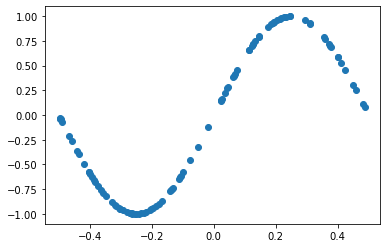

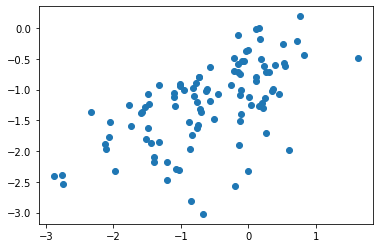

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator (Sequential)       (None, 2)                 202       
_________________________________________________________________
Discriminator (Sequential)   (None, 1)                 101       
Total params: 303
Trainable params: 202
Non-trainable params: 101
_________________________________________________________________
[GAN training] Epoch 99/60000:
        Acc. real: 0.5040000081062317
        Acc. fake: 1.0


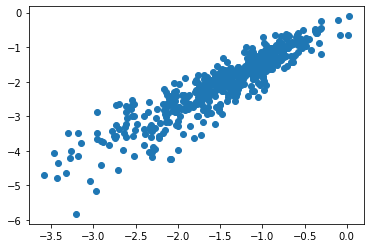

[GAN training] Epoch 199/60000:
        Acc. real: 0.49799999594688416
        Acc. fake: 0.06599999964237213


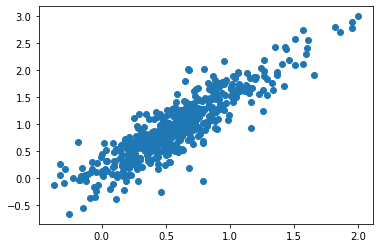

[GAN training] Epoch 299/60000:
        Acc. real: 0.12399999797344208
        Acc. fake: 0.46799999475479126


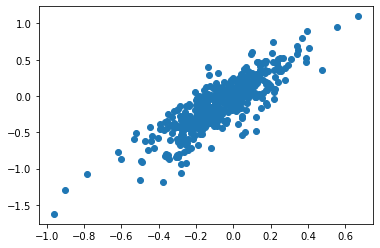

[GAN training] Epoch 399/60000:
        Acc. real: 0.5860000252723694
        Acc. fake: 0.4560000002384186


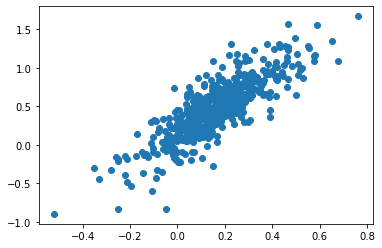

[GAN training] Epoch 499/60000:
        Acc. real: 0.9319999814033508
        Acc. fake: 0.019999999552965164


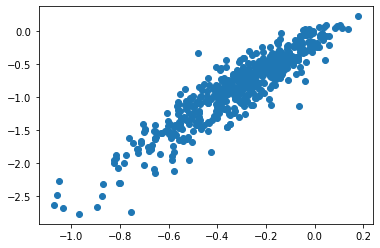

[GAN training] Epoch 599/60000:
        Acc. real: 0.5199999809265137
        Acc. fake: 0.10599999874830246


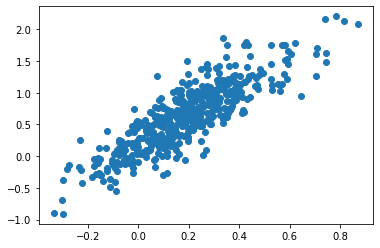

[GAN training] Epoch 699/60000:
        Acc. real: 0.4819999933242798
        Acc. fake: 0.17399999499320984


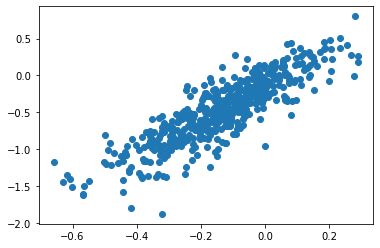

[GAN training] Epoch 799/60000:
        Acc. real: 0.49399998784065247
        Acc. fake: 0.45399999618530273


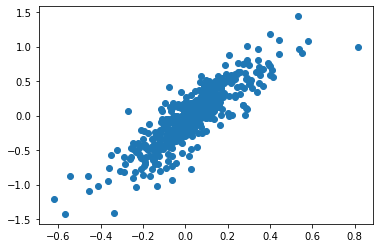

[GAN training] Epoch 899/60000:
        Acc. real: 0.5040000081062317
        Acc. fake: 0.7599999904632568


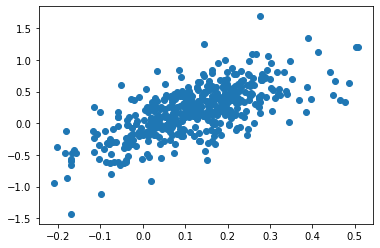

[GAN training] Epoch 999/60000:
        Acc. real: 0.4699999988079071
        Acc. fake: 0.8880000114440918


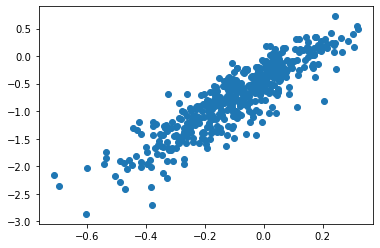

[GAN training] Epoch 1099/60000:
        Acc. real: 0.4359999895095825
        Acc. fake: 0.9900000095367432


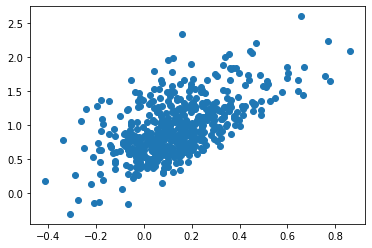

[GAN training] Epoch 1199/60000:
        Acc. real: 0.5699999928474426
        Acc. fake: 0.6380000114440918


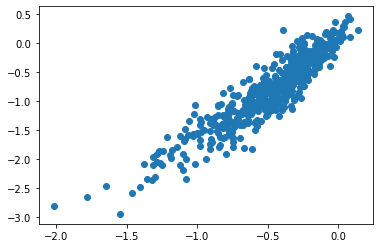

[GAN training] Epoch 1299/60000:
        Acc. real: 0.4659999907016754
        Acc. fake: 0.4880000054836273


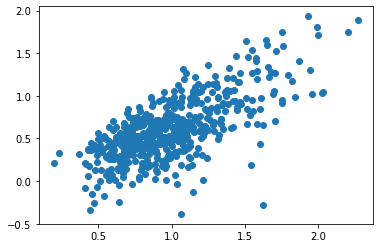

[GAN training] Epoch 1399/60000:
        Acc. real: 0.49000000953674316
        Acc. fake: 0.4000000059604645


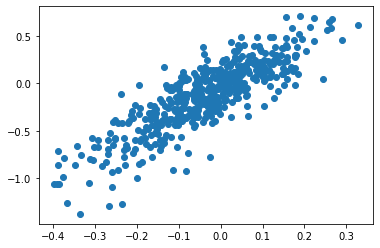

[GAN training] Epoch 1499/60000:
        Acc. real: 0.4480000138282776
        Acc. fake: 0.8759999871253967


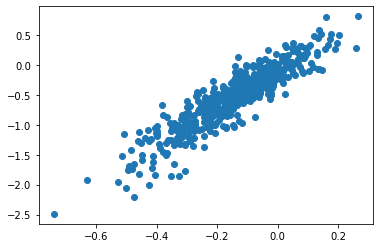

[GAN training] Epoch 1599/60000:
        Acc. real: 0.4620000123977661
        Acc. fake: 0.9959999918937683


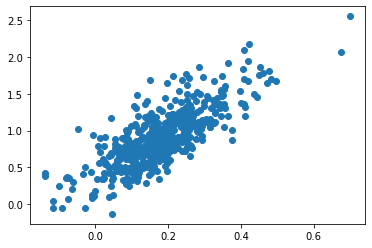

[GAN training] Epoch 1699/60000:
        Acc. real: 0.8859999775886536
        Acc. fake: 0.12399999797344208


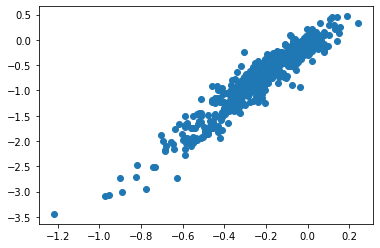

[GAN training] Epoch 1799/60000:
        Acc. real: 0.49000000953674316
        Acc. fake: 0.14000000059604645


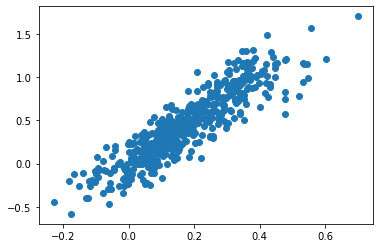

[GAN training] Epoch 1899/60000:
        Acc. real: 0.5220000147819519
        Acc. fake: 0.6079999804496765


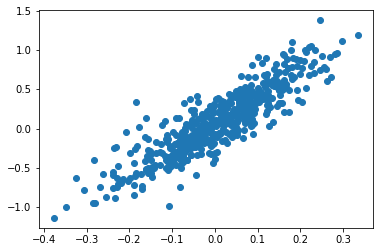

[GAN training] Epoch 1999/60000:
        Acc. real: 0.5419999957084656
        Acc. fake: 0.8379999995231628


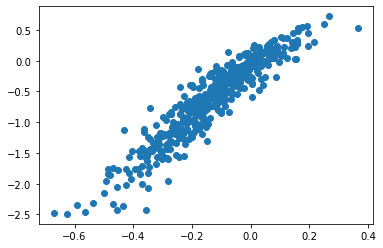

[GAN training] Epoch 2099/60000:
        Acc. real: 0.46000000834465027
        Acc. fake: 1.0


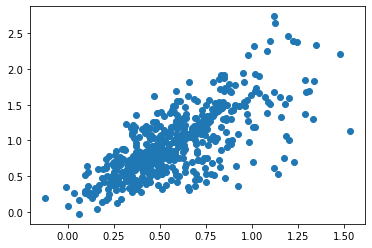

[GAN training] Epoch 2199/60000:
        Acc. real: 0.4860000014305115
        Acc. fake: 0.7540000081062317


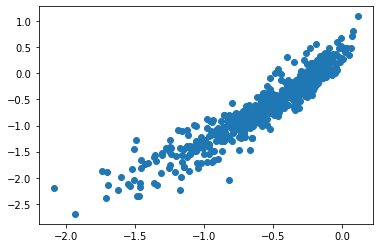

[GAN training] Epoch 2299/60000:
        Acc. real: 0.47999998927116394
        Acc. fake: 0.4440000057220459


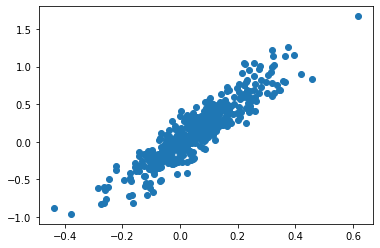

[GAN training] Epoch 2399/60000:
        Acc. real: 0.5
        Acc. fake: 0.9480000138282776


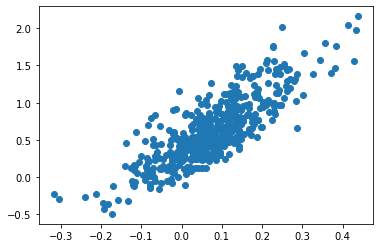

[GAN training] Epoch 2499/60000:
        Acc. real: 0.5120000243186951
        Acc. fake: 0.7879999876022339


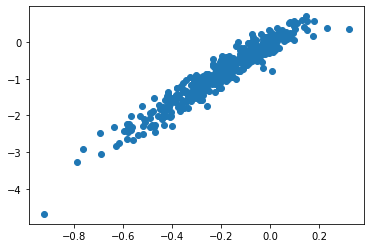

[GAN training] Epoch 2599/60000:
        Acc. real: 0.5299999713897705
        Acc. fake: 0.2800000011920929


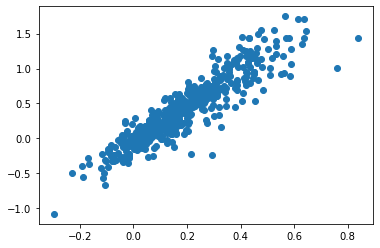

[GAN training] Epoch 2699/60000:
        Acc. real: 0.4519999921321869
        Acc. fake: 0.5860000252723694


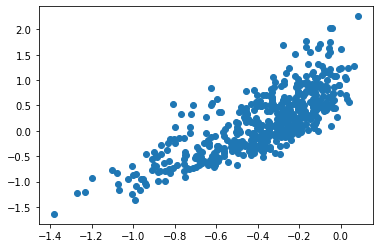

[GAN training] Epoch 2799/60000:
        Acc. real: 0.44600000977516174
        Acc. fake: 0.8140000104904175


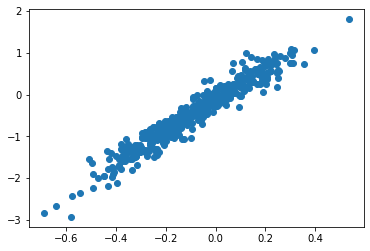

[GAN training] Epoch 2899/60000:
        Acc. real: 0.6800000071525574
        Acc. fake: 0.47600001096725464


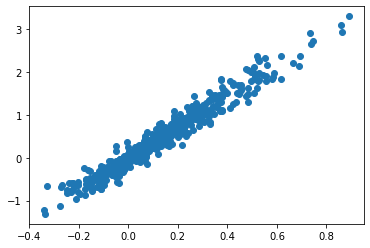

[GAN training] Epoch 2999/60000:
        Acc. real: 0.5519999861717224
        Acc. fake: 0.5460000038146973


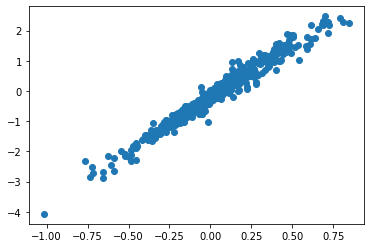

[GAN training] Epoch 3099/60000:
        Acc. real: 0.25
        Acc. fake: 0.6779999732971191


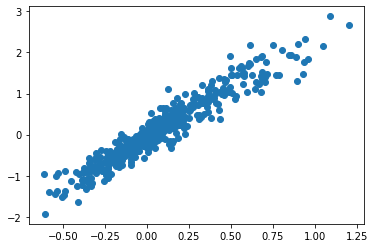

[GAN training] Epoch 3199/60000:
        Acc. real: 0.5199999809265137
        Acc. fake: 0.6299999952316284


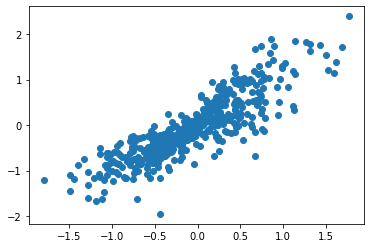

[GAN training] Epoch 3299/60000:
        Acc. real: 0.7540000081062317
        Acc. fake: 0.28200000524520874


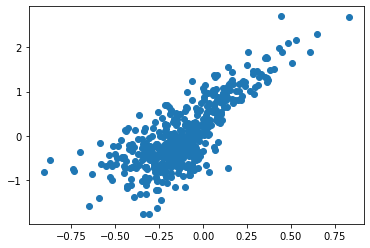

[GAN training] Epoch 3399/60000:
        Acc. real: 0.3540000021457672
        Acc. fake: 0.6140000224113464


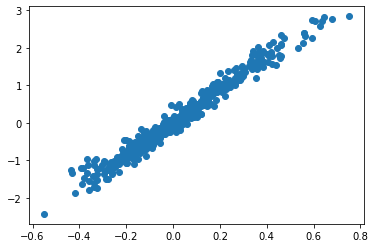

[GAN training] Epoch 3499/60000:
        Acc. real: 0.14000000059604645
        Acc. fake: 0.9620000123977661


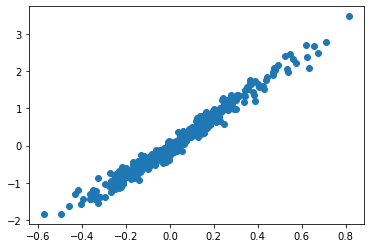

[GAN training] Epoch 3599/60000:
        Acc. real: 0.671999990940094
        Acc. fake: 0.4300000071525574


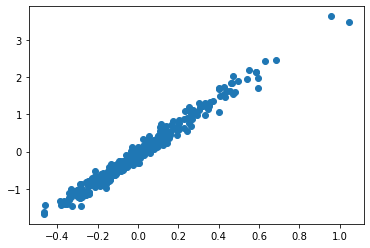

[GAN training] Epoch 3699/60000:
        Acc. real: 0.8740000128746033
        Acc. fake: 0.46799999475479126


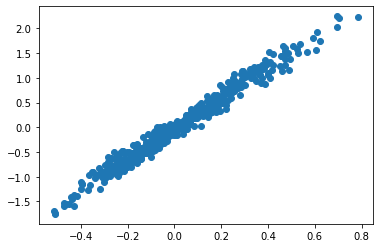

[GAN training] Epoch 3799/60000:
        Acc. real: 0.5720000267028809
        Acc. fake: 0.5960000157356262


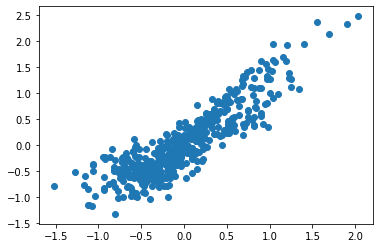

[GAN training] Epoch 3899/60000:
        Acc. real: 0.6940000057220459
        Acc. fake: 0.7200000286102295


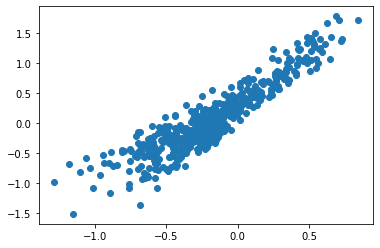

[GAN training] Epoch 3999/60000:
        Acc. real: 0.515999972820282
        Acc. fake: 0.6460000276565552


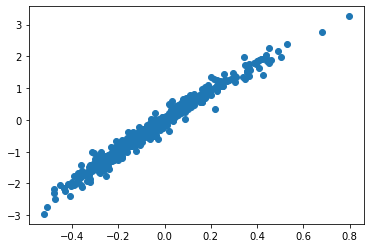

[GAN training] Epoch 4099/60000:
        Acc. real: 0.41600000858306885
        Acc. fake: 0.6359999775886536


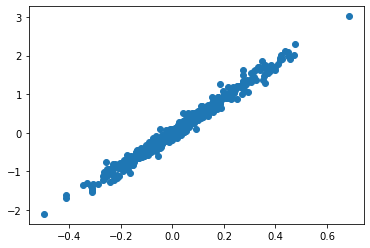

[GAN training] Epoch 4199/60000:
        Acc. real: 0.48399999737739563
        Acc. fake: 0.5479999780654907


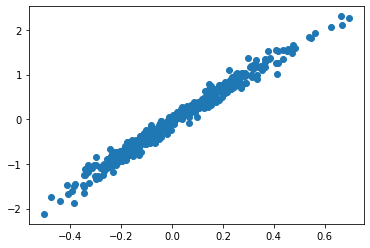

[GAN training] Epoch 4299/60000:
        Acc. real: 0.699999988079071
        Acc. fake: 0.41600000858306885


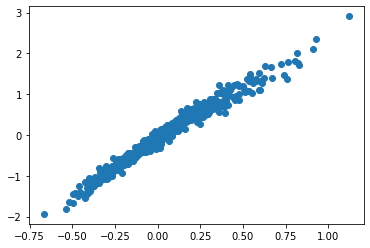

[GAN training] Epoch 4399/60000:
        Acc. real: 0.9020000100135803
        Acc. fake: 0.32600000500679016


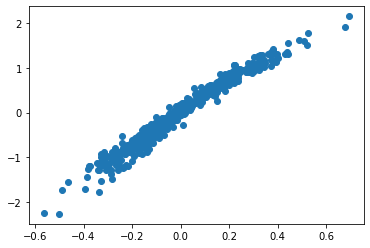

[GAN training] Epoch 4499/60000:
        Acc. real: 0.8920000195503235
        Acc. fake: 0.42399999499320984


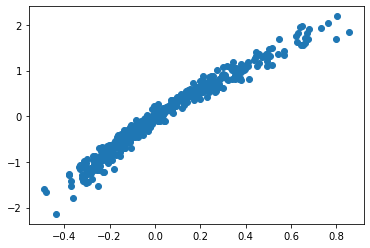

[GAN training] Epoch 4599/60000:
        Acc. real: 0.75
        Acc. fake: 0.2240000069141388


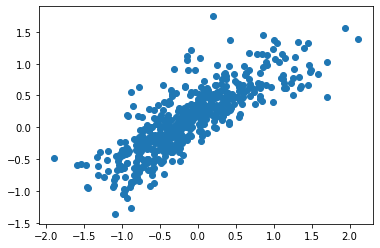

[GAN training] Epoch 4699/60000:
        Acc. real: 0.7960000038146973
        Acc. fake: 0.40799999237060547


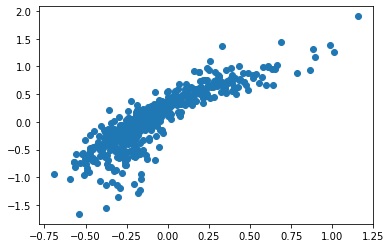

[GAN training] Epoch 4799/60000:
        Acc. real: 0.5580000281333923
        Acc. fake: 0.3659999966621399


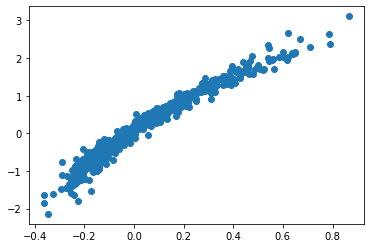

[GAN training] Epoch 4899/60000:
        Acc. real: 0.8320000171661377
        Acc. fake: 0.4580000042915344


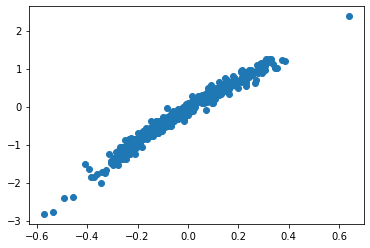

[GAN training] Epoch 4999/60000:
        Acc. real: 0.6079999804496765
        Acc. fake: 0.5699999928474426


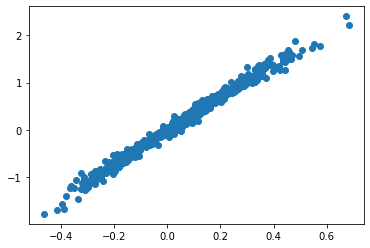

[GAN training] Epoch 5099/60000:
        Acc. real: 0.843999981880188
        Acc. fake: 0.40400001406669617


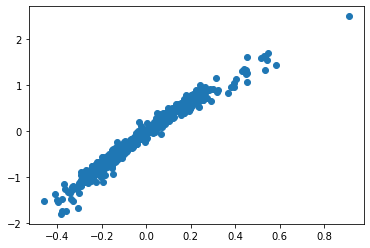

[GAN training] Epoch 5199/60000:
        Acc. real: 0.5699999928474426
        Acc. fake: 0.6639999747276306


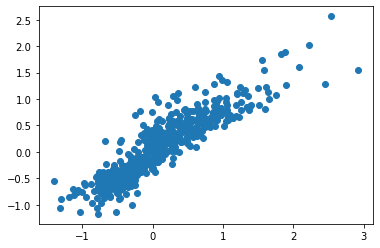

[GAN training] Epoch 5299/60000:
        Acc. real: 0.7739999890327454
        Acc. fake: 0.30799999833106995


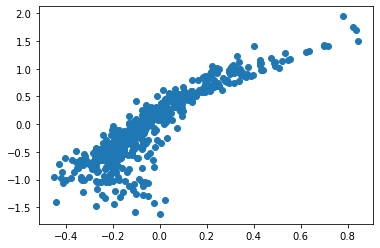

[GAN training] Epoch 5399/60000:
        Acc. real: 0.35199999809265137
        Acc. fake: 0.7260000109672546


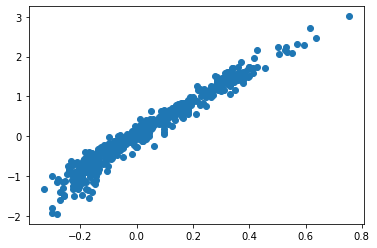

[GAN training] Epoch 5499/60000:
        Acc. real: 0.8199999928474426
        Acc. fake: 0.38199999928474426


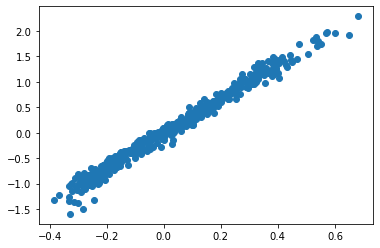

[GAN training] Epoch 5599/60000:
        Acc. real: 0.8180000185966492
        Acc. fake: 0.5180000066757202


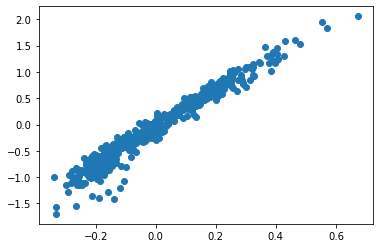

[GAN training] Epoch 5699/60000:
        Acc. real: 0.5360000133514404
        Acc. fake: 0.5979999899864197


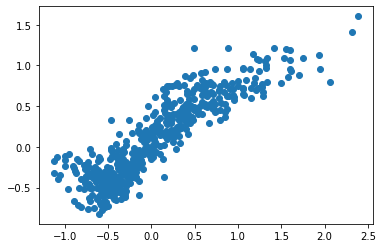

[GAN training] Epoch 5799/60000:
        Acc. real: 0.7720000147819519
        Acc. fake: 0.2919999957084656


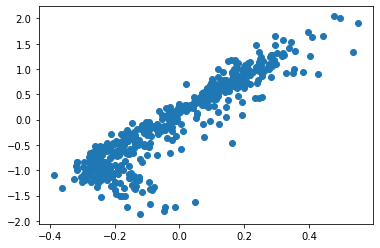

[GAN training] Epoch 5899/60000:
        Acc. real: 0.7459999918937683
        Acc. fake: 0.4440000057220459


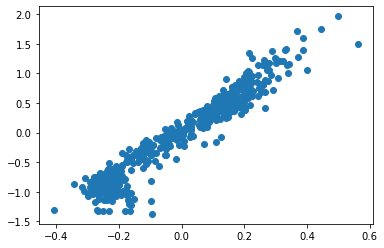

[GAN training] Epoch 5999/60000:
        Acc. real: 0.7300000190734863
        Acc. fake: 0.4180000126361847


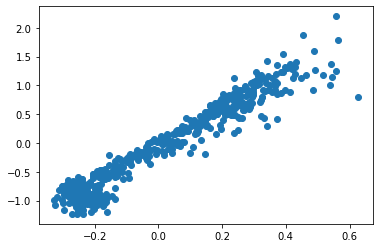

[GAN training] Epoch 6099/60000:
        Acc. real: 0.6639999747276306
        Acc. fake: 0.31200000643730164


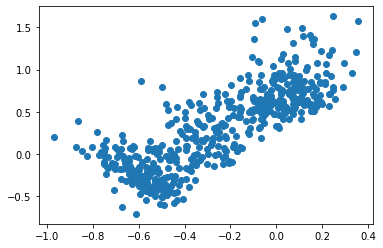

[GAN training] Epoch 6199/60000:
        Acc. real: 0.6600000262260437
        Acc. fake: 0.3880000114440918


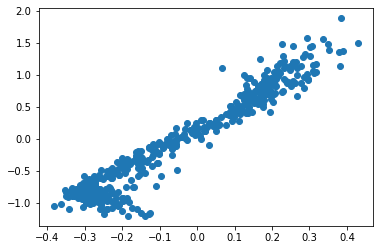

[GAN training] Epoch 6299/60000:
        Acc. real: 0.6499999761581421
        Acc. fake: 0.421999990940094


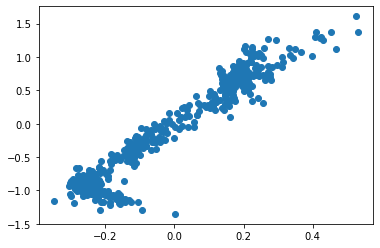

[GAN training] Epoch 6399/60000:
        Acc. real: 0.3160000145435333
        Acc. fake: 0.9779999852180481


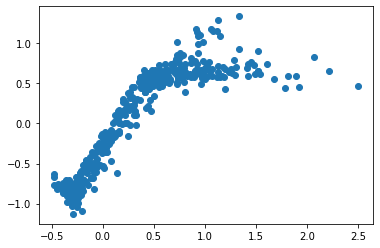

[GAN training] Epoch 6499/60000:
        Acc. real: 0.6079999804496765
        Acc. fake: 0.29600000381469727


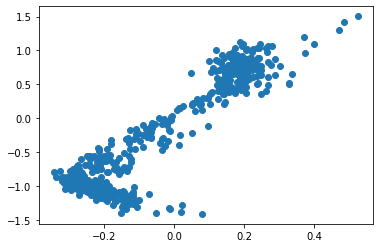

[GAN training] Epoch 6599/60000:
        Acc. real: 0.421999990940094
        Acc. fake: 0.6140000224113464


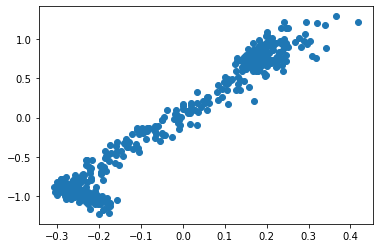

[GAN training] Epoch 6699/60000:
        Acc. real: 0.23999999463558197
        Acc. fake: 0.6399999856948853


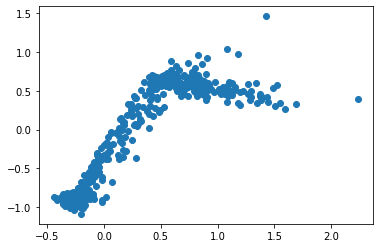

[GAN training] Epoch 6799/60000:
        Acc. real: 0.49399998784065247
        Acc. fake: 0.30000001192092896


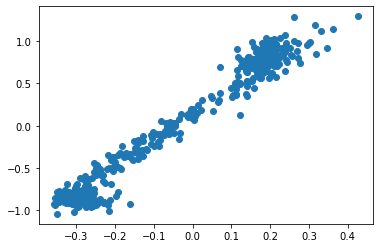

[GAN training] Epoch 6899/60000:
        Acc. real: 0.421999990940094
        Acc. fake: 0.6740000247955322


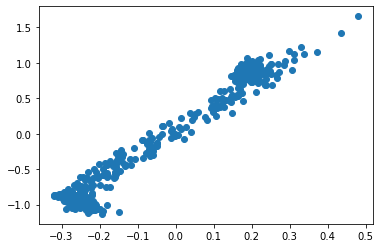

[GAN training] Epoch 6999/60000:
        Acc. real: 0.09000000357627869
        Acc. fake: 0.9879999756813049


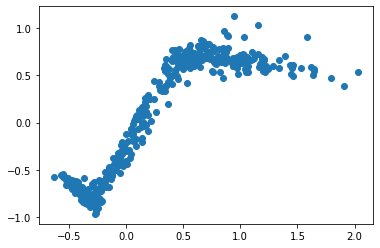

[GAN training] Epoch 7099/60000:
        Acc. real: 0.38600000739097595
        Acc. fake: 0.5759999752044678


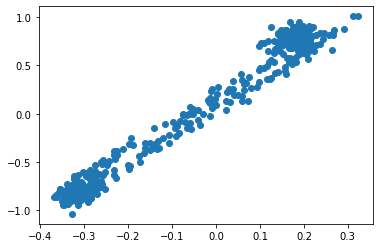

[GAN training] Epoch 7199/60000:
        Acc. real: 0.11800000071525574
        Acc. fake: 0.9900000095367432


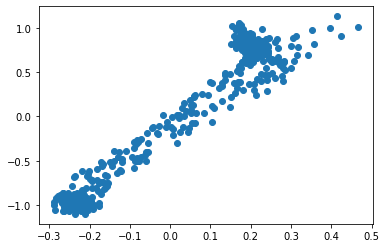

[GAN training] Epoch 7299/60000:
        Acc. real: 0.42800000309944153
        Acc. fake: 0.6240000128746033


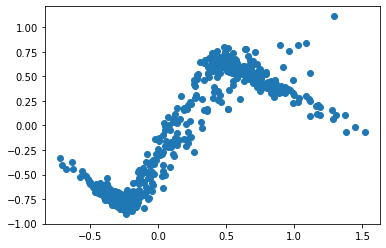

[GAN training] Epoch 7399/60000:
        Acc. real: 0.5419999957084656
        Acc. fake: 0.4480000138282776


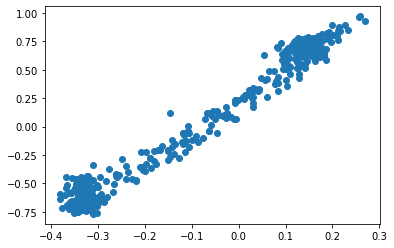

[GAN training] Epoch 7499/60000:
        Acc. real: 0.11800000071525574
        Acc. fake: 0.9279999732971191


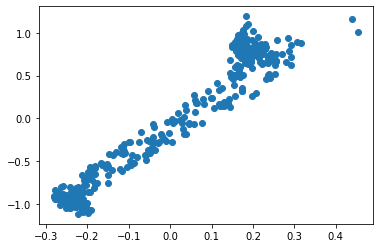

[GAN training] Epoch 7599/60000:
        Acc. real: 0.20800000429153442
        Acc. fake: 0.828000009059906


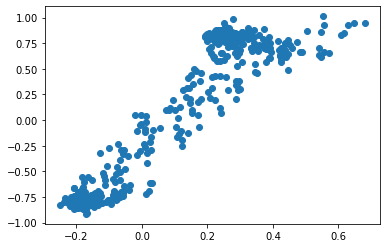

[GAN training] Epoch 7699/60000:
        Acc. real: 0.7360000014305115
        Acc. fake: 0.14399999380111694


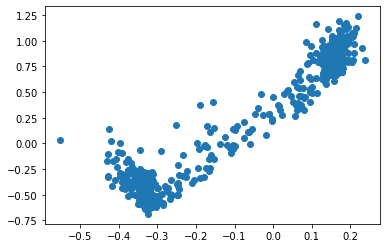

[GAN training] Epoch 7799/60000:
        Acc. real: 0.46000000834465027
        Acc. fake: 0.7099999785423279


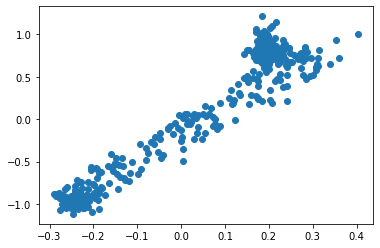

[GAN training] Epoch 7899/60000:
        Acc. real: 0.20399999618530273
        Acc. fake: 0.7160000205039978


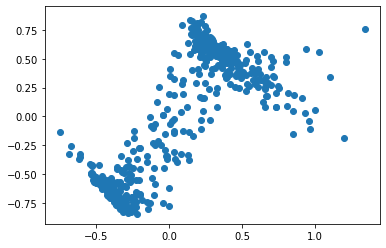

[GAN training] Epoch 7999/60000:
        Acc. real: 0.7919999957084656
        Acc. fake: 0.20999999344348907


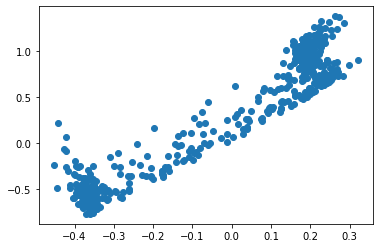

[GAN training] Epoch 8099/60000:
        Acc. real: 0.2879999876022339
        Acc. fake: 0.7760000228881836


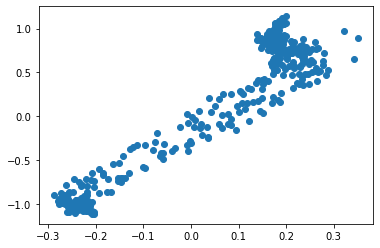

[GAN training] Epoch 8199/60000:
        Acc. real: 0.20200000703334808
        Acc. fake: 0.9660000205039978


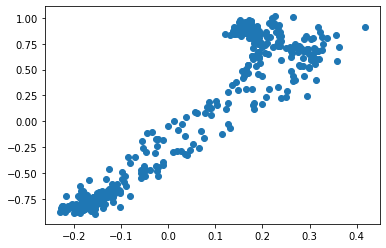

[GAN training] Epoch 8299/60000:
        Acc. real: 0.25
        Acc. fake: 0.43799999356269836


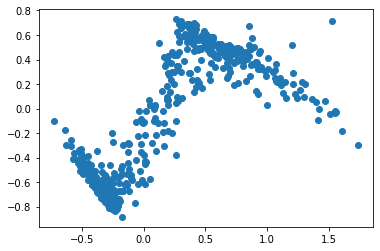

[GAN training] Epoch 8399/60000:
        Acc. real: 0.6940000057220459
        Acc. fake: 0.20999999344348907


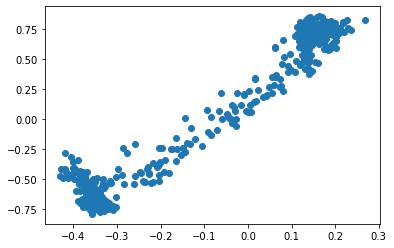

[GAN training] Epoch 8499/60000:
        Acc. real: 0.3540000021457672
        Acc. fake: 0.7139999866485596


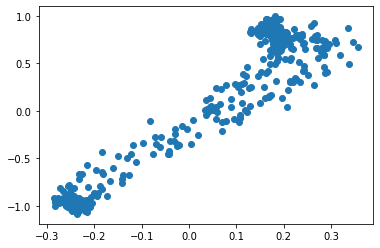

[GAN training] Epoch 8599/60000:
        Acc. real: 0.23199999332427979
        Acc. fake: 0.8999999761581421


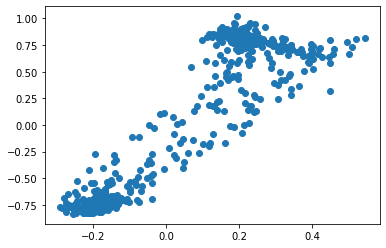

[GAN training] Epoch 8699/60000:
        Acc. real: 0.734000027179718
        Acc. fake: 0.2639999985694885


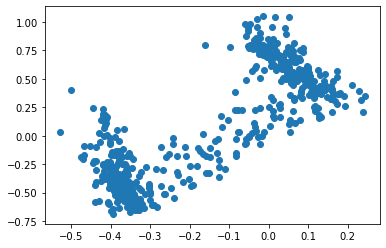

[GAN training] Epoch 8799/60000:
        Acc. real: 0.578000009059906
        Acc. fake: 0.38199999928474426


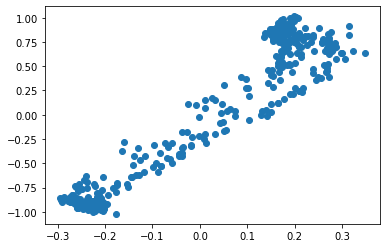

[GAN training] Epoch 8899/60000:
        Acc. real: 0.23000000417232513
        Acc. fake: 0.8360000252723694


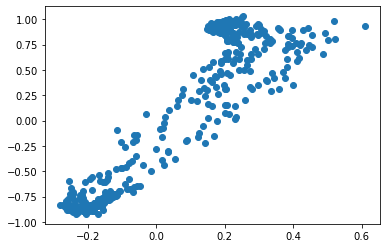

[GAN training] Epoch 8999/60000:
        Acc. real: 0.4659999907016754
        Acc. fake: 0.6240000128746033


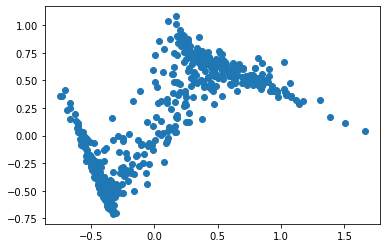

[GAN training] Epoch 9099/60000:
        Acc. real: 0.8539999723434448
        Acc. fake: 0.1720000058412552


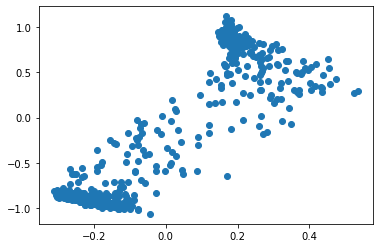

[GAN training] Epoch 9199/60000:
        Acc. real: 0.25600001215934753
        Acc. fake: 0.7120000123977661


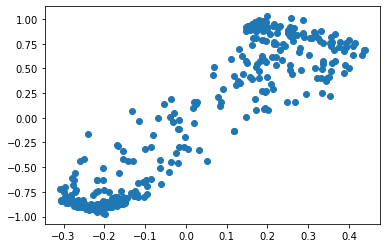

[GAN training] Epoch 9299/60000:
        Acc. real: 0.2879999876022339
        Acc. fake: 0.7979999780654907


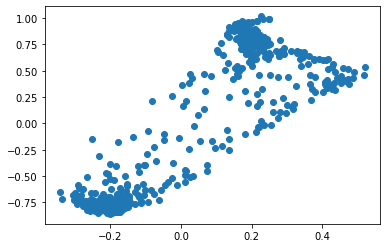

[GAN training] Epoch 9399/60000:
        Acc. real: 0.6639999747276306
        Acc. fake: 0.2980000078678131


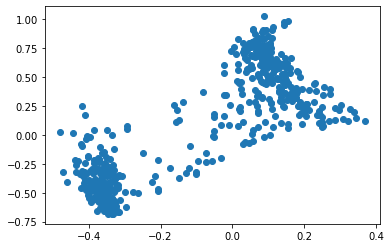

[GAN training] Epoch 9499/60000:
        Acc. real: 0.37599998712539673
        Acc. fake: 0.6579999923706055


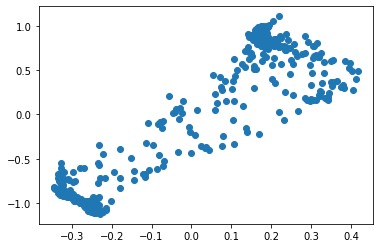

[GAN training] Epoch 9599/60000:
        Acc. real: 0.15600000321865082
        Acc. fake: 0.9580000042915344


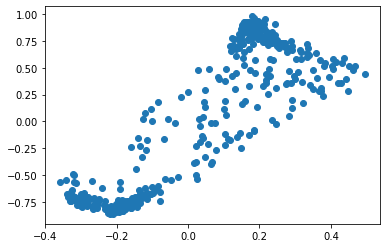

[GAN training] Epoch 9699/60000:
        Acc. real: 0.4959999918937683
        Acc. fake: 0.30799999833106995


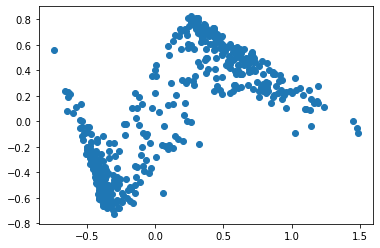

[GAN training] Epoch 9799/60000:
        Acc. real: 0.7979999780654907
        Acc. fake: 0.21799999475479126


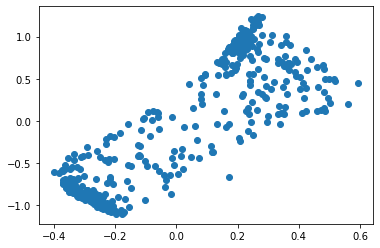

[GAN training] Epoch 9899/60000:
        Acc. real: 0.31200000643730164
        Acc. fake: 0.6980000138282776


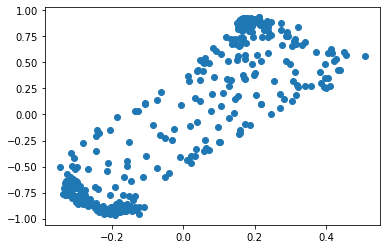

[GAN training] Epoch 9999/60000:
        Acc. real: 0.17599999904632568
        Acc. fake: 0.9359999895095825


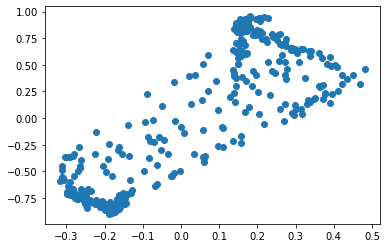

[GAN training] Epoch 10099/60000:
        Acc. real: 0.3659999966621399
        Acc. fake: 0.4059999883174896


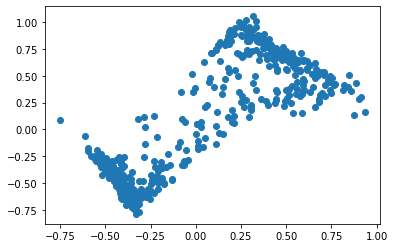

[GAN training] Epoch 10199/60000:
        Acc. real: 0.8080000281333923
        Acc. fake: 0.17599999904632568


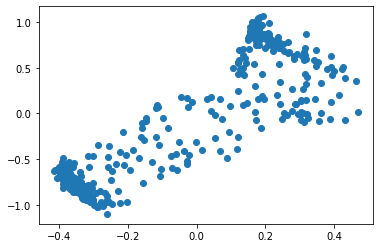

[GAN training] Epoch 10299/60000:
        Acc. real: 0.2879999876022339
        Acc. fake: 0.6759999990463257


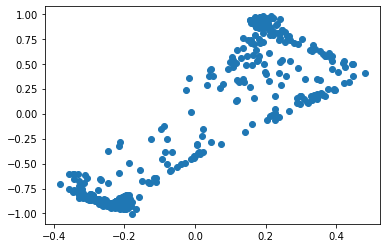

[GAN training] Epoch 10399/60000:
        Acc. real: 0.6499999761581421
        Acc. fake: 0.4099999964237213


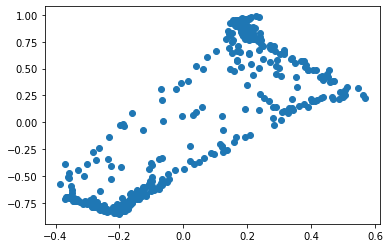

[GAN training] Epoch 10499/60000:
        Acc. real: 0.5080000162124634
        Acc. fake: 0.4620000123977661


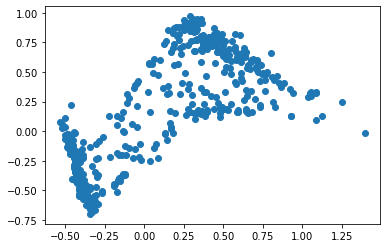

[GAN training] Epoch 10599/60000:
        Acc. real: 0.5519999861717224
        Acc. fake: 0.2980000078678131


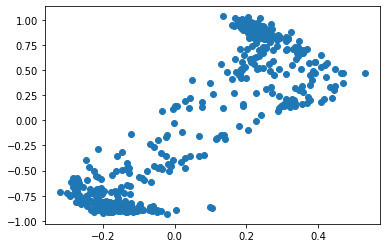

[GAN training] Epoch 10699/60000:
        Acc. real: 0.09600000083446503
        Acc. fake: 0.9520000219345093


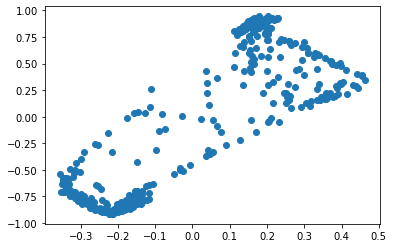

[GAN training] Epoch 10799/60000:
        Acc. real: 0.49000000953674316
        Acc. fake: 0.5580000281333923


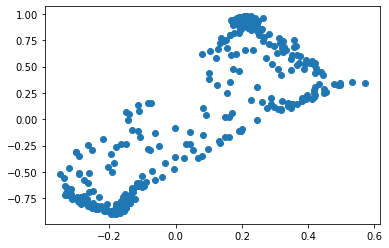

[GAN training] Epoch 10899/60000:
        Acc. real: 0.4659999907016754
        Acc. fake: 0.4659999907016754


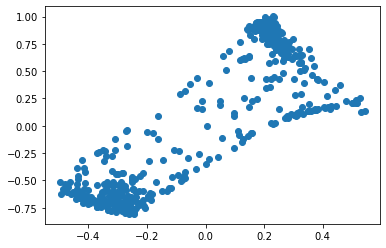

[GAN training] Epoch 10999/60000:
        Acc. real: 0.7720000147819519
        Acc. fake: 0.15199999511241913


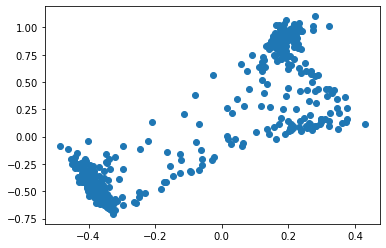

[GAN training] Epoch 11099/60000:
        Acc. real: 0.33399999141693115
        Acc. fake: 0.6819999814033508


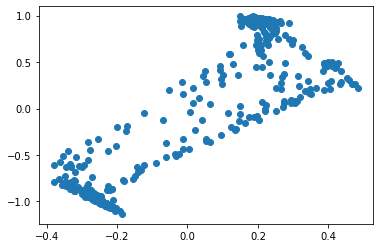

[GAN training] Epoch 11199/60000:
        Acc. real: 0.09399999678134918
        Acc. fake: 0.9259999990463257


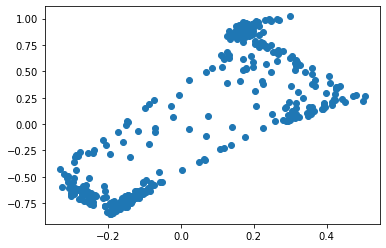

[GAN training] Epoch 11299/60000:
        Acc. real: 0.30000001192092896
        Acc. fake: 0.7319999933242798


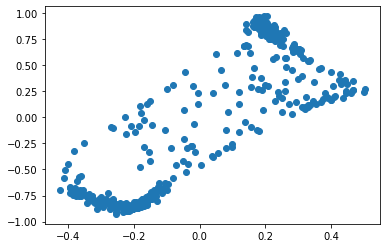

[GAN training] Epoch 11399/60000:
        Acc. real: 0.7300000190734863
        Acc. fake: 0.4860000014305115


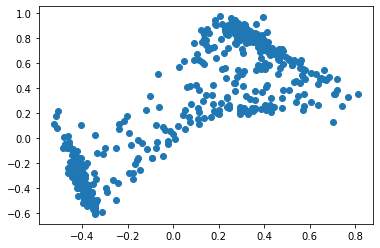

[GAN training] Epoch 11499/60000:
        Acc. real: 0.550000011920929
        Acc. fake: 0.4819999933242798


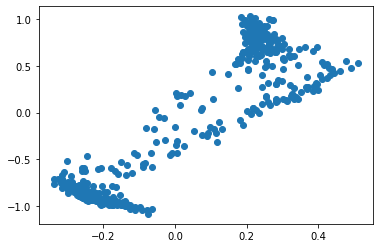

[GAN training] Epoch 11599/60000:
        Acc. real: 0.328000009059906
        Acc. fake: 0.6679999828338623


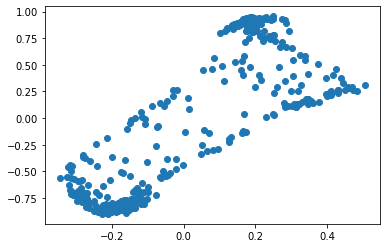

[GAN training] Epoch 11699/60000:
        Acc. real: 0.328000009059906
        Acc. fake: 0.699999988079071


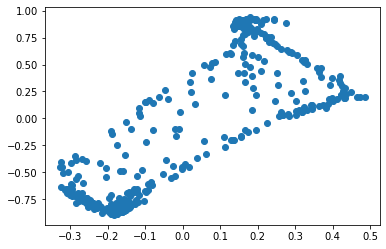

[GAN training] Epoch 11799/60000:
        Acc. real: 0.47999998927116394
        Acc. fake: 0.5320000052452087


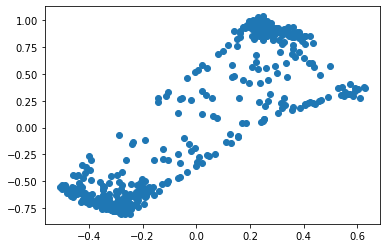

[GAN training] Epoch 11899/60000:
        Acc. real: 0.8799999952316284
        Acc. fake: 0.16200000047683716


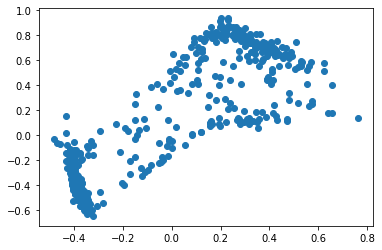

[GAN training] Epoch 11999/60000:
        Acc. real: 0.5120000243186951
        Acc. fake: 0.40400001406669617


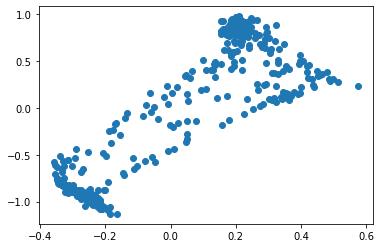

[GAN training] Epoch 12099/60000:
        Acc. real: 0.25999999046325684
        Acc. fake: 0.7039999961853027


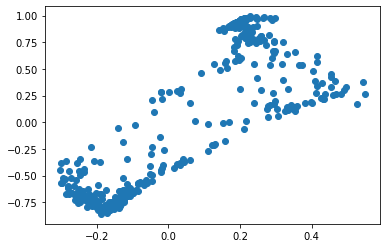

[GAN training] Epoch 12199/60000:
        Acc. real: 0.2199999988079071
        Acc. fake: 0.6679999828338623


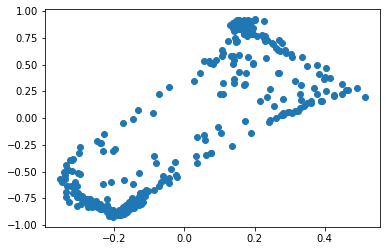

[GAN training] Epoch 12299/60000:
        Acc. real: 0.28600001335144043
        Acc. fake: 0.4699999988079071


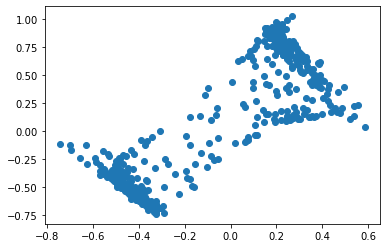

[GAN training] Epoch 12399/60000:
        Acc. real: 0.7839999794960022
        Acc. fake: 0.17000000178813934


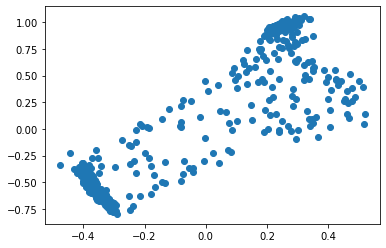

[GAN training] Epoch 12499/60000:
        Acc. real: 0.3059999942779541
        Acc. fake: 0.7260000109672546


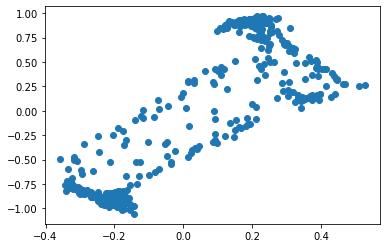

[GAN training] Epoch 12599/60000:
        Acc. real: 0.39800000190734863
        Acc. fake: 0.6240000128746033


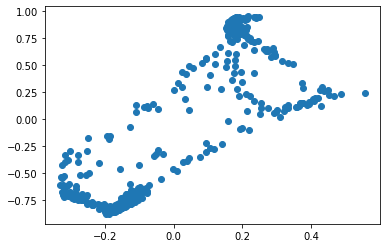

[GAN training] Epoch 12699/60000:
        Acc. real: 0.18400000035762787
        Acc. fake: 0.8560000061988831


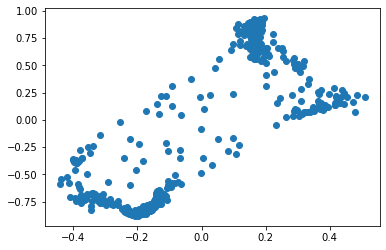

[GAN training] Epoch 12799/60000:
        Acc. real: 0.5040000081062317
        Acc. fake: 0.527999997138977


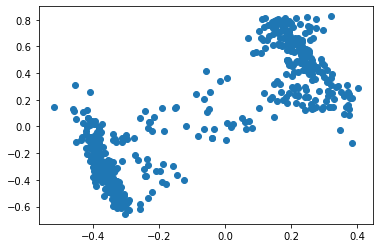

[GAN training] Epoch 12899/60000:
        Acc. real: 0.7680000066757202
        Acc. fake: 0.22200000286102295


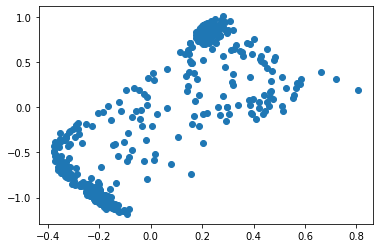

[GAN training] Epoch 12999/60000:
        Acc. real: 0.06800000369548798
        Acc. fake: 0.9620000123977661


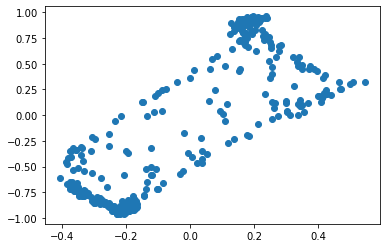

[GAN training] Epoch 13099/60000:
        Acc. real: 0.37400001287460327
        Acc. fake: 0.5600000023841858


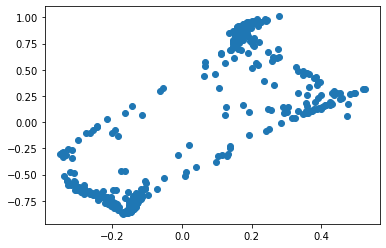

[GAN training] Epoch 13199/60000:
        Acc. real: 0.20600000023841858
        Acc. fake: 0.7940000295639038


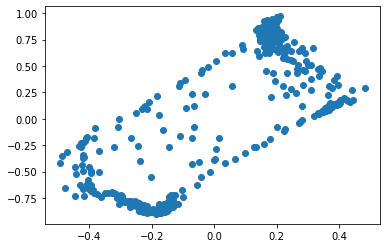

[GAN training] Epoch 13299/60000:
        Acc. real: 0.23800000548362732
        Acc. fake: 0.7440000176429749


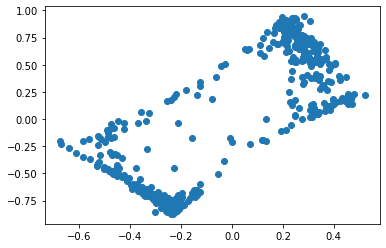

[GAN training] Epoch 13399/60000:
        Acc. real: 0.8820000290870667
        Acc. fake: 0.06400000303983688


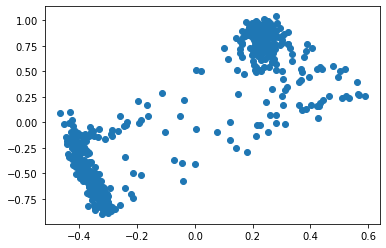

[GAN training] Epoch 13499/60000:
        Acc. real: 0.18799999356269836
        Acc. fake: 0.765999972820282


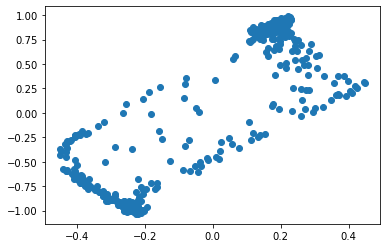

[GAN training] Epoch 13599/60000:
        Acc. real: 0.5040000081062317
        Acc. fake: 0.4480000138282776


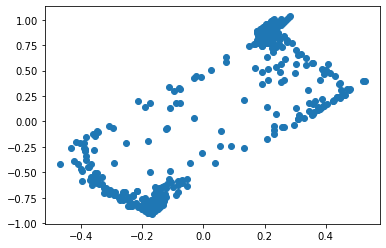

[GAN training] Epoch 13699/60000:
        Acc. real: 0.12999999523162842
        Acc. fake: 0.8460000157356262


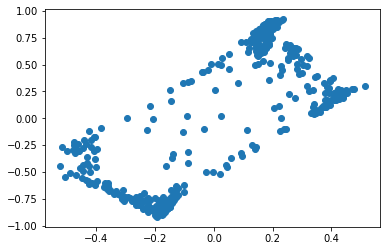

[GAN training] Epoch 13799/60000:
        Acc. real: 0.41999998688697815
        Acc. fake: 0.46799999475479126


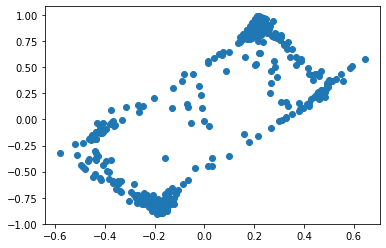

[GAN training] Epoch 13899/60000:
        Acc. real: 0.164000004529953
        Acc. fake: 0.7799999713897705


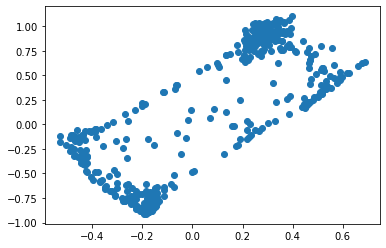

[GAN training] Epoch 13999/60000:
        Acc. real: 0.492000013589859
        Acc. fake: 0.5080000162124634


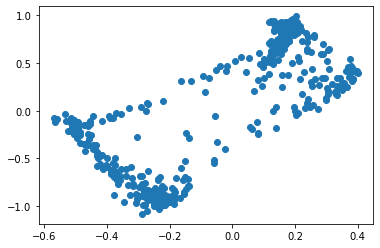

[GAN training] Epoch 14099/60000:
        Acc. real: 0.5139999985694885
        Acc. fake: 0.49000000953674316


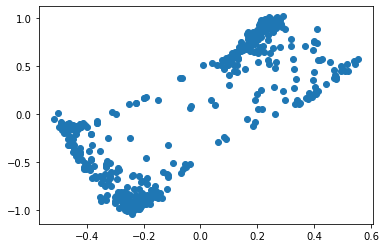

[GAN training] Epoch 14199/60000:
        Acc. real: 0.3440000116825104
        Acc. fake: 0.6119999885559082


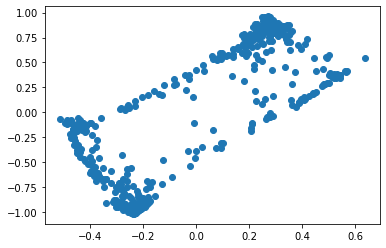

[GAN training] Epoch 14299/60000:
        Acc. real: 0.2980000078678131
        Acc. fake: 0.6259999871253967


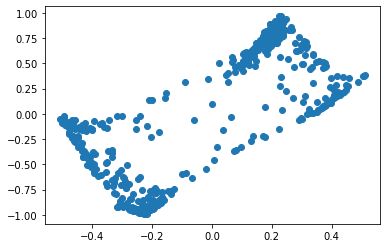

[GAN training] Epoch 14399/60000:
        Acc. real: 0.550000011920929
        Acc. fake: 0.39399999380111694


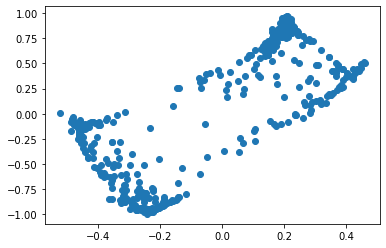

[GAN training] Epoch 14499/60000:
        Acc. real: 0.5960000157356262
        Acc. fake: 0.5239999890327454


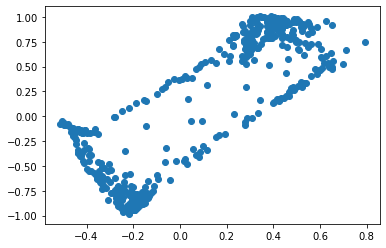

[GAN training] Epoch 14599/60000:
        Acc. real: 0.6359999775886536
        Acc. fake: 0.3179999887943268


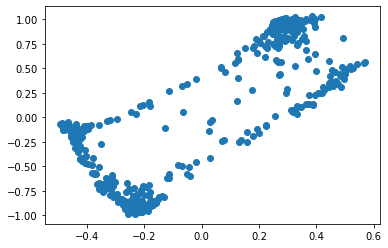

[GAN training] Epoch 14699/60000:
        Acc. real: 0.722000002861023
        Acc. fake: 0.30399999022483826


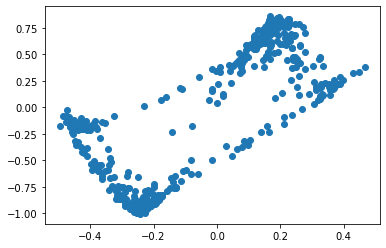

[GAN training] Epoch 14799/60000:
        Acc. real: 0.3199999928474426
        Acc. fake: 0.6639999747276306


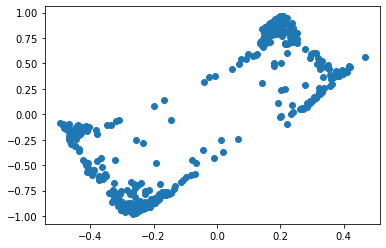

[GAN training] Epoch 14899/60000:
        Acc. real: 0.5960000157356262
        Acc. fake: 0.5


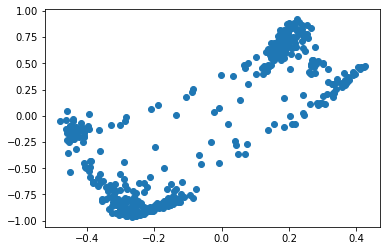

[GAN training] Epoch 14999/60000:
        Acc. real: 0.23999999463558197
        Acc. fake: 0.7720000147819519


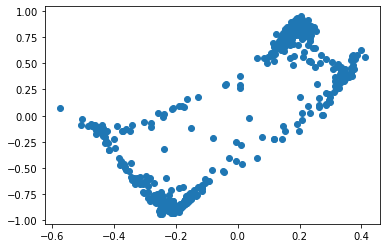

[GAN training] Epoch 15099/60000:
        Acc. real: 0.7360000014305115
        Acc. fake: 0.33000001311302185


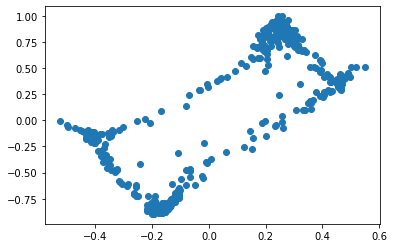

[GAN training] Epoch 15199/60000:
        Acc. real: 0.06599999964237213
        Acc. fake: 0.9860000014305115


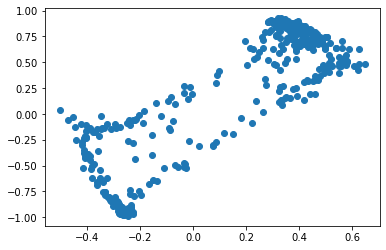

[GAN training] Epoch 15299/60000:
        Acc. real: 0.5799999833106995
        Acc. fake: 0.49000000953674316


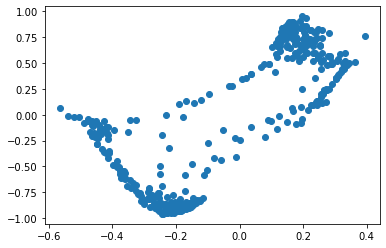

[GAN training] Epoch 15399/60000:
        Acc. real: 0.414000004529953
        Acc. fake: 0.6819999814033508


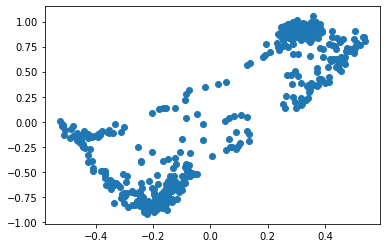

[GAN training] Epoch 15499/60000:
        Acc. real: 0.5799999833106995
        Acc. fake: 0.527999997138977


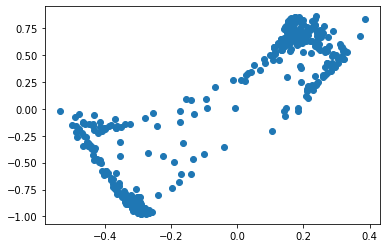

[GAN training] Epoch 15599/60000:
        Acc. real: 0.6740000247955322
        Acc. fake: 0.5019999742507935


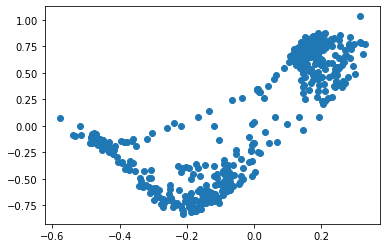

[GAN training] Epoch 15699/60000:
        Acc. real: 0.5360000133514404
        Acc. fake: 0.6660000085830688


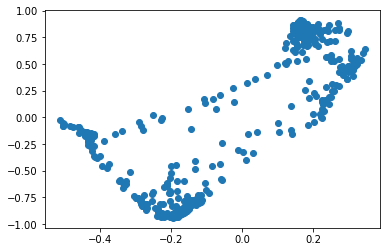

[GAN training] Epoch 15799/60000:
        Acc. real: 0.4059999883174896
        Acc. fake: 0.6460000276565552


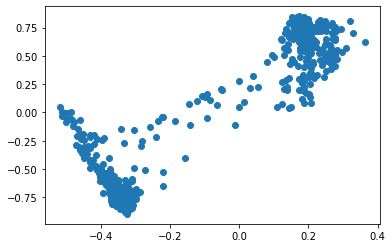

[GAN training] Epoch 15899/60000:
        Acc. real: 0.7960000038146973
        Acc. fake: 0.22599999606609344


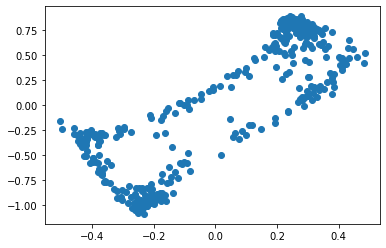

[GAN training] Epoch 15999/60000:
        Acc. real: 0.7039999961853027
        Acc. fake: 0.49399998784065247


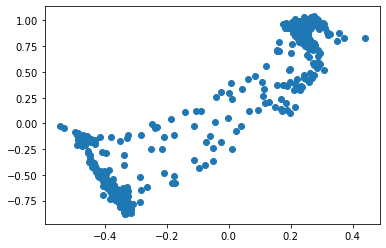

[GAN training] Epoch 16099/60000:
        Acc. real: 0.7080000042915344
        Acc. fake: 0.24400000274181366


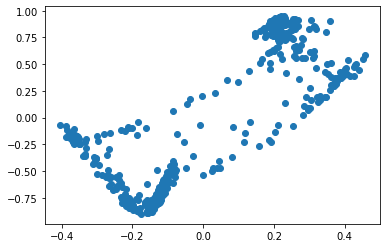

[GAN training] Epoch 16199/60000:
        Acc. real: 0.7459999918937683
        Acc. fake: 0.3160000145435333


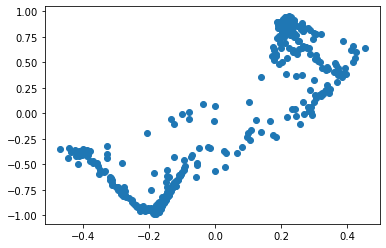

[GAN training] Epoch 16299/60000:
        Acc. real: 0.722000002861023
        Acc. fake: 0.2840000092983246


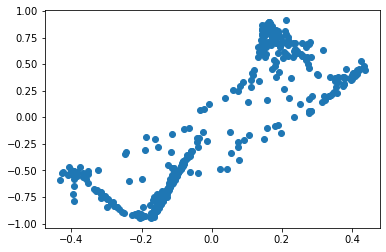

[GAN training] Epoch 16399/60000:
        Acc. real: 0.44600000977516174
        Acc. fake: 0.7020000219345093


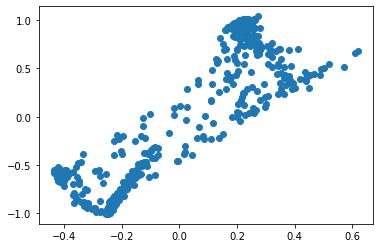

[GAN training] Epoch 16499/60000:
        Acc. real: 0.8080000281333923
        Acc. fake: 0.3700000047683716


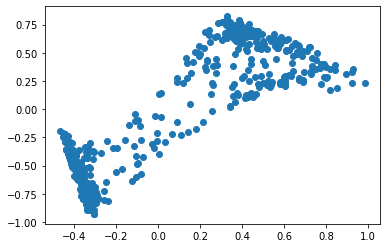

[GAN training] Epoch 16599/60000:
        Acc. real: 0.7599999904632568
        Acc. fake: 0.30399999022483826


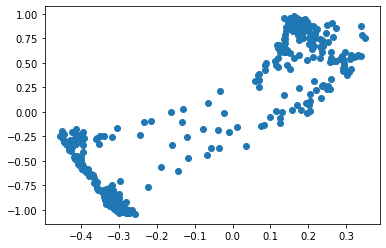

[GAN training] Epoch 16699/60000:
        Acc. real: 0.44600000977516174
        Acc. fake: 0.5559999942779541


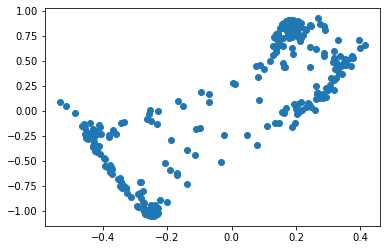

[GAN training] Epoch 16799/60000:
        Acc. real: 0.8960000276565552
        Acc. fake: 0.25600001215934753


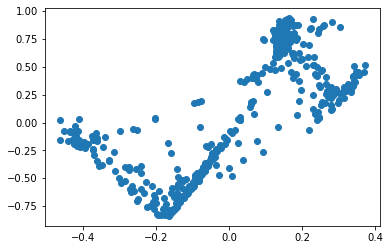

[GAN training] Epoch 16899/60000:
        Acc. real: 0.7559999823570251
        Acc. fake: 0.2919999957084656


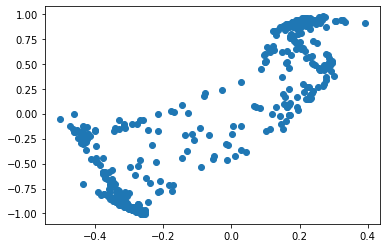

[GAN training] Epoch 16999/60000:
        Acc. real: 0.24199999868869781
        Acc. fake: 0.6959999799728394


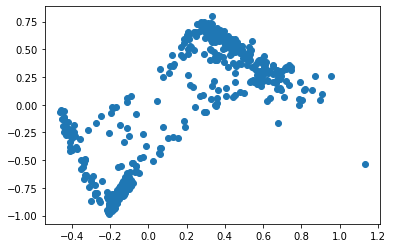

[GAN training] Epoch 17099/60000:
        Acc. real: 0.6499999761581421
        Acc. fake: 0.27000001072883606


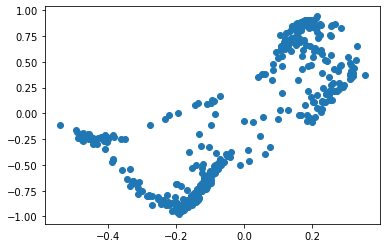

[GAN training] Epoch 17199/60000:
        Acc. real: 0.20399999618530273
        Acc. fake: 0.8379999995231628


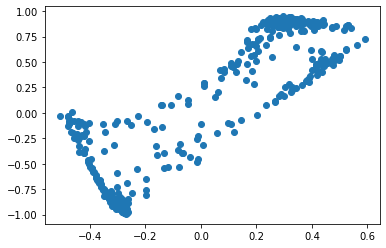

[GAN training] Epoch 17299/60000:
        Acc. real: 0.5759999752044678
        Acc. fake: 0.5740000009536743


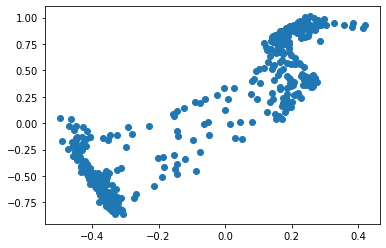

[GAN training] Epoch 17399/60000:
        Acc. real: 0.47200000286102295
        Acc. fake: 0.6039999723434448


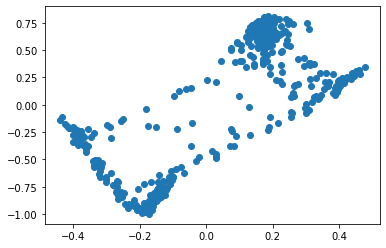

[GAN training] Epoch 17499/60000:
        Acc. real: 0.8460000157356262
        Acc. fake: 0.21400000154972076


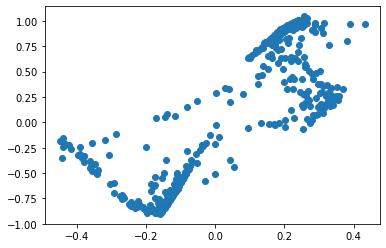

[GAN training] Epoch 17599/60000:
        Acc. real: 0.1940000057220459
        Acc. fake: 0.8840000033378601


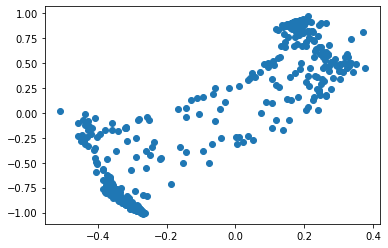

[GAN training] Epoch 17699/60000:
        Acc. real: 0.36000001430511475
        Acc. fake: 0.906000018119812


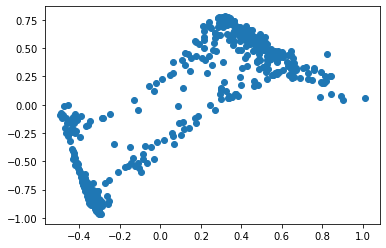

[GAN training] Epoch 17799/60000:
        Acc. real: 0.3019999861717224
        Acc. fake: 0.9120000004768372


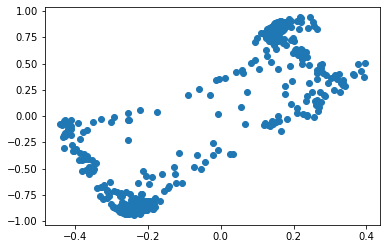

[GAN training] Epoch 17899/60000:
        Acc. real: 0.5820000171661377
        Acc. fake: 0.5339999794960022


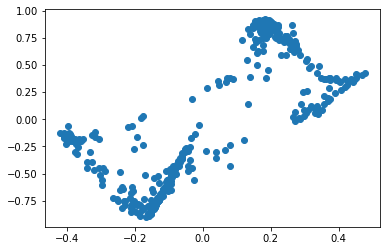

[GAN training] Epoch 17999/60000:
        Acc. real: 0.6819999814033508
        Acc. fake: 0.3479999899864197


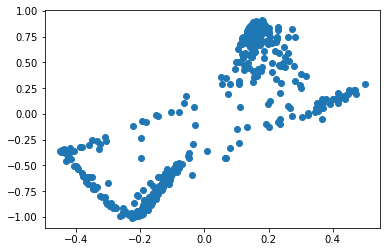

[GAN training] Epoch 18099/60000:
        Acc. real: 0.578000009059906
        Acc. fake: 0.5180000066757202


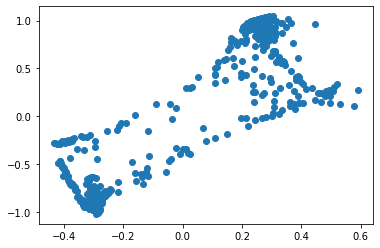

[GAN training] Epoch 18199/60000:
        Acc. real: 0.40400001406669617
        Acc. fake: 0.8080000281333923


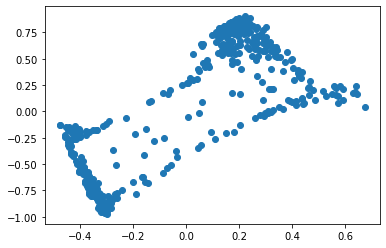

[GAN training] Epoch 18299/60000:
        Acc. real: 0.6000000238418579
        Acc. fake: 0.5080000162124634


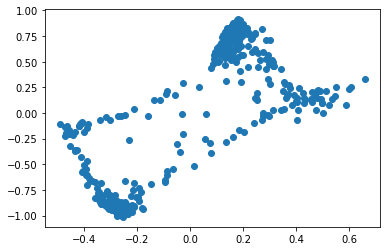

[GAN training] Epoch 18399/60000:
        Acc. real: 0.7099999785423279
        Acc. fake: 0.21199999749660492


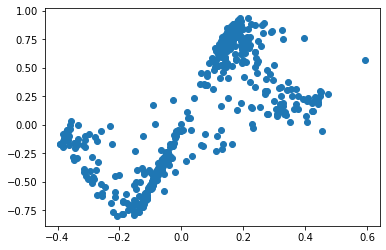

[GAN training] Epoch 18499/60000:
        Acc. real: 0.8159999847412109
        Acc. fake: 0.17800000309944153


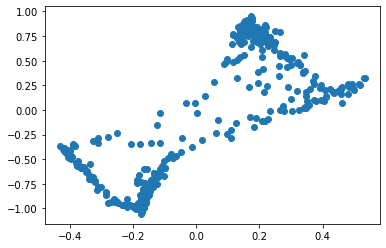

[GAN training] Epoch 18599/60000:
        Acc. real: 0.6600000262260437
        Acc. fake: 0.36399999260902405


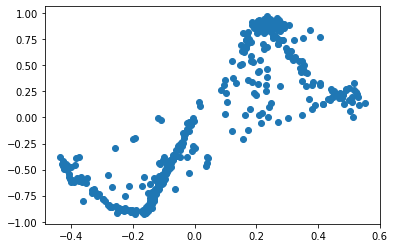

[GAN training] Epoch 18699/60000:
        Acc. real: 0.6759999990463257
        Acc. fake: 0.3959999978542328


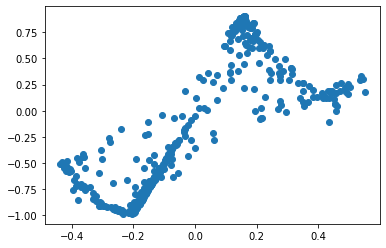

[GAN training] Epoch 18799/60000:
        Acc. real: 0.5920000076293945
        Acc. fake: 0.28999999165534973


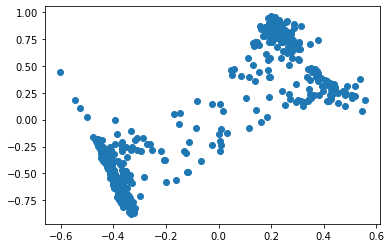

[GAN training] Epoch 18899/60000:
        Acc. real: 0.6000000238418579
        Acc. fake: 0.4699999988079071


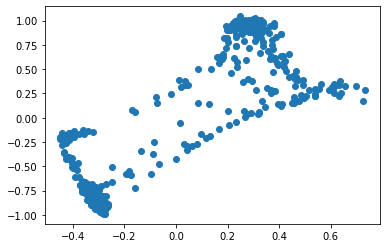

[GAN training] Epoch 18999/60000:
        Acc. real: 0.14000000059604645
        Acc. fake: 0.9020000100135803


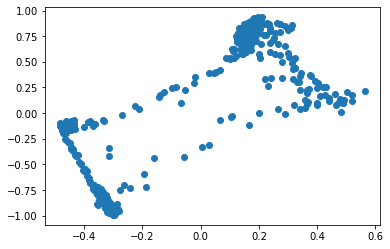

[GAN training] Epoch 19099/60000:
        Acc. real: 0.2240000069141388
        Acc. fake: 0.9039999842643738


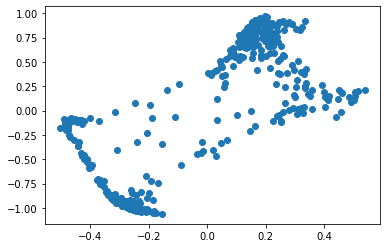

[GAN training] Epoch 19199/60000:
        Acc. real: 0.5080000162124634
        Acc. fake: 0.5360000133514404


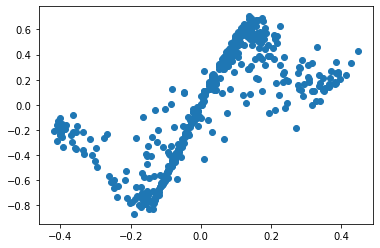

[GAN training] Epoch 19299/60000:
        Acc. real: 0.871999979019165
        Acc. fake: 0.164000004529953


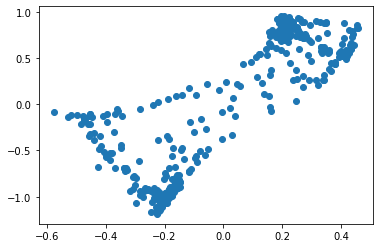

[GAN training] Epoch 19399/60000:
        Acc. real: 0.2160000056028366
        Acc. fake: 0.9359999895095825


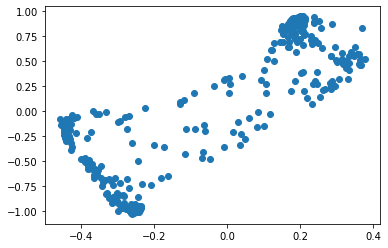

[GAN training] Epoch 19499/60000:
        Acc. real: 0.4560000002384186
        Acc. fake: 0.5839999914169312


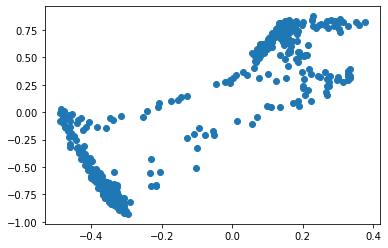

[GAN training] Epoch 19599/60000:
        Acc. real: 0.6800000071525574
        Acc. fake: 0.1940000057220459


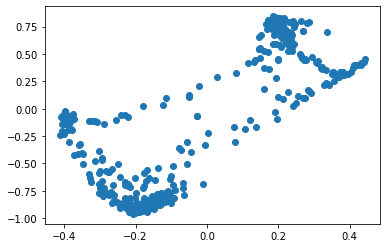

[GAN training] Epoch 19699/60000:
        Acc. real: 0.734000027179718
        Acc. fake: 0.23600000143051147


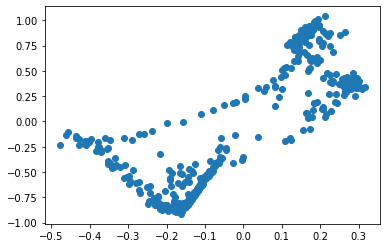

[GAN training] Epoch 19799/60000:
        Acc. real: 0.5419999957084656
        Acc. fake: 0.578000009059906


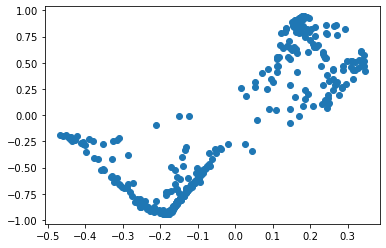

[GAN training] Epoch 19899/60000:
        Acc. real: 0.7739999890327454
        Acc. fake: 0.23199999332427979


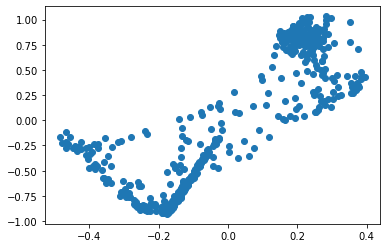

[GAN training] Epoch 19999/60000:
        Acc. real: 0.49000000953674316
        Acc. fake: 0.6420000195503235


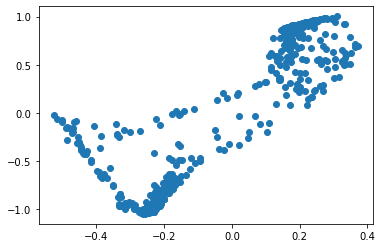

[GAN training] Epoch 20099/60000:
        Acc. real: 0.4819999933242798
        Acc. fake: 0.8460000157356262


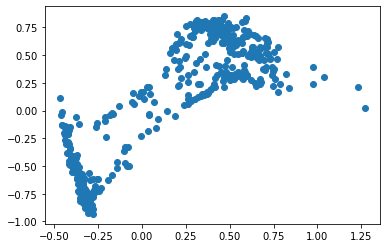

[GAN training] Epoch 20199/60000:
        Acc. real: 0.41200000047683716
        Acc. fake: 0.8040000200271606


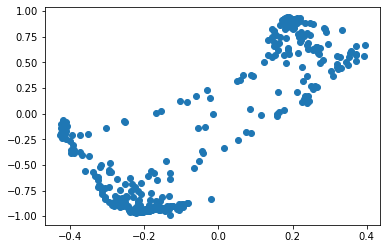

[GAN training] Epoch 20299/60000:
        Acc. real: 0.8100000023841858
        Acc. fake: 0.38999998569488525


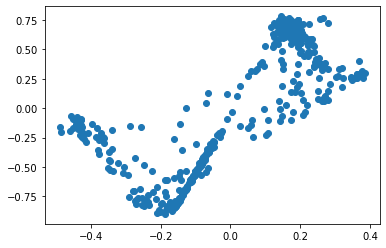

[GAN training] Epoch 20399/60000:
        Acc. real: 0.5419999957084656
        Acc. fake: 0.5360000133514404


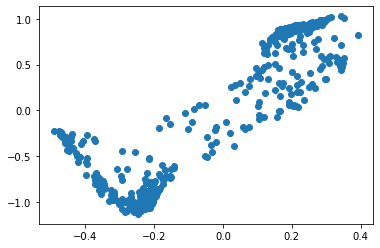

[GAN training] Epoch 20499/60000:
        Acc. real: 0.46799999475479126
        Acc. fake: 0.6439999938011169


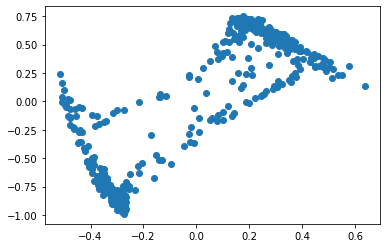

[GAN training] Epoch 20599/60000:
        Acc. real: 0.2199999988079071
        Acc. fake: 0.9359999895095825


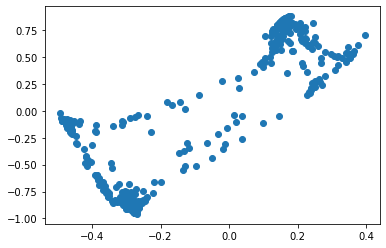

[GAN training] Epoch 20699/60000:
        Acc. real: 0.49799999594688416
        Acc. fake: 0.5460000038146973


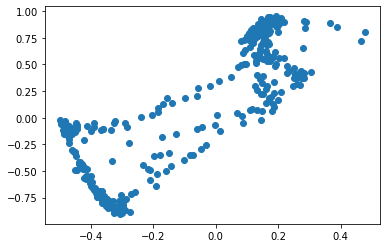

[GAN training] Epoch 20799/60000:
        Acc. real: 0.6399999856948853
        Acc. fake: 0.28999999165534973


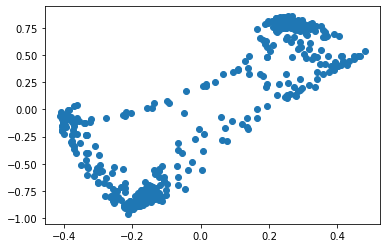

[GAN training] Epoch 20899/60000:
        Acc. real: 0.8019999861717224
        Acc. fake: 0.1940000057220459


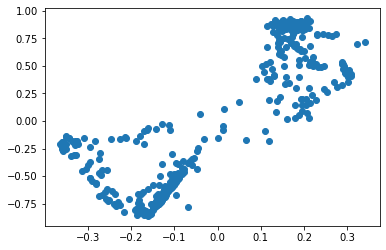

[GAN training] Epoch 20999/60000:
        Acc. real: 0.46799999475479126
        Acc. fake: 0.6499999761581421


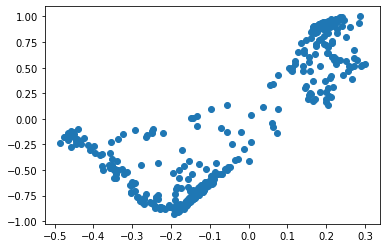

[GAN training] Epoch 21099/60000:
        Acc. real: 0.8920000195503235
        Acc. fake: 0.3059999942779541


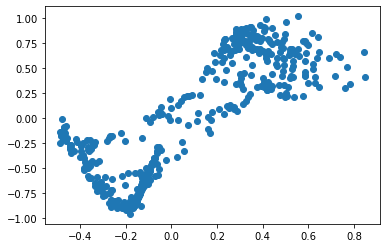

[GAN training] Epoch 21199/60000:
        Acc. real: 0.47999998927116394
        Acc. fake: 0.5759999752044678


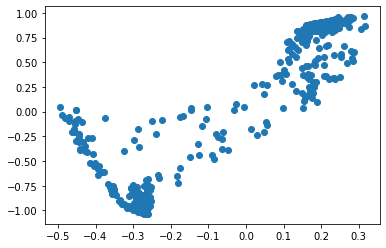

[GAN training] Epoch 21299/60000:
        Acc. real: 0.33399999141693115
        Acc. fake: 0.8939999938011169


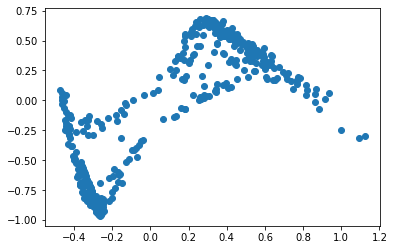

[GAN training] Epoch 21399/60000:
        Acc. real: 0.5019999742507935
        Acc. fake: 0.5740000009536743


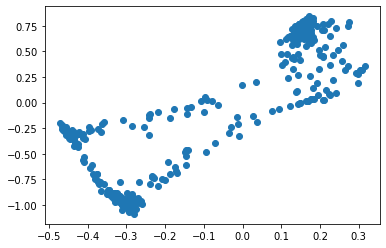

[GAN training] Epoch 21499/60000:
        Acc. real: 0.828000009059906
        Acc. fake: 0.24799999594688416


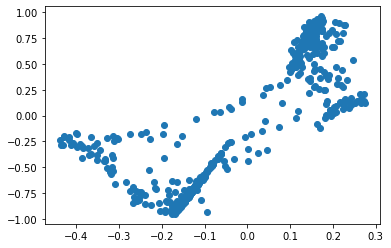

[GAN training] Epoch 21599/60000:
        Acc. real: 0.20999999344348907
        Acc. fake: 0.9380000233650208


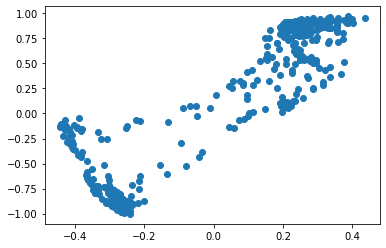

[GAN training] Epoch 21699/60000:
        Acc. real: 0.5400000214576721
        Acc. fake: 0.5


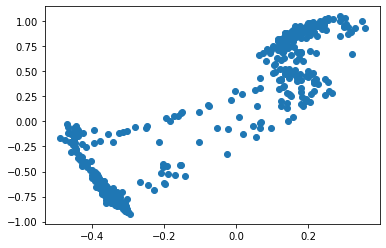

[GAN training] Epoch 21799/60000:
        Acc. real: 0.3240000009536743
        Acc. fake: 0.7139999866485596


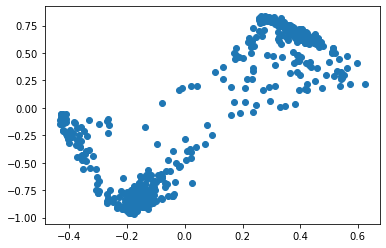

[GAN training] Epoch 21899/60000:
        Acc. real: 0.8560000061988831
        Acc. fake: 0.19599999487400055


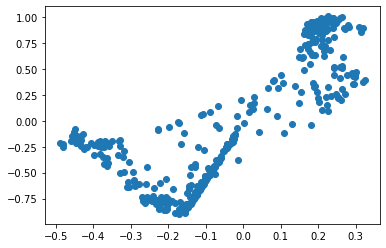

[GAN training] Epoch 21999/60000:
        Acc. real: 0.2919999957084656
        Acc. fake: 0.8980000019073486


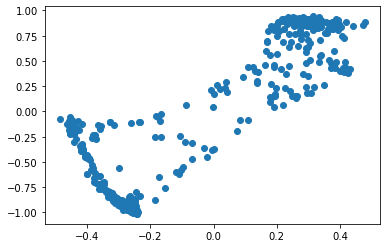

[GAN training] Epoch 22099/60000:
        Acc. real: 0.5419999957084656
        Acc. fake: 0.5379999876022339


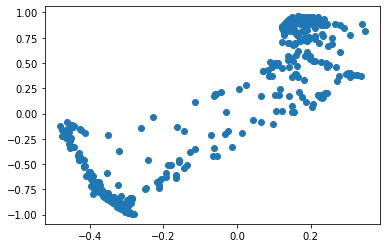

[GAN training] Epoch 22199/60000:
        Acc. real: 0.27399998903274536
        Acc. fake: 0.828000009059906


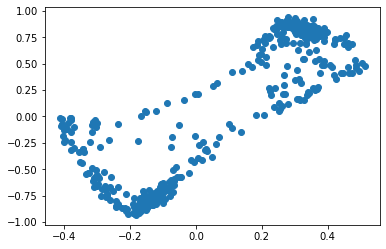

[GAN training] Epoch 22299/60000:
        Acc. real: 0.7620000243186951
        Acc. fake: 0.1979999989271164


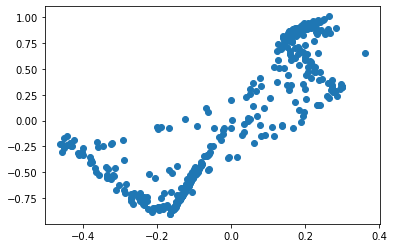

[GAN training] Epoch 22399/60000:
        Acc. real: 0.4339999854564667
        Acc. fake: 0.7160000205039978


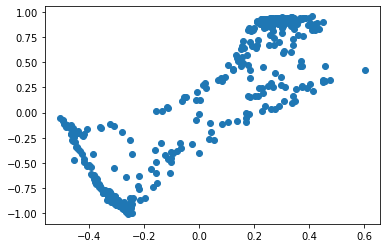

[GAN training] Epoch 22499/60000:
        Acc. real: 0.5400000214576721
        Acc. fake: 0.4860000014305115


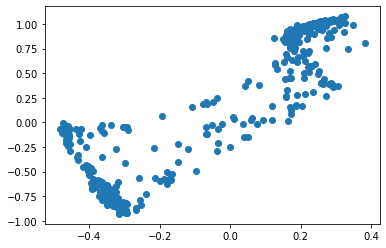

[GAN training] Epoch 22599/60000:
        Acc. real: 0.3479999899864197
        Acc. fake: 0.6179999709129333


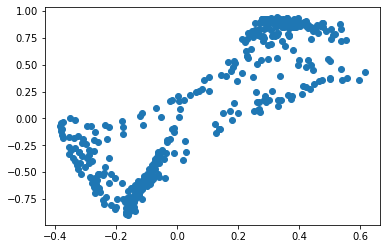

[GAN training] Epoch 22699/60000:
        Acc. real: 0.8859999775886536
        Acc. fake: 0.16599999368190765


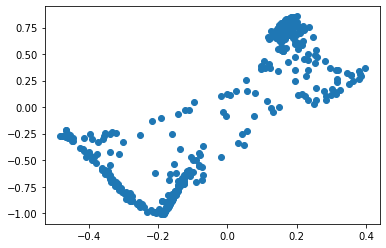

[GAN training] Epoch 22799/60000:
        Acc. real: 0.6700000166893005
        Acc. fake: 0.6600000262260437


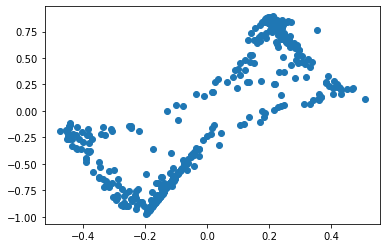

[GAN training] Epoch 22899/60000:
        Acc. real: 0.621999979019165
        Acc. fake: 0.3840000033378601


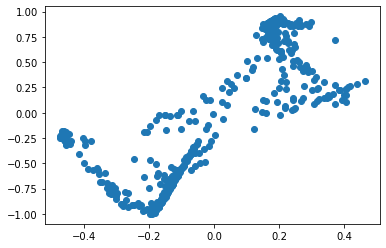

[GAN training] Epoch 22999/60000:
        Acc. real: 0.33799999952316284
        Acc. fake: 0.5920000076293945


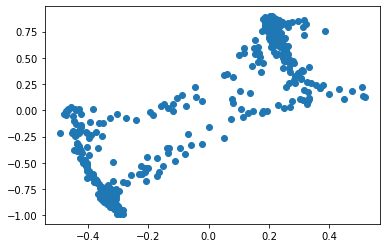

[GAN training] Epoch 23099/60000:
        Acc. real: 0.5659999847412109
        Acc. fake: 0.5419999957084656


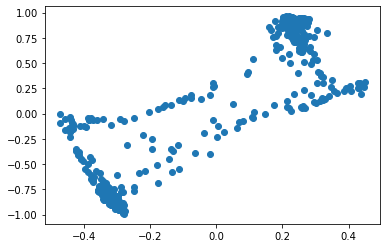

[GAN training] Epoch 23199/60000:
        Acc. real: 0.21199999749660492
        Acc. fake: 0.8679999709129333


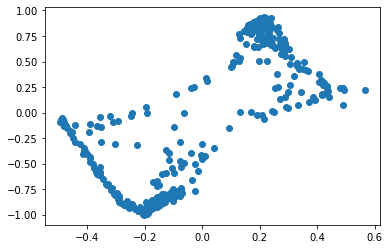

[GAN training] Epoch 23299/60000:
        Acc. real: 0.8180000185966492
        Acc. fake: 0.18000000715255737


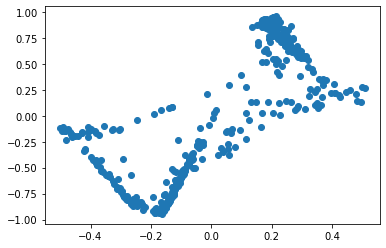

[GAN training] Epoch 23399/60000:
        Acc. real: 0.7419999837875366
        Acc. fake: 0.44200000166893005


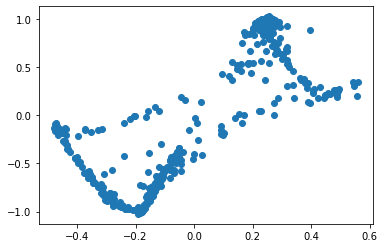

[GAN training] Epoch 23499/60000:
        Acc. real: 0.21799999475479126
        Acc. fake: 0.878000020980835


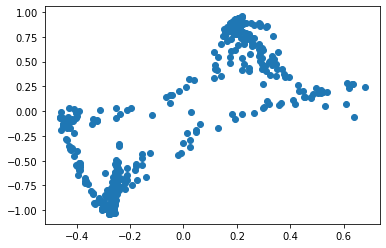

[GAN training] Epoch 23599/60000:
        Acc. real: 0.6140000224113464
        Acc. fake: 0.5080000162124634


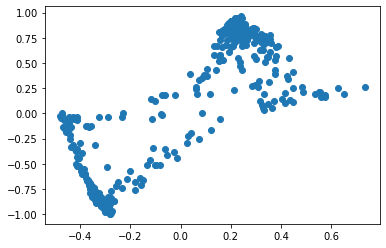

[GAN training] Epoch 23699/60000:
        Acc. real: 0.5960000157356262
        Acc. fake: 0.5040000081062317


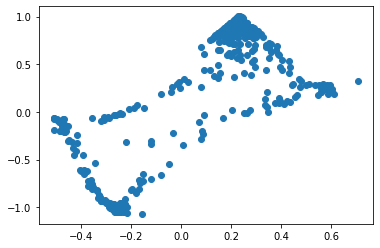

[GAN training] Epoch 23799/60000:
        Acc. real: 0.6639999747276306
        Acc. fake: 0.46000000834465027


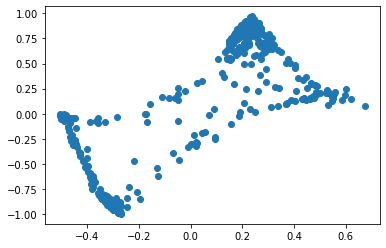

[GAN training] Epoch 23899/60000:
        Acc. real: 0.6399999856948853
        Acc. fake: 0.4740000069141388


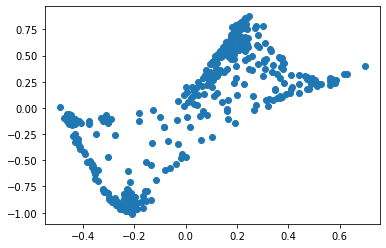

[GAN training] Epoch 23999/60000:
        Acc. real: 0.6119999885559082
        Acc. fake: 0.4560000002384186


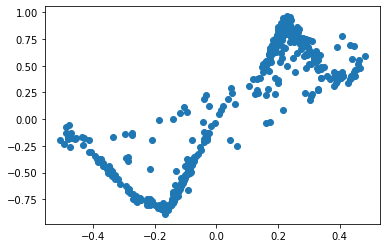

[GAN training] Epoch 24099/60000:
        Acc. real: 0.7799999713897705
        Acc. fake: 0.28600001335144043


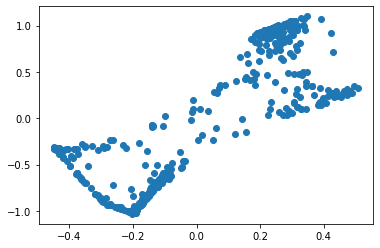

[GAN training] Epoch 24199/60000:
        Acc. real: 0.5379999876022339
        Acc. fake: 0.5720000267028809


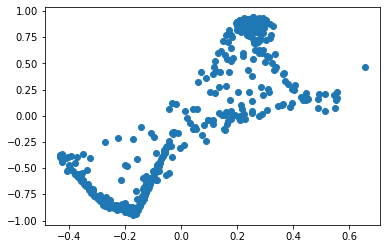

[GAN training] Epoch 24299/60000:
        Acc. real: 0.5099999904632568
        Acc. fake: 0.6200000047683716


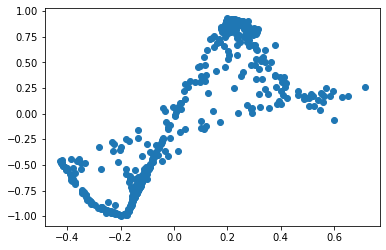

[GAN training] Epoch 24399/60000:
        Acc. real: 0.46000000834465027
        Acc. fake: 0.7680000066757202


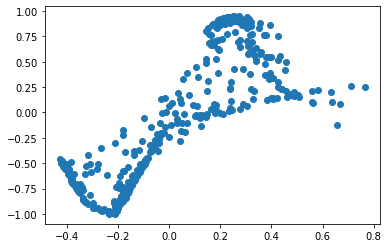

[GAN training] Epoch 24499/60000:
        Acc. real: 0.6420000195503235
        Acc. fake: 0.44600000977516174


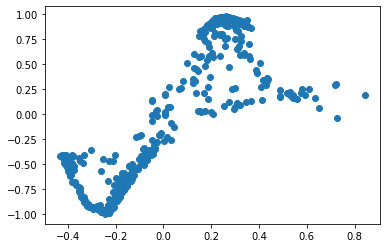

[GAN training] Epoch 24599/60000:
        Acc. real: 0.4580000042915344
        Acc. fake: 0.6620000004768372


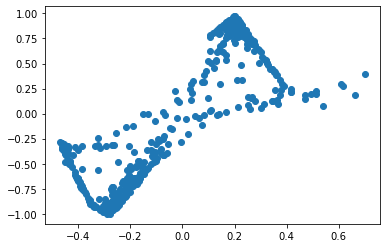

[GAN training] Epoch 24699/60000:
        Acc. real: 0.4819999933242798
        Acc. fake: 0.5699999928474426


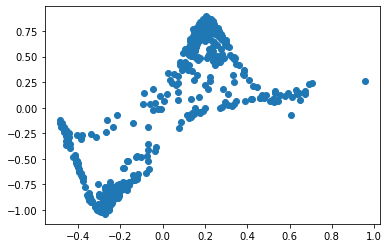

[GAN training] Epoch 24799/60000:
        Acc. real: 0.40400001406669617
        Acc. fake: 0.699999988079071


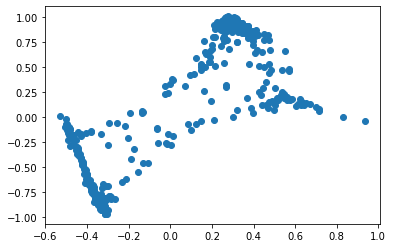

[GAN training] Epoch 24899/60000:
        Acc. real: 0.5320000052452087
        Acc. fake: 0.5019999742507935


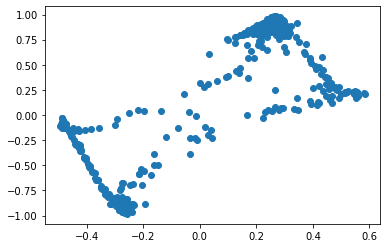

[GAN training] Epoch 24999/60000:
        Acc. real: 0.6039999723434448
        Acc. fake: 0.4560000002384186


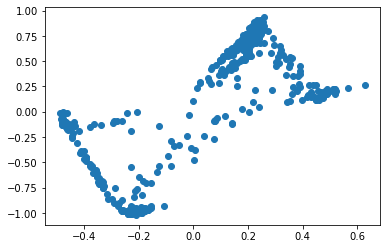

[GAN training] Epoch 25099/60000:
        Acc. real: 0.4659999907016754
        Acc. fake: 0.4959999918937683


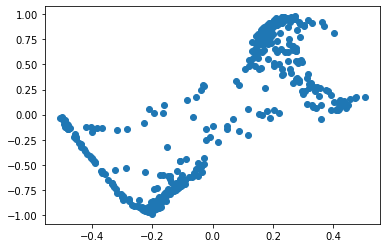

[GAN training] Epoch 25199/60000:
        Acc. real: 0.5619999766349792
        Acc. fake: 0.4880000054836273


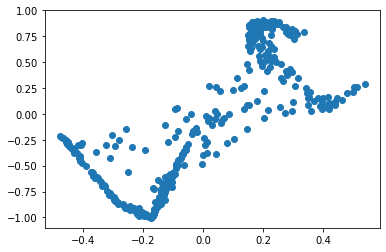

[GAN training] Epoch 25299/60000:
        Acc. real: 0.7559999823570251
        Acc. fake: 0.3100000023841858


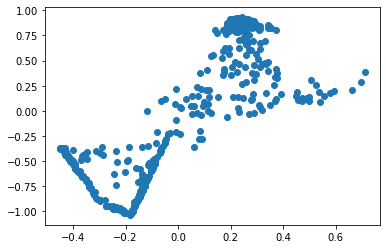

[GAN training] Epoch 25399/60000:
        Acc. real: 0.6299999952316284
        Acc. fake: 0.47999998927116394


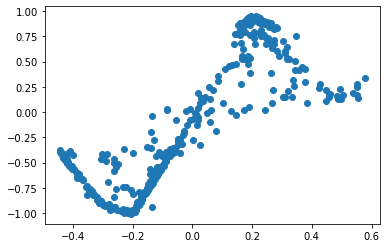

[GAN training] Epoch 25499/60000:
        Acc. real: 0.6340000033378601
        Acc. fake: 0.47600001096725464


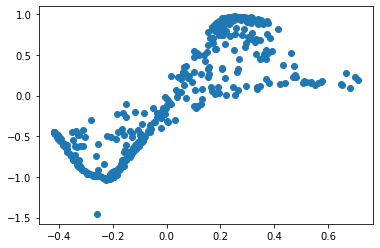

[GAN training] Epoch 25599/60000:
        Acc. real: 0.41600000858306885
        Acc. fake: 0.6919999718666077


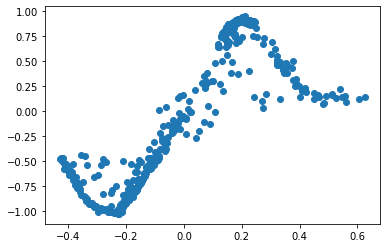

[GAN training] Epoch 25699/60000:
        Acc. real: 0.4300000071525574
        Acc. fake: 0.7279999852180481


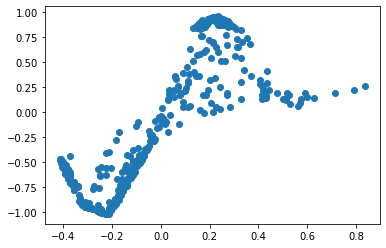

[GAN training] Epoch 25799/60000:
        Acc. real: 0.41999998688697815
        Acc. fake: 0.6439999938011169


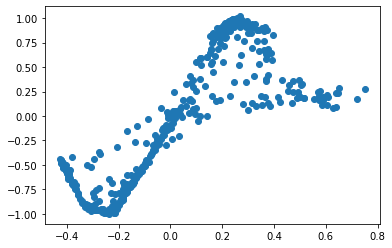

[GAN training] Epoch 25899/60000:
        Acc. real: 0.4099999964237213
        Acc. fake: 0.656000018119812


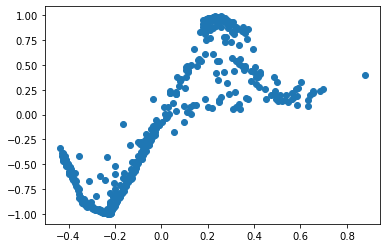

[GAN training] Epoch 25999/60000:
        Acc. real: 0.41999998688697815
        Acc. fake: 0.6679999828338623


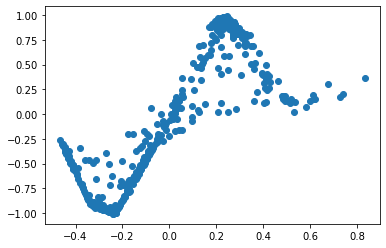

[GAN training] Epoch 26099/60000:
        Acc. real: 0.40400001406669617
        Acc. fake: 0.6499999761581421


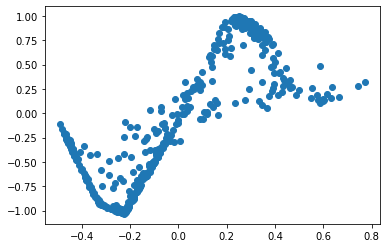

[GAN training] Epoch 26199/60000:
        Acc. real: 0.7059999704360962
        Acc. fake: 0.3499999940395355


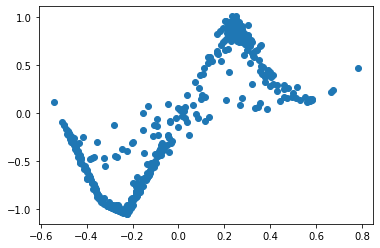

[GAN training] Epoch 26299/60000:
        Acc. real: 0.40799999237060547
        Acc. fake: 0.593999981880188


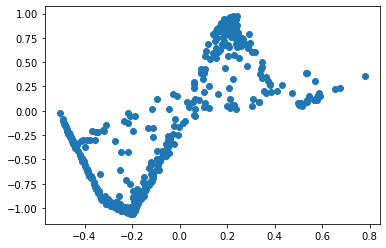

[GAN training] Epoch 26399/60000:
        Acc. real: 0.40400001406669617
        Acc. fake: 0.6959999799728394


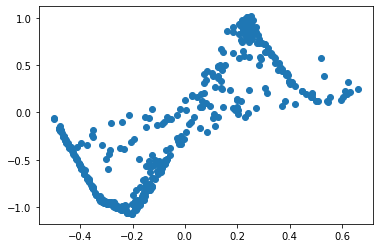

[GAN training] Epoch 26499/60000:
        Acc. real: 0.3659999966621399
        Acc. fake: 0.7319999933242798


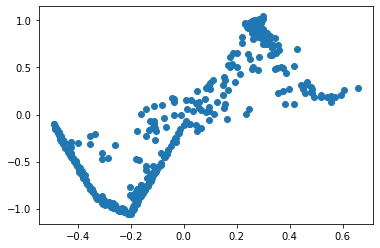

[GAN training] Epoch 26599/60000:
        Acc. real: 0.35199999809265137
        Acc. fake: 0.7519999742507935


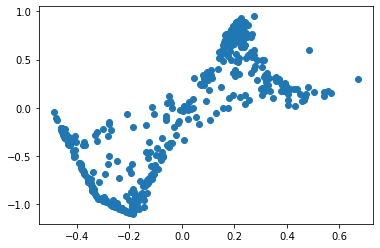

[GAN training] Epoch 26699/60000:
        Acc. real: 0.32199999690055847
        Acc. fake: 0.7440000176429749


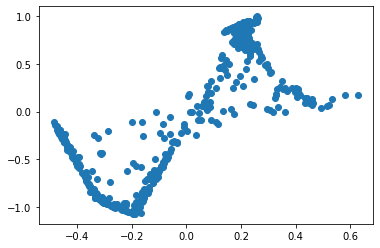

[GAN training] Epoch 26799/60000:
        Acc. real: 0.3179999887943268
        Acc. fake: 0.8159999847412109


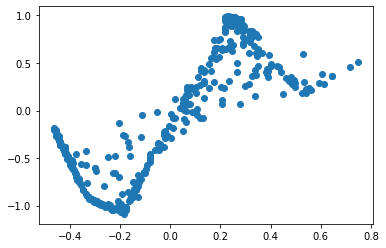

[GAN training] Epoch 26899/60000:
        Acc. real: 0.30399999022483826
        Acc. fake: 0.7720000147819519


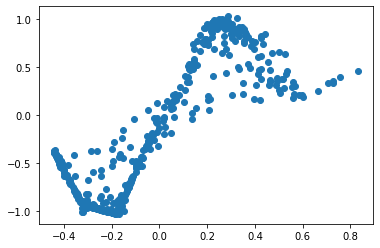

[GAN training] Epoch 26999/60000:
        Acc. real: 0.14800000190734863
        Acc. fake: 0.9020000100135803


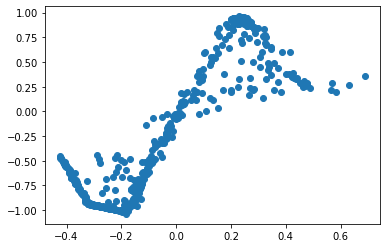

[GAN training] Epoch 27099/60000:
        Acc. real: 0.5640000104904175
        Acc. fake: 0.4860000014305115


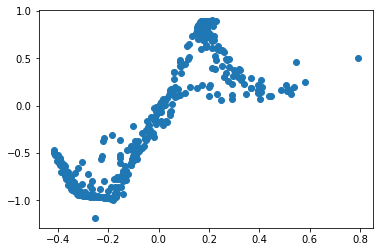

[GAN training] Epoch 27199/60000:
        Acc. real: 0.25200000405311584
        Acc. fake: 0.8640000224113464


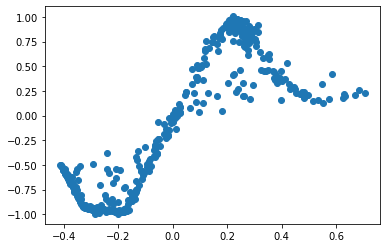

[GAN training] Epoch 27299/60000:
        Acc. real: 0.41200000047683716
        Acc. fake: 0.6679999828338623


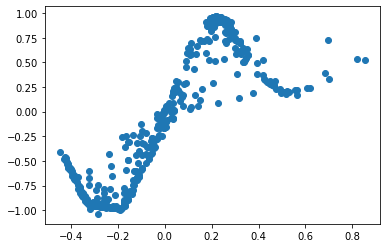

[GAN training] Epoch 27399/60000:
        Acc. real: 0.5740000009536743
        Acc. fake: 0.4779999852180481


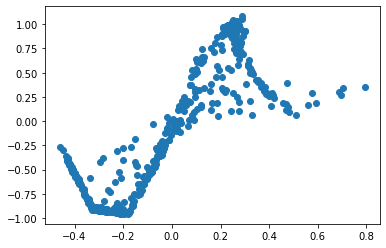

[GAN training] Epoch 27499/60000:
        Acc. real: 0.47600001096725464
        Acc. fake: 0.6259999871253967


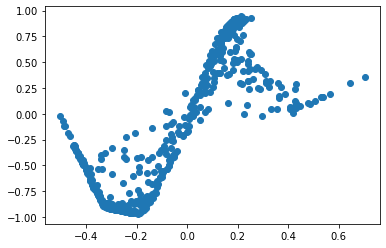

[GAN training] Epoch 27599/60000:
        Acc. real: 0.5680000185966492
        Acc. fake: 0.4959999918937683


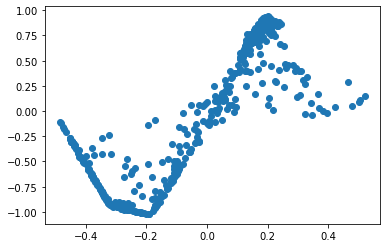

[GAN training] Epoch 27699/60000:
        Acc. real: 0.593999981880188
        Acc. fake: 0.4959999918937683


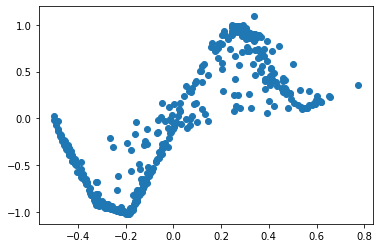

[GAN training] Epoch 27799/60000:
        Acc. real: 0.5360000133514404
        Acc. fake: 0.4819999933242798


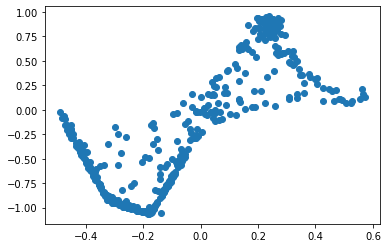

[GAN training] Epoch 27899/60000:
        Acc. real: 0.4779999852180481
        Acc. fake: 0.6019999980926514


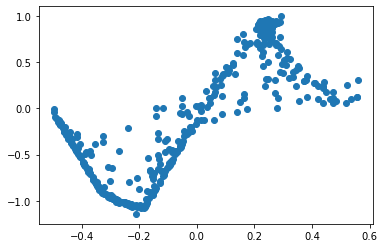

[GAN training] Epoch 27999/60000:
        Acc. real: 0.5460000038146973
        Acc. fake: 0.5479999780654907


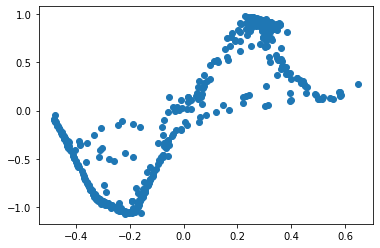

[GAN training] Epoch 28099/60000:
        Acc. real: 0.4819999933242798
        Acc. fake: 0.578000009059906


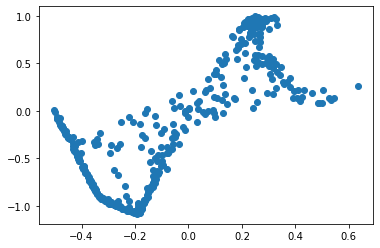

[GAN training] Epoch 28199/60000:
        Acc. real: 0.6240000128746033
        Acc. fake: 0.4099999964237213


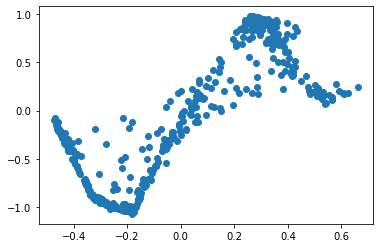

[GAN training] Epoch 28299/60000:
        Acc. real: 0.4959999918937683
        Acc. fake: 0.578000009059906


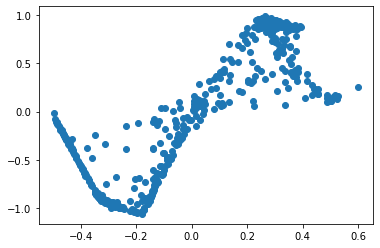

[GAN training] Epoch 28399/60000:
        Acc. real: 0.49399998784065247
        Acc. fake: 0.6039999723434448


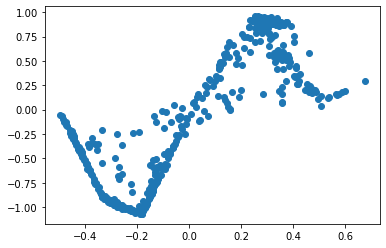

[GAN training] Epoch 28499/60000:
        Acc. real: 0.7120000123977661
        Acc. fake: 0.3580000102519989


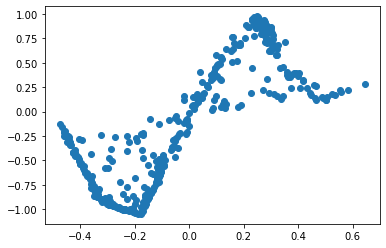

[GAN training] Epoch 28599/60000:
        Acc. real: 0.6679999828338623
        Acc. fake: 0.36399999260902405


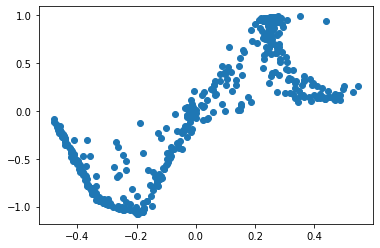

[GAN training] Epoch 28699/60000:
        Acc. real: 0.41999998688697815
        Acc. fake: 0.6600000262260437


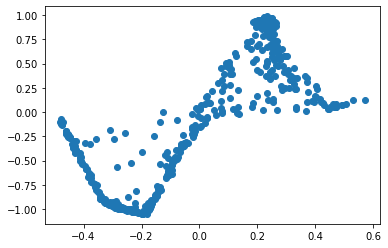

[GAN training] Epoch 28799/60000:
        Acc. real: 0.5059999823570251
        Acc. fake: 0.5199999809265137


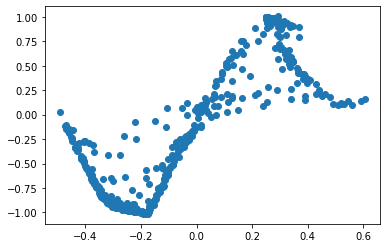

[GAN training] Epoch 28899/60000:
        Acc. real: 0.7799999713897705
        Acc. fake: 0.3400000035762787


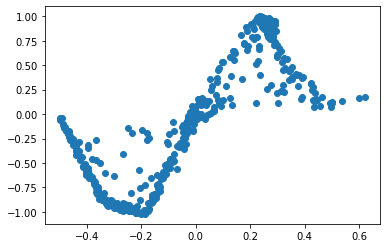

[GAN training] Epoch 28999/60000:
        Acc. real: 0.5440000295639038
        Acc. fake: 0.5920000076293945


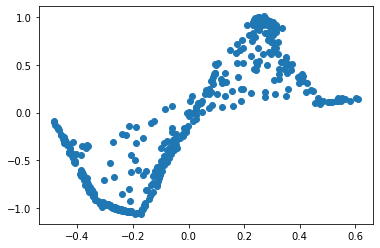

[GAN training] Epoch 29099/60000:
        Acc. real: 0.4300000071525574
        Acc. fake: 0.6100000143051147


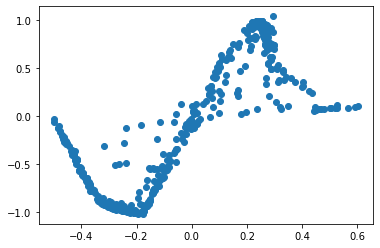

[GAN training] Epoch 29199/60000:
        Acc. real: 0.4779999852180481
        Acc. fake: 0.6159999966621399


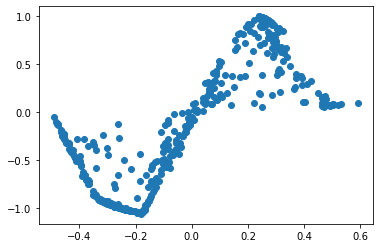

[GAN training] Epoch 29299/60000:
        Acc. real: 0.4560000002384186
        Acc. fake: 0.6359999775886536


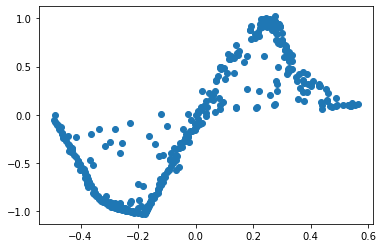

[GAN training] Epoch 29399/60000:
        Acc. real: 0.5979999899864197
        Acc. fake: 0.3779999911785126


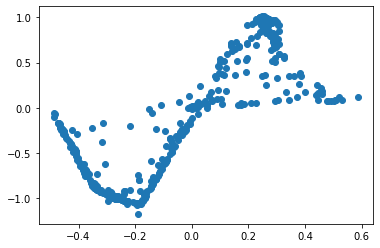

[GAN training] Epoch 29499/60000:
        Acc. real: 0.6700000166893005
        Acc. fake: 0.37400001287460327


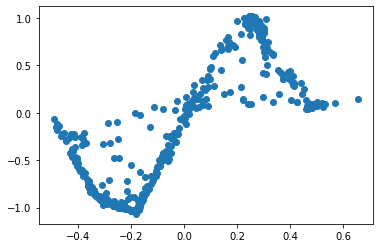

[GAN training] Epoch 29599/60000:
        Acc. real: 0.5400000214576721
        Acc. fake: 0.5400000214576721


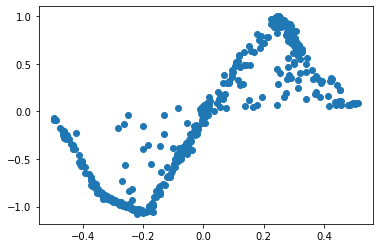

[GAN training] Epoch 29699/60000:
        Acc. real: 0.6299999952316284
        Acc. fake: 0.3919999897480011


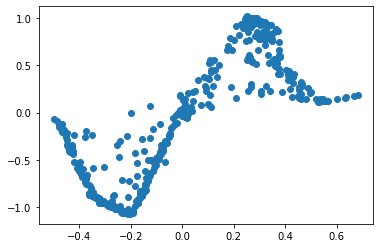

[GAN training] Epoch 29799/60000:
        Acc. real: 0.47999998927116394
        Acc. fake: 0.628000020980835


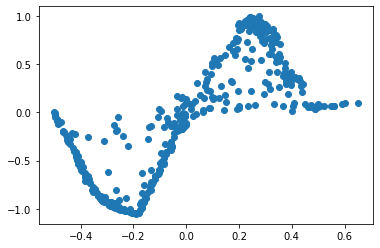

[GAN training] Epoch 29899/60000:
        Acc. real: 0.7099999785423279
        Acc. fake: 0.39800000190734863


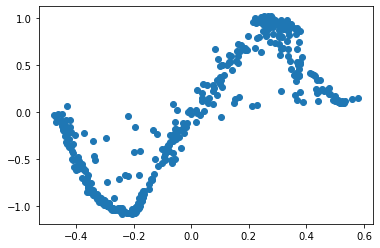

[GAN training] Epoch 29999/60000:
        Acc. real: 0.515999972820282
        Acc. fake: 0.4699999988079071


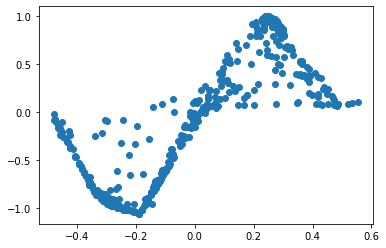

[GAN training] Epoch 30099/60000:
        Acc. real: 0.5199999809265137
        Acc. fake: 0.4880000054836273


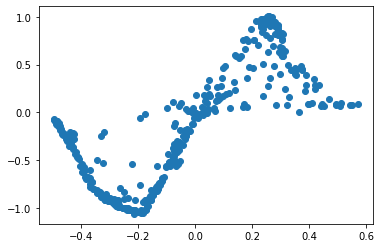

[GAN training] Epoch 30199/60000:
        Acc. real: 0.4519999921321869
        Acc. fake: 0.5979999899864197


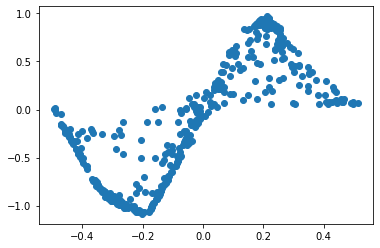

[GAN training] Epoch 30299/60000:
        Acc. real: 0.4180000126361847
        Acc. fake: 0.6600000262260437


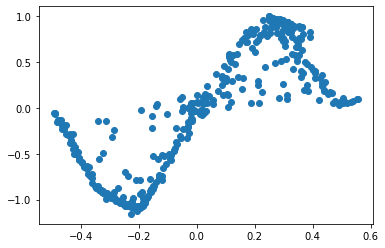

[GAN training] Epoch 30399/60000:
        Acc. real: 0.621999979019165
        Acc. fake: 0.38199999928474426


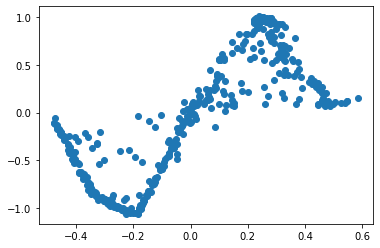

[GAN training] Epoch 30499/60000:
        Acc. real: 0.49000000953674316
        Acc. fake: 0.5199999809265137


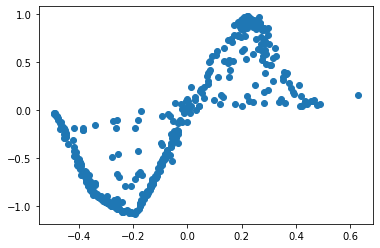

[GAN training] Epoch 30599/60000:
        Acc. real: 0.7979999780654907
        Acc. fake: 0.2919999957084656


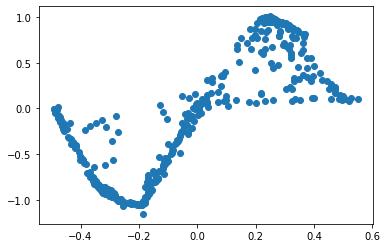

[GAN training] Epoch 30699/60000:
        Acc. real: 0.5339999794960022
        Acc. fake: 0.5199999809265137


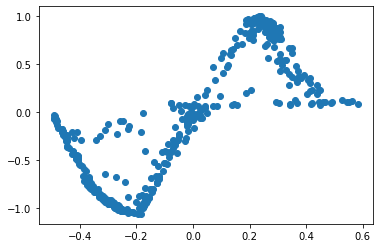

[GAN training] Epoch 30799/60000:
        Acc. real: 0.5379999876022339
        Acc. fake: 0.5460000038146973


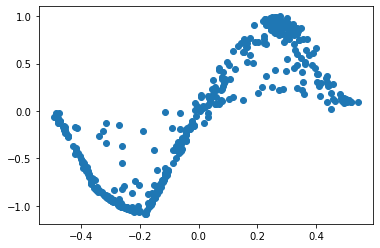

[GAN training] Epoch 30899/60000:
        Acc. real: 0.671999990940094
        Acc. fake: 0.3199999928474426


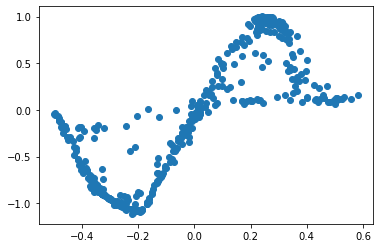

[GAN training] Epoch 30999/60000:
        Acc. real: 0.5180000066757202
        Acc. fake: 0.6140000224113464


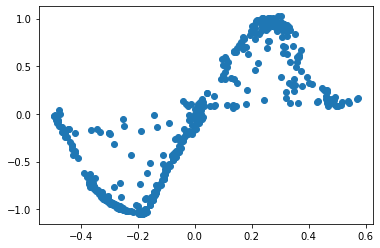

[GAN training] Epoch 31099/60000:
        Acc. real: 0.5640000104904175
        Acc. fake: 0.5920000076293945


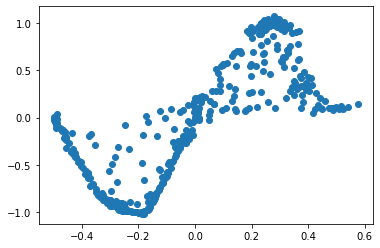

[GAN training] Epoch 31199/60000:
        Acc. real: 0.4880000054836273
        Acc. fake: 0.6000000238418579


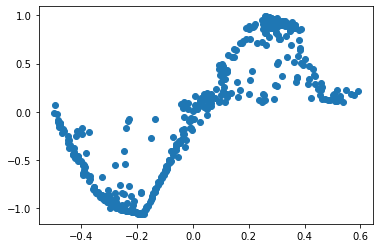

[GAN training] Epoch 31299/60000:
        Acc. real: 0.5740000009536743
        Acc. fake: 0.4959999918937683


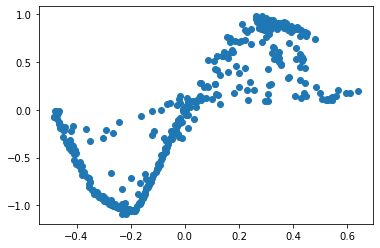

[GAN training] Epoch 31399/60000:
        Acc. real: 0.6679999828338623
        Acc. fake: 0.43799999356269836


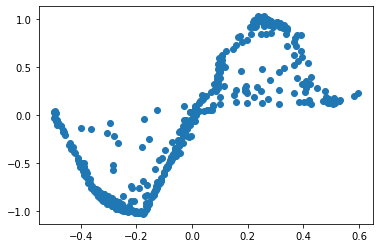

[GAN training] Epoch 31499/60000:
        Acc. real: 0.734000027179718
        Acc. fake: 0.3160000145435333


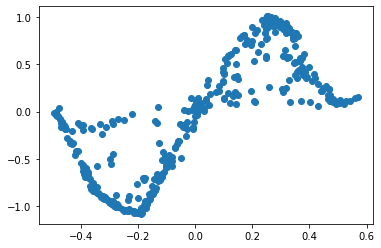

[GAN training] Epoch 31599/60000:
        Acc. real: 0.6620000004768372
        Acc. fake: 0.46399998664855957


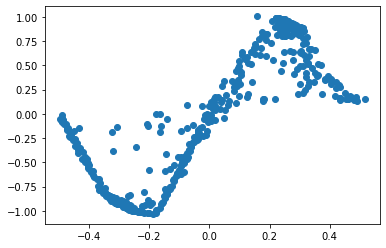

[GAN training] Epoch 31699/60000:
        Acc. real: 0.6840000152587891
        Acc. fake: 0.3720000088214874


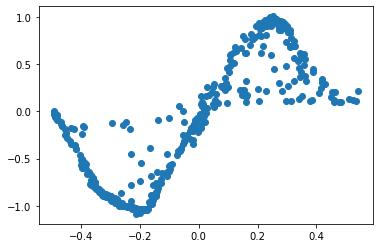

[GAN training] Epoch 31799/60000:
        Acc. real: 0.5799999833106995
        Acc. fake: 0.4620000123977661


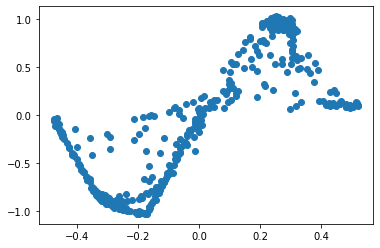

[GAN training] Epoch 31899/60000:
        Acc. real: 0.5419999957084656
        Acc. fake: 0.550000011920929


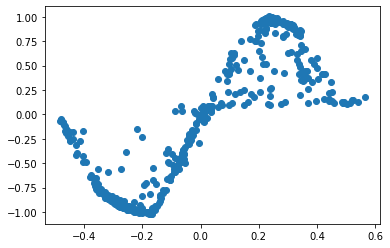

[GAN training] Epoch 31999/60000:
        Acc. real: 0.5720000267028809
        Acc. fake: 0.44200000166893005


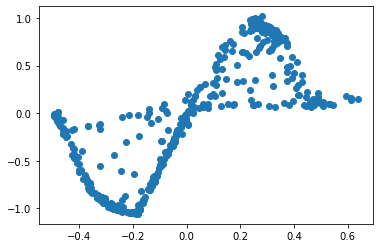

[GAN training] Epoch 32099/60000:
        Acc. real: 0.7319999933242798
        Acc. fake: 0.25


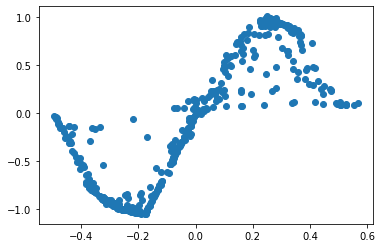

[GAN training] Epoch 32199/60000:
        Acc. real: 0.5640000104904175
        Acc. fake: 0.5440000295639038


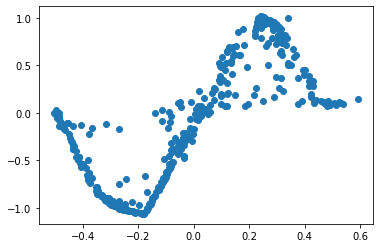

[GAN training] Epoch 32299/60000:
        Acc. real: 0.6119999885559082
        Acc. fake: 0.3619999885559082


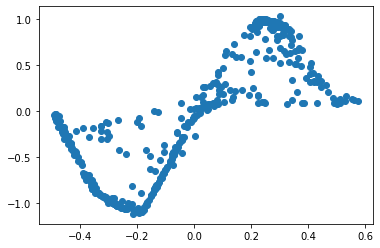

[GAN training] Epoch 32399/60000:
        Acc. real: 0.6980000138282776
        Acc. fake: 0.31200000643730164


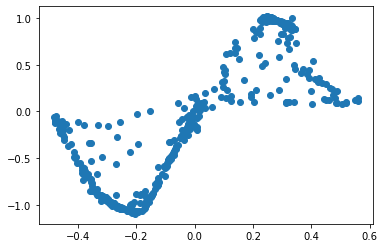

[GAN training] Epoch 32499/60000:
        Acc. real: 0.421999990940094
        Acc. fake: 0.6079999804496765


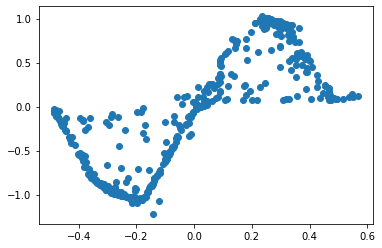

[GAN training] Epoch 32599/60000:
        Acc. real: 0.5519999861717224
        Acc. fake: 0.5019999742507935


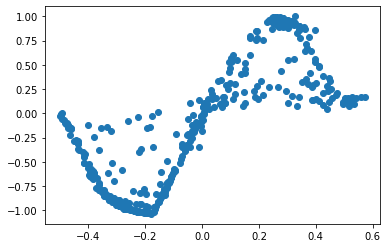

[GAN training] Epoch 32699/60000:
        Acc. real: 0.6740000247955322
        Acc. fake: 0.3400000035762787


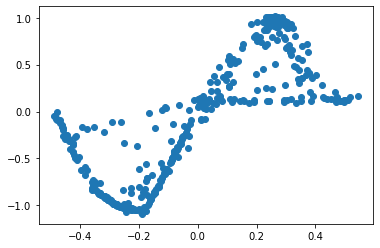

[GAN training] Epoch 32799/60000:
        Acc. real: 0.6079999804496765
        Acc. fake: 0.5


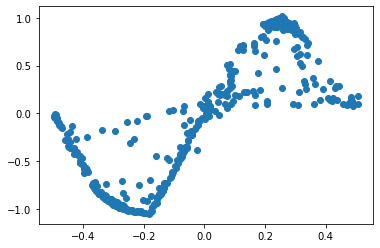

[GAN training] Epoch 32899/60000:
        Acc. real: 0.5460000038146973
        Acc. fake: 0.5139999985694885


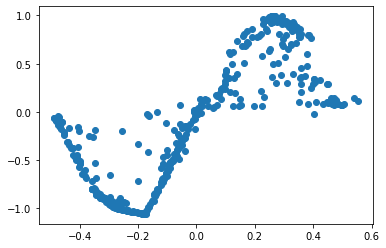

[GAN training] Epoch 32999/60000:
        Acc. real: 0.6159999966621399
        Acc. fake: 0.47999998927116394


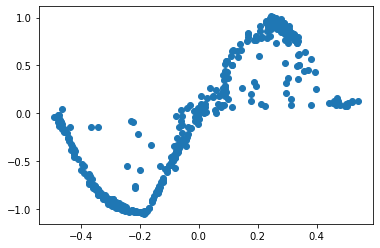

[GAN training] Epoch 33099/60000:
        Acc. real: 0.5479999780654907
        Acc. fake: 0.492000013589859


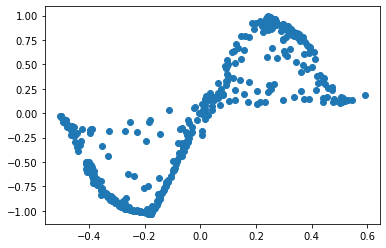

[GAN training] Epoch 33199/60000:
        Acc. real: 0.4099999964237213
        Acc. fake: 0.6100000143051147


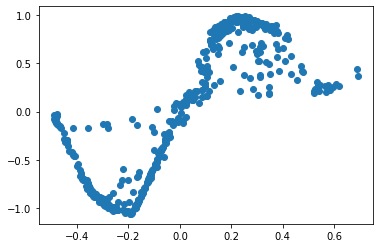

[GAN training] Epoch 33299/60000:
        Acc. real: 0.5059999823570251
        Acc. fake: 0.5519999861717224


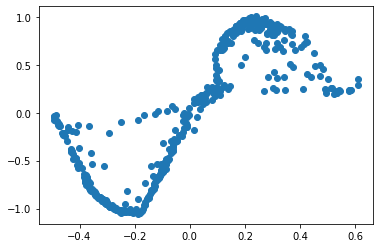

[GAN training] Epoch 33399/60000:
        Acc. real: 0.5339999794960022
        Acc. fake: 0.5040000081062317


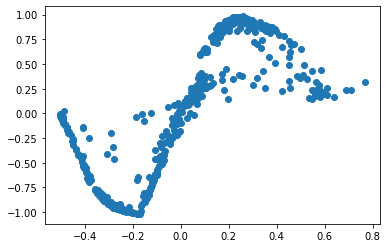

[GAN training] Epoch 33499/60000:
        Acc. real: 0.4740000069141388
        Acc. fake: 0.5220000147819519


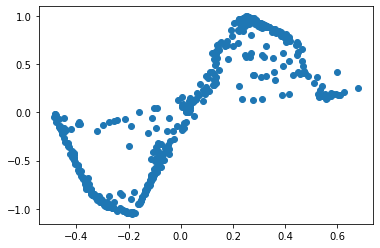

[GAN training] Epoch 33599/60000:
        Acc. real: 0.5019999742507935
        Acc. fake: 0.4959999918937683


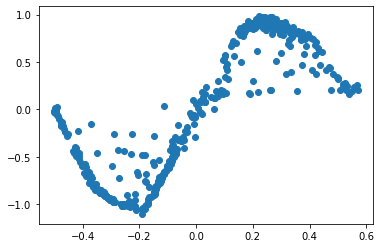

[GAN training] Epoch 33699/60000:
        Acc. real: 0.4959999918937683
        Acc. fake: 0.656000018119812


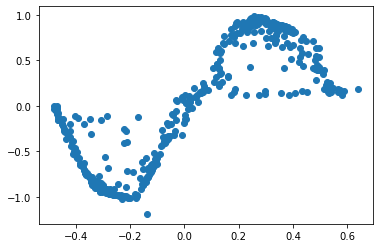

[GAN training] Epoch 33799/60000:
        Acc. real: 0.4819999933242798
        Acc. fake: 0.550000011920929


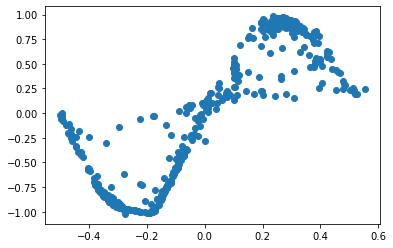

2021-09-24 23:42:32.337281: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


[GAN training] Epoch 33899/60000:
        Acc. real: 0.7720000147819519
        Acc. fake: 0.2840000092983246


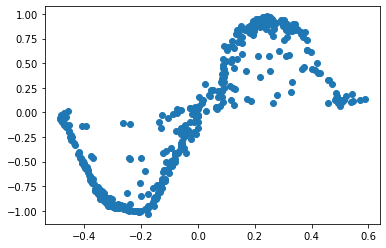

[GAN training] Epoch 33999/60000:
        Acc. real: 0.6480000019073486
        Acc. fake: 0.39800000190734863


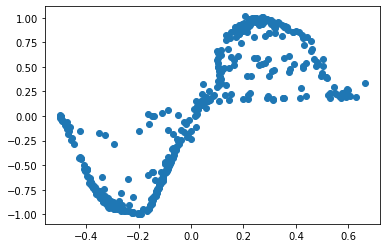

[GAN training] Epoch 34099/60000:
        Acc. real: 0.46799999475479126
        Acc. fake: 0.6179999709129333


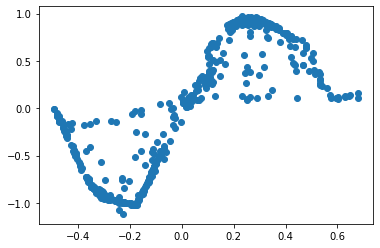

[GAN training] Epoch 34199/60000:
        Acc. real: 0.5519999861717224
        Acc. fake: 0.5820000171661377


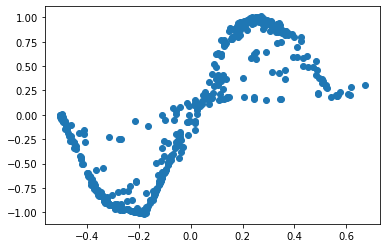

[GAN training] Epoch 34299/60000:
        Acc. real: 0.765999972820282
        Acc. fake: 0.2919999957084656


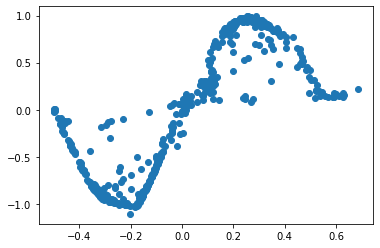

[GAN training] Epoch 34399/60000:
        Acc. real: 0.3240000009536743
        Acc. fake: 0.7440000176429749


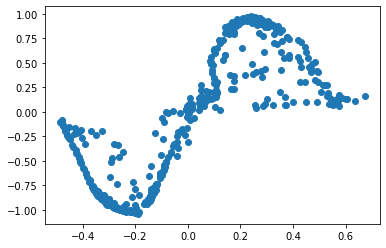

[GAN training] Epoch 34499/60000:
        Acc. real: 0.5220000147819519
        Acc. fake: 0.5080000162124634


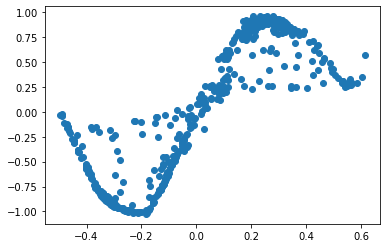

[GAN training] Epoch 34599/60000:
        Acc. real: 0.7360000014305115
        Acc. fake: 0.5040000081062317


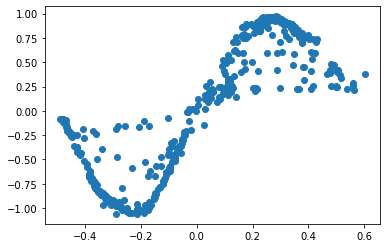

[GAN training] Epoch 34699/60000:
        Acc. real: 0.765999972820282
        Acc. fake: 0.28999999165534973


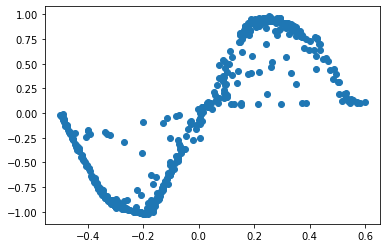

[GAN training] Epoch 34799/60000:
        Acc. real: 0.5400000214576721
        Acc. fake: 0.5400000214576721


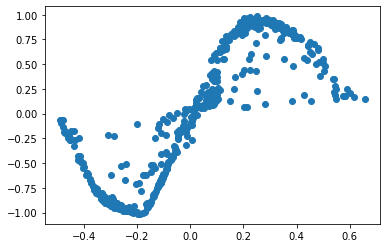

[GAN training] Epoch 34899/60000:
        Acc. real: 0.4480000138282776
        Acc. fake: 0.5440000295639038


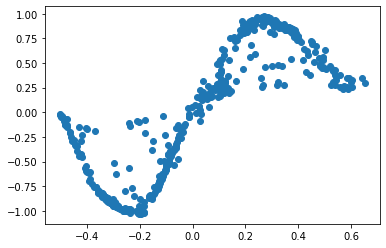

[GAN training] Epoch 34999/60000:
        Acc. real: 0.6320000290870667
        Acc. fake: 0.5220000147819519


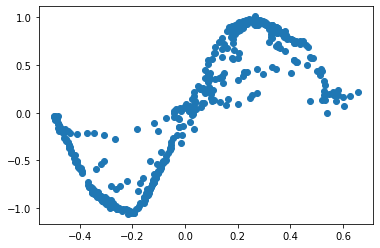

[GAN training] Epoch 35099/60000:
        Acc. real: 0.5799999833106995
        Acc. fake: 0.44600000977516174


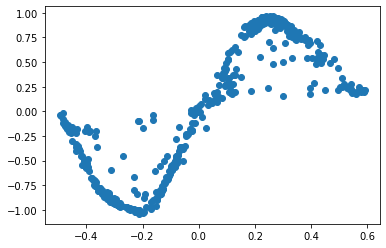

[GAN training] Epoch 35199/60000:
        Acc. real: 0.6259999871253967
        Acc. fake: 0.5519999861717224


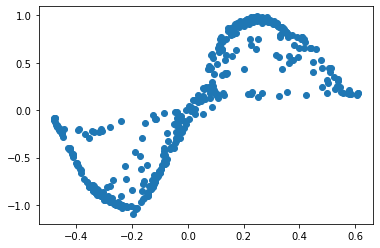

[GAN training] Epoch 35299/60000:
        Acc. real: 0.6159999966621399
        Acc. fake: 0.47600001096725464


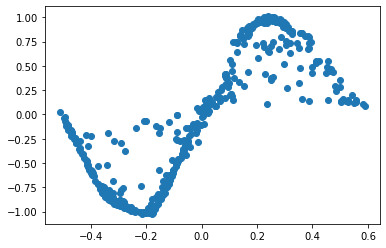

[GAN training] Epoch 35399/60000:
        Acc. real: 0.6359999775886536
        Acc. fake: 0.5180000066757202


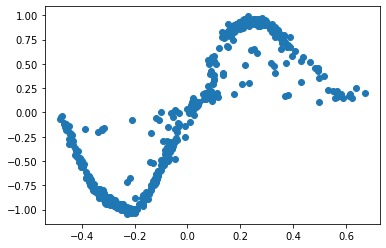

[GAN training] Epoch 35499/60000:
        Acc. real: 0.6600000262260437
        Acc. fake: 0.43799999356269836


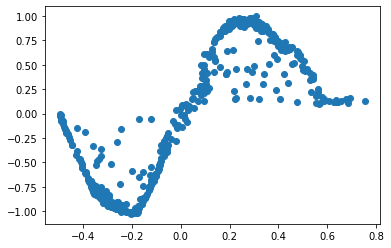

[GAN training] Epoch 35599/60000:
        Acc. real: 0.6759999990463257
        Acc. fake: 0.5139999985694885


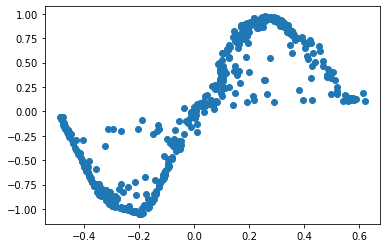

[GAN training] Epoch 35699/60000:
        Acc. real: 0.6240000128746033
        Acc. fake: 0.5099999904632568


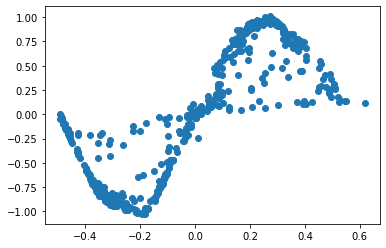

[GAN training] Epoch 35799/60000:
        Acc. real: 0.6399999856948853
        Acc. fake: 0.5339999794960022


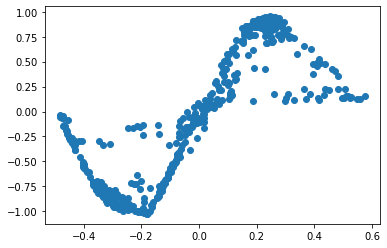

[GAN training] Epoch 35899/60000:
        Acc. real: 0.6320000290870667
        Acc. fake: 0.5559999942779541


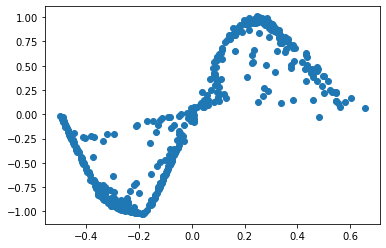

[GAN training] Epoch 35999/60000:
        Acc. real: 0.6420000195503235
        Acc. fake: 0.49000000953674316


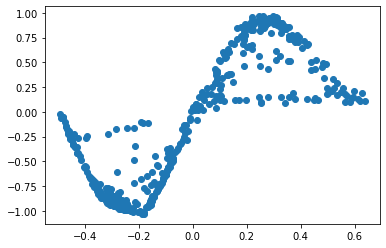

[GAN training] Epoch 36099/60000:
        Acc. real: 0.5540000200271606
        Acc. fake: 0.6259999871253967


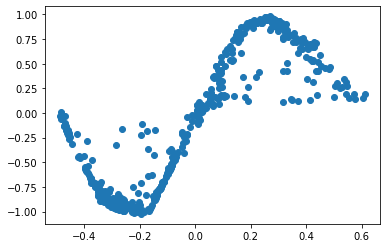

[GAN training] Epoch 36199/60000:
        Acc. real: 0.4699999988079071
        Acc. fake: 0.5740000009536743


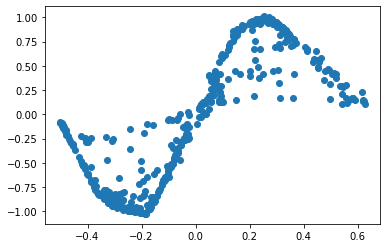

[GAN training] Epoch 36299/60000:
        Acc. real: 0.5899999737739563
        Acc. fake: 0.5600000023841858


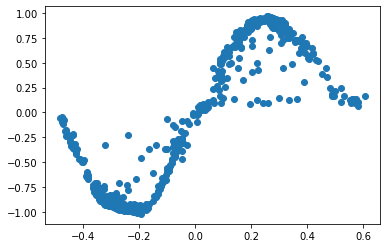

[GAN training] Epoch 36399/60000:
        Acc. real: 0.621999979019165
        Acc. fake: 0.5320000052452087


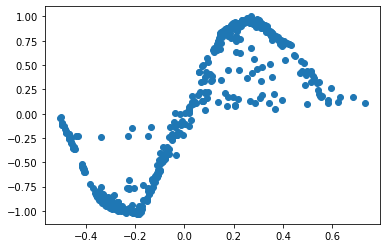

[GAN training] Epoch 36499/60000:
        Acc. real: 0.6840000152587891
        Acc. fake: 0.41200000047683716


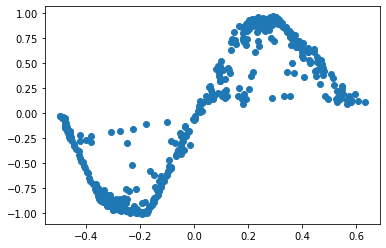

[GAN training] Epoch 36599/60000:
        Acc. real: 0.7080000042915344
        Acc. fake: 0.4059999883174896


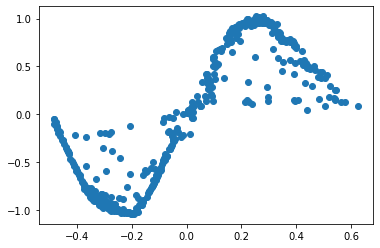

[GAN training] Epoch 36699/60000:
        Acc. real: 0.6159999966621399
        Acc. fake: 0.5799999833106995


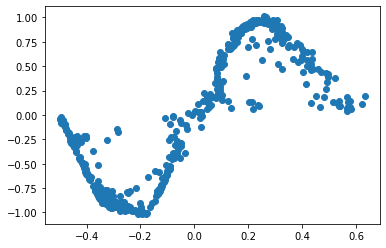

[GAN training] Epoch 36799/60000:
        Acc. real: 0.6140000224113464
        Acc. fake: 0.5040000081062317


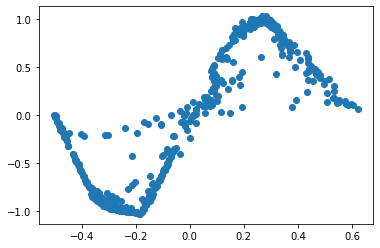

[GAN training] Epoch 36899/60000:
        Acc. real: 0.593999981880188
        Acc. fake: 0.5120000243186951


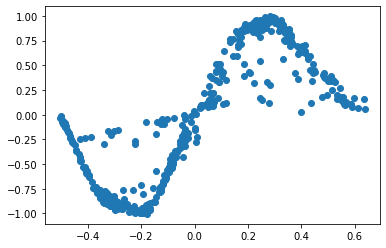

[GAN training] Epoch 36999/60000:
        Acc. real: 0.5379999876022339
        Acc. fake: 0.5759999752044678


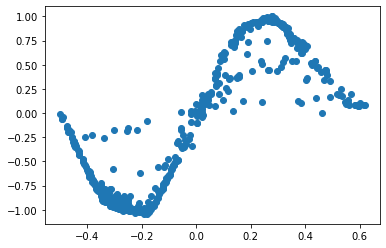

[GAN training] Epoch 37099/60000:
        Acc. real: 0.5879999995231628
        Acc. fake: 0.5540000200271606


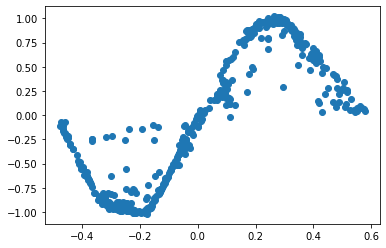

[GAN training] Epoch 37199/60000:
        Acc. real: 0.6899999976158142
        Acc. fake: 0.4740000069141388


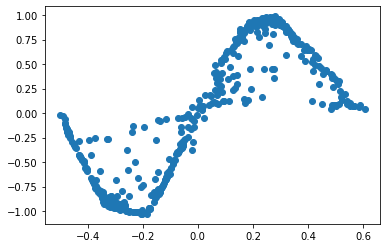

[GAN training] Epoch 37299/60000:
        Acc. real: 0.7239999771118164
        Acc. fake: 0.36800000071525574


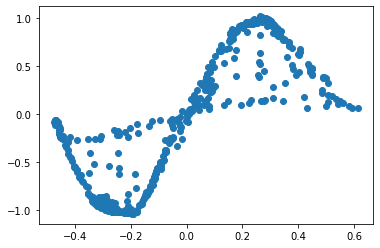

[GAN training] Epoch 37399/60000:
        Acc. real: 0.4480000138282776
        Acc. fake: 0.6179999709129333


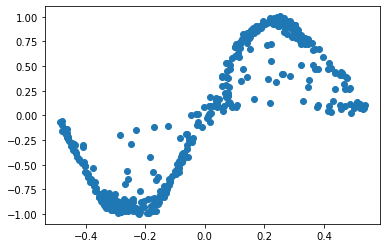

[GAN training] Epoch 37499/60000:
        Acc. real: 0.6140000224113464
        Acc. fake: 0.5080000162124634


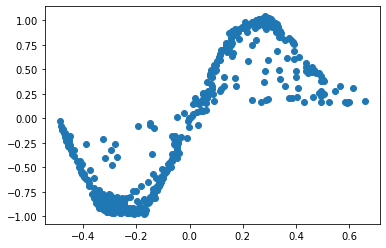

[GAN training] Epoch 37599/60000:
        Acc. real: 0.7820000052452087
        Acc. fake: 0.3779999911785126


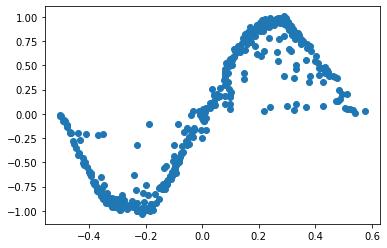

[GAN training] Epoch 37699/60000:
        Acc. real: 0.7639999985694885
        Acc. fake: 0.5239999890327454


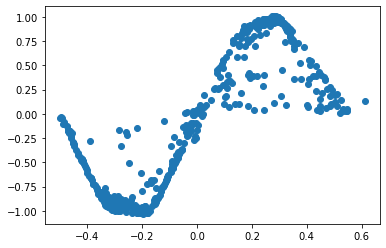

[GAN training] Epoch 37799/60000:
        Acc. real: 0.6520000100135803
        Acc. fake: 0.5080000162124634


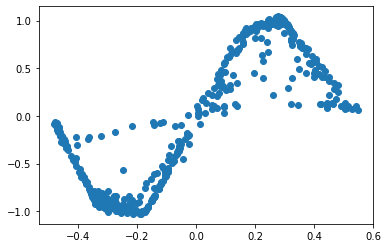

[GAN training] Epoch 37899/60000:
        Acc. real: 0.7400000095367432
        Acc. fake: 0.4779999852180481


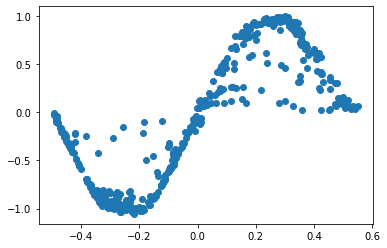

[GAN training] Epoch 37999/60000:
        Acc. real: 0.6940000057220459
        Acc. fake: 0.5260000228881836


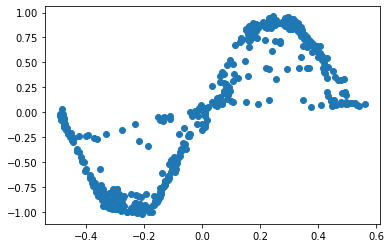

[GAN training] Epoch 38099/60000:
        Acc. real: 0.5540000200271606
        Acc. fake: 0.6859999895095825


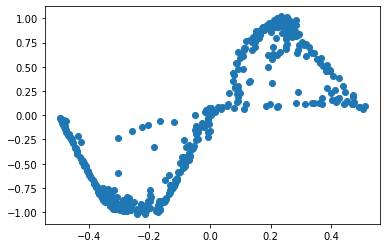

[GAN training] Epoch 38199/60000:
        Acc. real: 0.7260000109672546
        Acc. fake: 0.33799999952316284


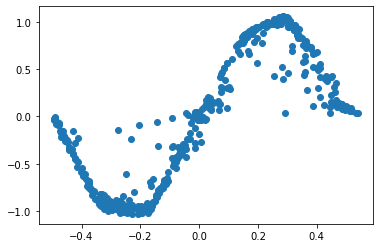

[GAN training] Epoch 38299/60000:
        Acc. real: 0.6079999804496765
        Acc. fake: 0.5740000009536743


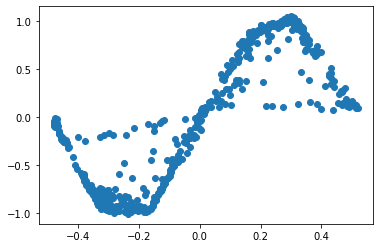

[GAN training] Epoch 38399/60000:
        Acc. real: 0.5640000104904175
        Acc. fake: 0.628000020980835


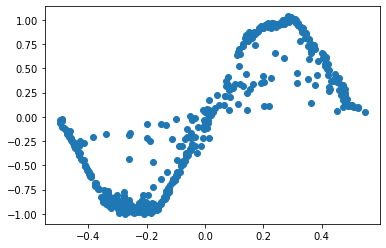

[GAN training] Epoch 38499/60000:
        Acc. real: 0.6740000247955322
        Acc. fake: 0.5979999899864197


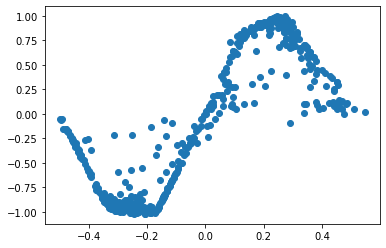

[GAN training] Epoch 38599/60000:
        Acc. real: 0.6019999980926514
        Acc. fake: 0.5199999809265137


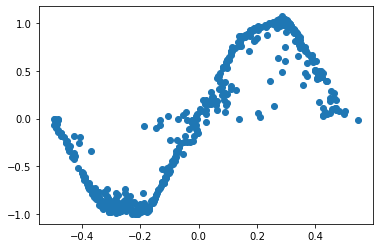

[GAN training] Epoch 38699/60000:
        Acc. real: 0.5640000104904175
        Acc. fake: 0.5759999752044678


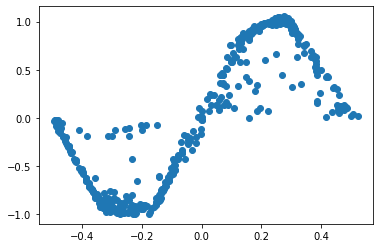

[GAN training] Epoch 38799/60000:
        Acc. real: 0.6259999871253967
        Acc. fake: 0.6060000061988831


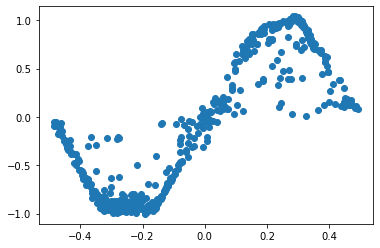

[GAN training] Epoch 38899/60000:
        Acc. real: 0.5839999914169312
        Acc. fake: 0.5440000295639038


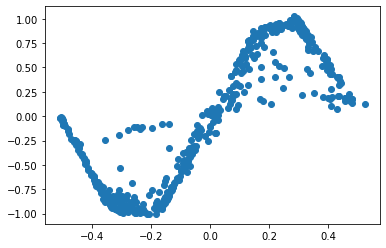

[GAN training] Epoch 38999/60000:
        Acc. real: 0.6060000061988831
        Acc. fake: 0.5699999928474426


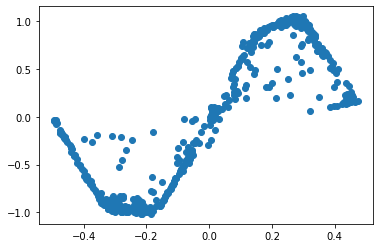

[GAN training] Epoch 39099/60000:
        Acc. real: 0.5759999752044678
        Acc. fake: 0.5799999833106995


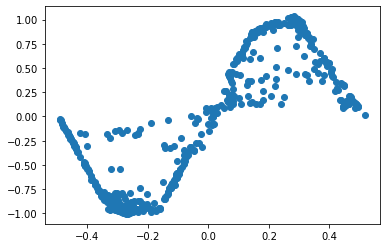

[GAN training] Epoch 39199/60000:
        Acc. real: 0.5600000023841858
        Acc. fake: 0.6520000100135803


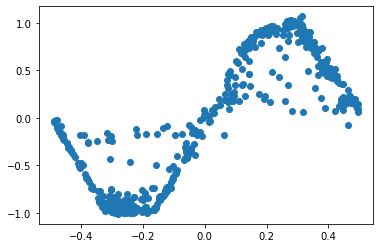

[GAN training] Epoch 39299/60000:
        Acc. real: 0.6039999723434448
        Acc. fake: 0.5519999861717224


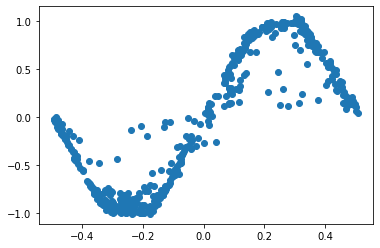

[GAN training] Epoch 39399/60000:
        Acc. real: 0.6259999871253967
        Acc. fake: 0.5659999847412109


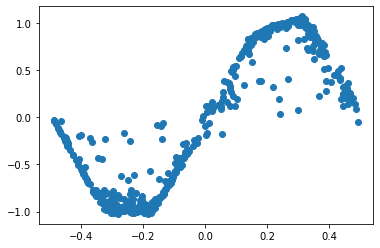

[GAN training] Epoch 39499/60000:
        Acc. real: 0.5720000267028809
        Acc. fake: 0.5899999737739563


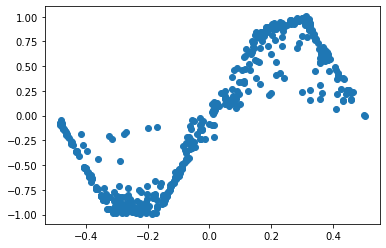

[GAN training] Epoch 39599/60000:
        Acc. real: 0.6539999842643738
        Acc. fake: 0.5139999985694885


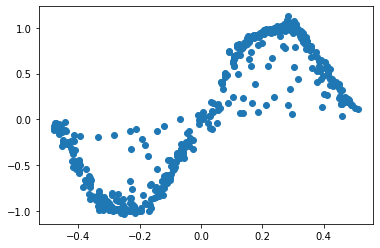

[GAN training] Epoch 39699/60000:
        Acc. real: 0.6060000061988831
        Acc. fake: 0.6539999842643738


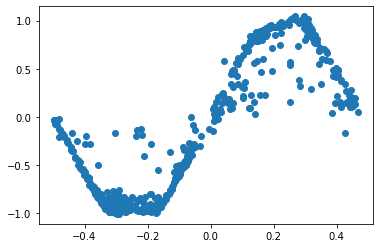

[GAN training] Epoch 39799/60000:
        Acc. real: 0.6859999895095825
        Acc. fake: 0.5180000066757202


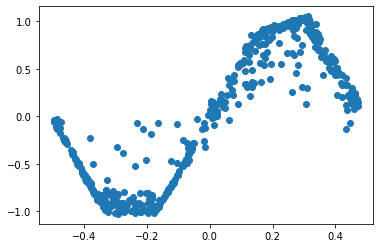

[GAN training] Epoch 39899/60000:
        Acc. real: 0.6159999966621399
        Acc. fake: 0.492000013589859


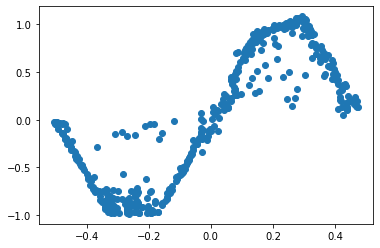

[GAN training] Epoch 39999/60000:
        Acc. real: 0.6380000114440918
        Acc. fake: 0.47200000286102295


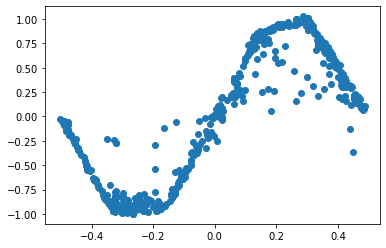

[GAN training] Epoch 40099/60000:
        Acc. real: 0.7139999866485596
        Acc. fake: 0.35199999809265137


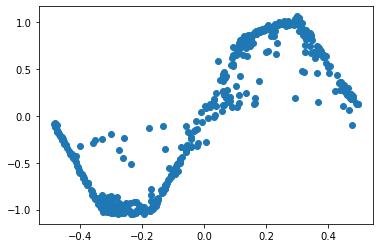

[GAN training] Epoch 40199/60000:
        Acc. real: 0.5419999957084656
        Acc. fake: 0.6039999723434448


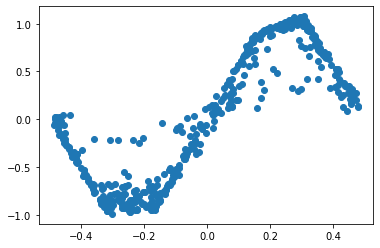

[GAN training] Epoch 40299/60000:
        Acc. real: 0.6439999938011169
        Acc. fake: 0.5


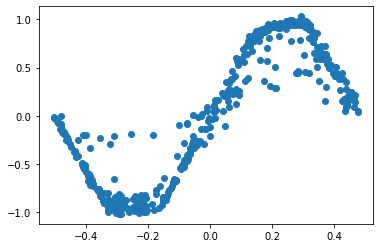

[GAN training] Epoch 40399/60000:
        Acc. real: 0.6499999761581421
        Acc. fake: 0.4779999852180481


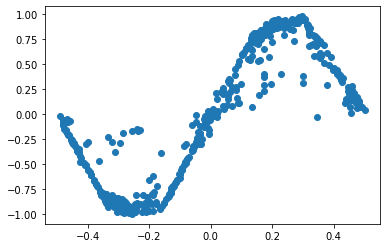

[GAN training] Epoch 40499/60000:
        Acc. real: 0.5180000066757202
        Acc. fake: 0.6399999856948853


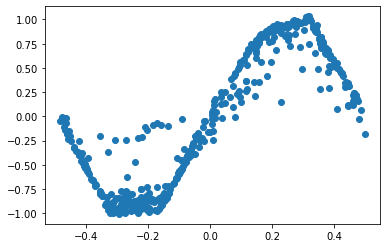

[GAN training] Epoch 40599/60000:
        Acc. real: 0.6700000166893005
        Acc. fake: 0.49799999594688416


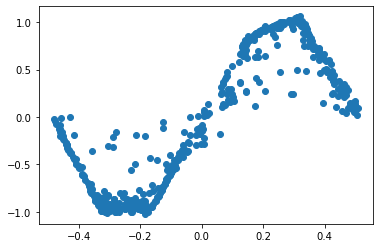

[GAN training] Epoch 40699/60000:
        Acc. real: 0.628000020980835
        Acc. fake: 0.550000011920929


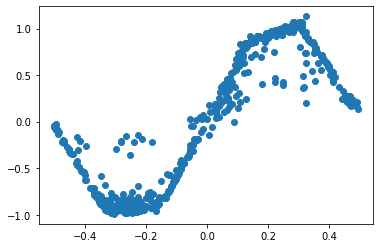

[GAN training] Epoch 40799/60000:
        Acc. real: 0.722000002861023
        Acc. fake: 0.5


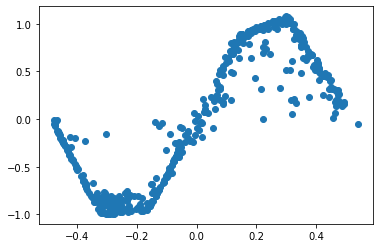

[GAN training] Epoch 40899/60000:
        Acc. real: 0.6079999804496765
        Acc. fake: 0.47999998927116394


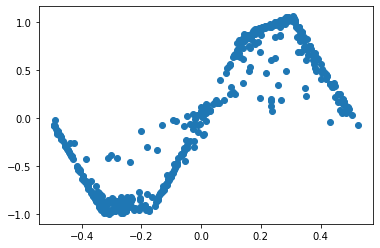

[GAN training] Epoch 40999/60000:
        Acc. real: 0.7099999785423279
        Acc. fake: 0.3880000114440918


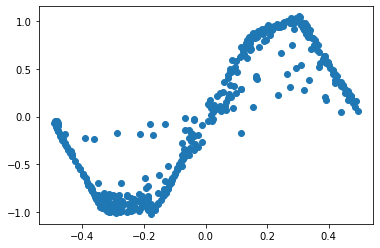

[GAN training] Epoch 41099/60000:
        Acc. real: 0.6620000004768372
        Acc. fake: 0.5299999713897705


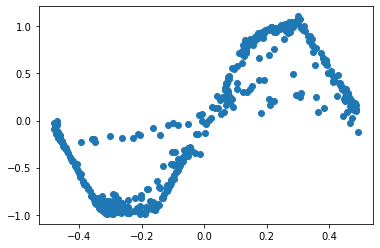

[GAN training] Epoch 41199/60000:
        Acc. real: 0.6240000128746033
        Acc. fake: 0.5019999742507935


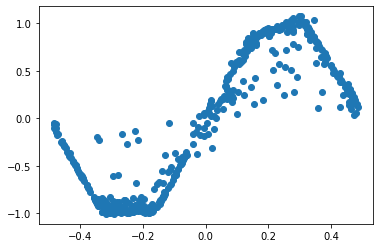

[GAN training] Epoch 41299/60000:
        Acc. real: 0.593999981880188
        Acc. fake: 0.5699999928474426


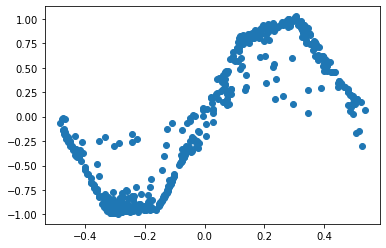

[GAN training] Epoch 41399/60000:
        Acc. real: 0.6399999856948853
        Acc. fake: 0.5080000162124634


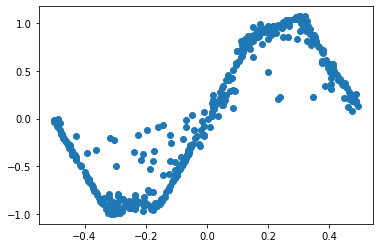

[GAN training] Epoch 41499/60000:
        Acc. real: 0.515999972820282
        Acc. fake: 0.6039999723434448


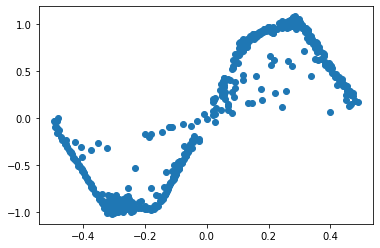

[GAN training] Epoch 41599/60000:
        Acc. real: 0.550000011920929
        Acc. fake: 0.5580000281333923


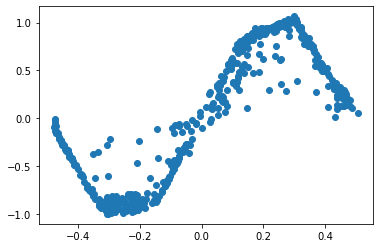

[GAN training] Epoch 41699/60000:
        Acc. real: 0.6919999718666077
        Acc. fake: 0.515999972820282


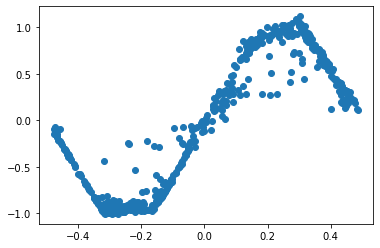

[GAN training] Epoch 41799/60000:
        Acc. real: 0.550000011920929
        Acc. fake: 0.6320000290870667


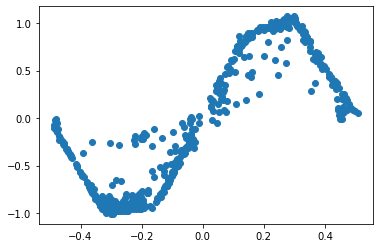

[GAN training] Epoch 41899/60000:
        Acc. real: 0.621999979019165
        Acc. fake: 0.49799999594688416


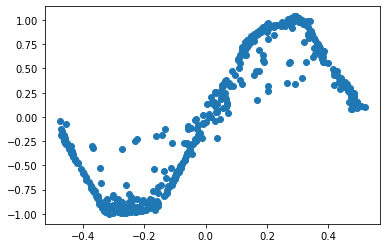

[GAN training] Epoch 41999/60000:
        Acc. real: 0.6940000057220459
        Acc. fake: 0.49799999594688416


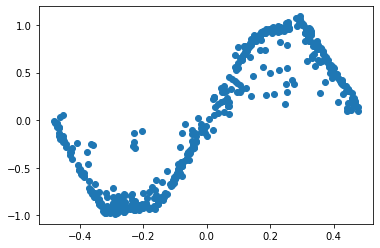

[GAN training] Epoch 42099/60000:
        Acc. real: 0.5519999861717224
        Acc. fake: 0.5640000104904175


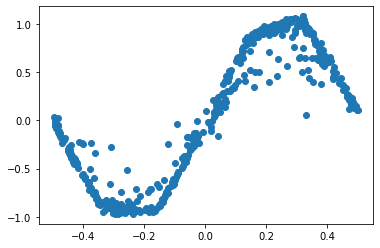

[GAN training] Epoch 42199/60000:
        Acc. real: 0.6579999923706055
        Acc. fake: 0.335999995470047


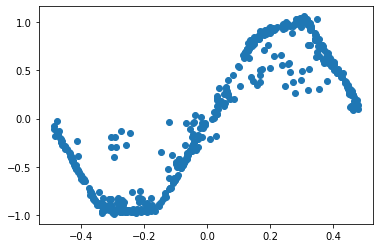

[GAN training] Epoch 42299/60000:
        Acc. real: 0.7360000014305115
        Acc. fake: 0.492000013589859


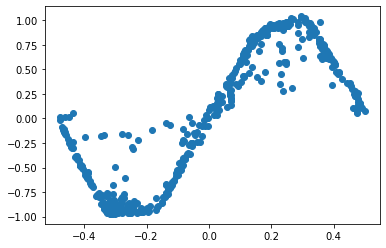

[GAN training] Epoch 42399/60000:
        Acc. real: 0.6859999895095825
        Acc. fake: 0.5080000162124634


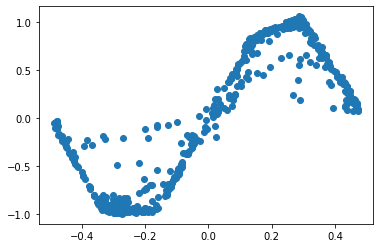

[GAN training] Epoch 42499/60000:
        Acc. real: 0.6579999923706055
        Acc. fake: 0.5440000295639038


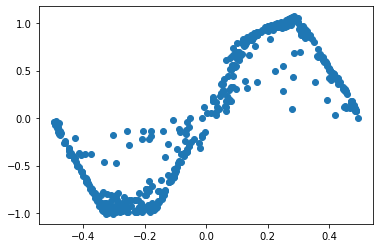

[GAN training] Epoch 42599/60000:
        Acc. real: 0.5099999904632568
        Acc. fake: 0.6079999804496765


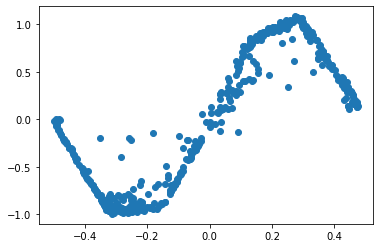

[GAN training] Epoch 42699/60000:
        Acc. real: 0.5559999942779541
        Acc. fake: 0.5299999713897705


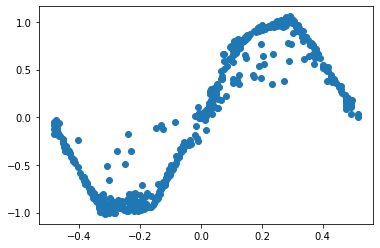

[GAN training] Epoch 42799/60000:
        Acc. real: 0.671999990940094
        Acc. fake: 0.4860000014305115


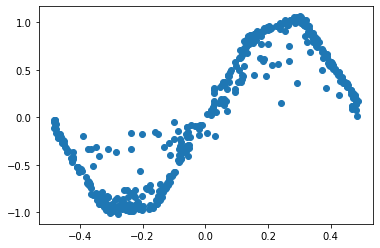

[GAN training] Epoch 42899/60000:
        Acc. real: 0.5979999899864197
        Acc. fake: 0.5640000104904175


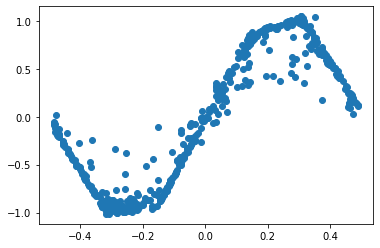

[GAN training] Epoch 42999/60000:
        Acc. real: 0.5540000200271606
        Acc. fake: 0.5419999957084656


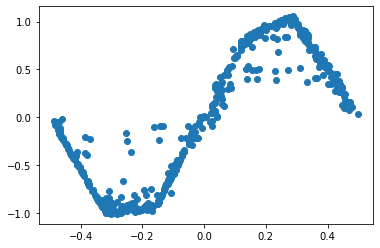

[GAN training] Epoch 43099/60000:
        Acc. real: 0.8040000200271606
        Acc. fake: 0.30399999022483826


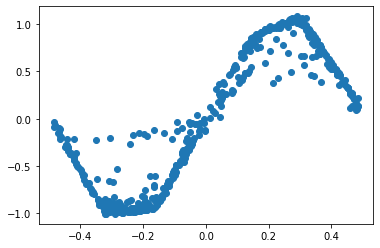

[GAN training] Epoch 43199/60000:
        Acc. real: 0.6520000100135803
        Acc. fake: 0.5379999876022339


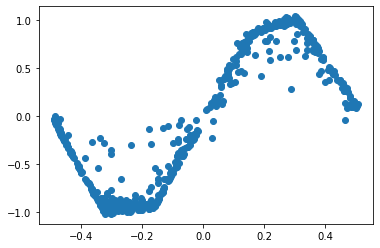

[GAN training] Epoch 43299/60000:
        Acc. real: 0.5379999876022339
        Acc. fake: 0.5540000200271606


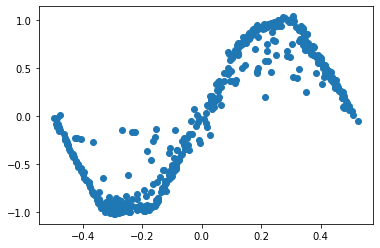

[GAN training] Epoch 43399/60000:
        Acc. real: 0.5360000133514404
        Acc. fake: 0.5879999995231628


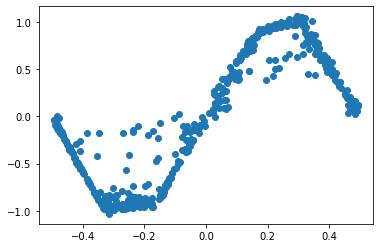

[GAN training] Epoch 43499/60000:
        Acc. real: 0.5519999861717224
        Acc. fake: 0.5080000162124634


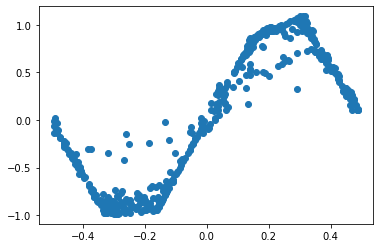

[GAN training] Epoch 43599/60000:
        Acc. real: 0.6100000143051147
        Acc. fake: 0.49399998784065247


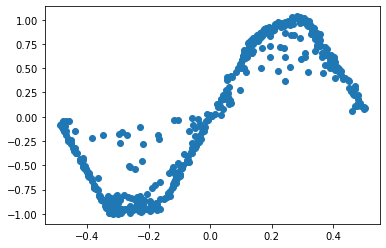

[GAN training] Epoch 43699/60000:
        Acc. real: 0.5860000252723694
        Acc. fake: 0.5320000052452087


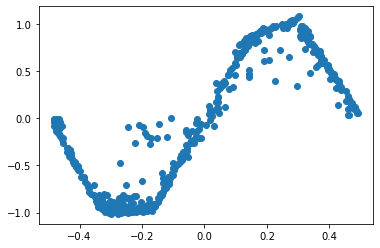

[GAN training] Epoch 43799/60000:
        Acc. real: 0.5720000267028809
        Acc. fake: 0.5619999766349792


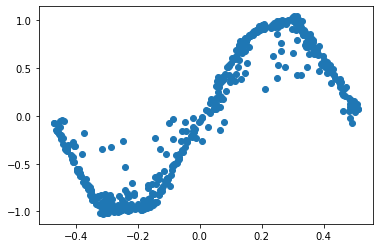

[GAN training] Epoch 43899/60000:
        Acc. real: 0.699999988079071
        Acc. fake: 0.4699999988079071


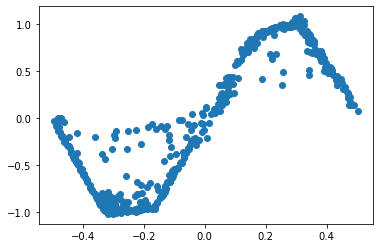

[GAN training] Epoch 43999/60000:
        Acc. real: 0.671999990940094
        Acc. fake: 0.5260000228881836


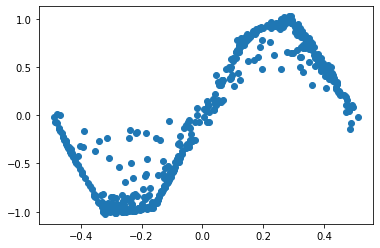

[GAN training] Epoch 44099/60000:
        Acc. real: 0.5759999752044678
        Acc. fake: 0.515999972820282


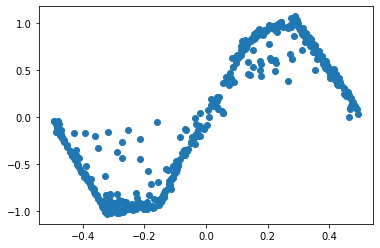

[GAN training] Epoch 44199/60000:
        Acc. real: 0.4359999895095825
        Acc. fake: 0.7120000123977661


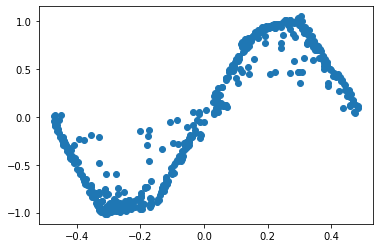

[GAN training] Epoch 44299/60000:
        Acc. real: 0.7239999771118164
        Acc. fake: 0.5019999742507935


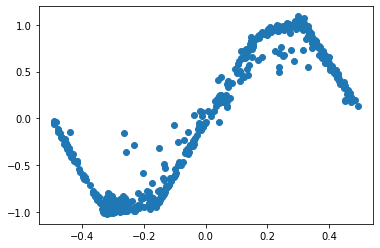

[GAN training] Epoch 44399/60000:
        Acc. real: 0.6759999990463257
        Acc. fake: 0.3779999911785126


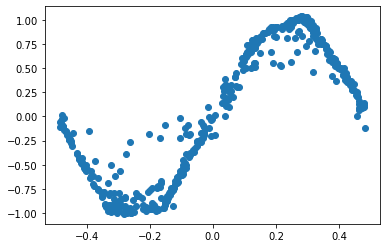

[GAN training] Epoch 44499/60000:
        Acc. real: 0.6019999980926514
        Acc. fake: 0.4320000112056732


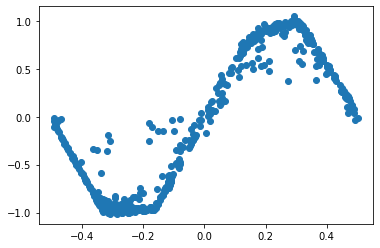

[GAN training] Epoch 44599/60000:
        Acc. real: 0.6340000033378601
        Acc. fake: 0.46799999475479126


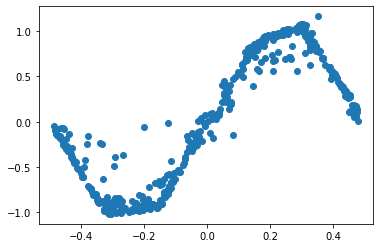

[GAN training] Epoch 44699/60000:
        Acc. real: 0.5440000295639038
        Acc. fake: 0.5440000295639038


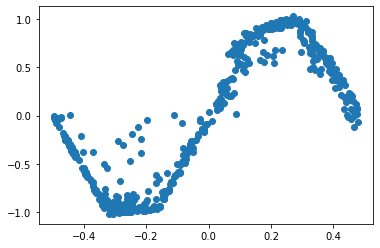

[GAN training] Epoch 44799/60000:
        Acc. real: 0.5619999766349792
        Acc. fake: 0.5479999780654907


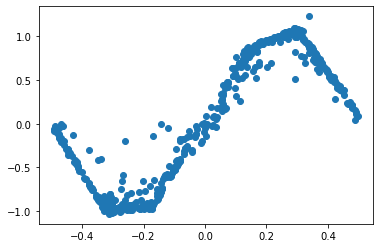

[GAN training] Epoch 44899/60000:
        Acc. real: 0.7160000205039978
        Acc. fake: 0.47600001096725464


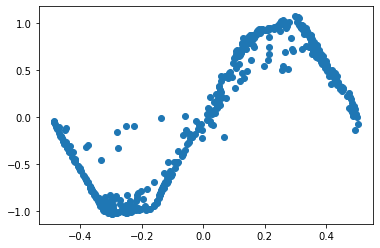

[GAN training] Epoch 44999/60000:
        Acc. real: 0.5260000228881836
        Acc. fake: 0.6439999938011169


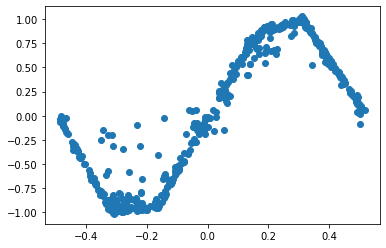

[GAN training] Epoch 45099/60000:
        Acc. real: 0.6140000224113464
        Acc. fake: 0.4339999854564667


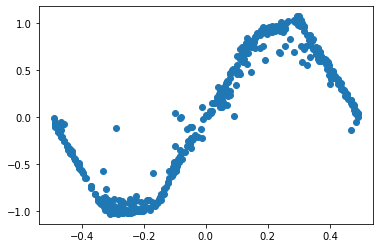

[GAN training] Epoch 45199/60000:
        Acc. real: 0.5379999876022339
        Acc. fake: 0.42399999499320984


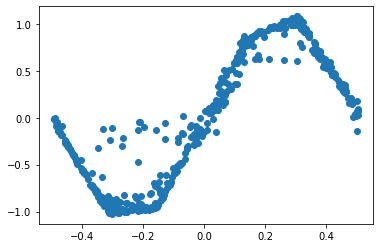

[GAN training] Epoch 45299/60000:
        Acc. real: 0.6100000143051147
        Acc. fake: 0.5339999794960022


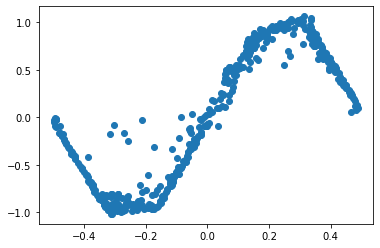

[GAN training] Epoch 45399/60000:
        Acc. real: 0.5759999752044678
        Acc. fake: 0.5180000066757202


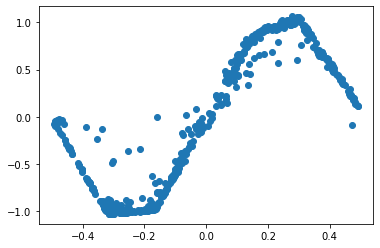

[GAN training] Epoch 45499/60000:
        Acc. real: 0.5600000023841858
        Acc. fake: 0.47999998927116394


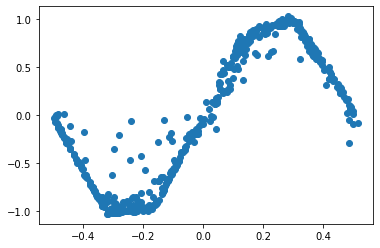

[GAN training] Epoch 45599/60000:
        Acc. real: 0.7160000205039978
        Acc. fake: 0.38600000739097595


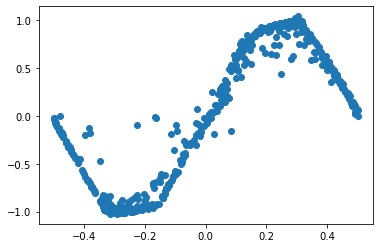

[GAN training] Epoch 45699/60000:
        Acc. real: 0.6800000071525574
        Acc. fake: 0.4560000002384186


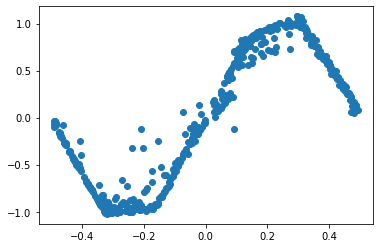

[GAN training] Epoch 45799/60000:
        Acc. real: 0.6740000247955322
        Acc. fake: 0.5239999890327454


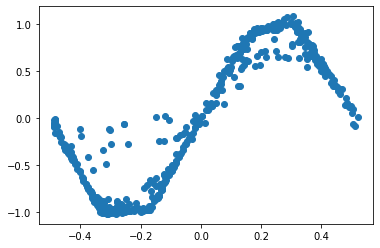

[GAN training] Epoch 45899/60000:
        Acc. real: 0.6700000166893005
        Acc. fake: 0.4740000069141388


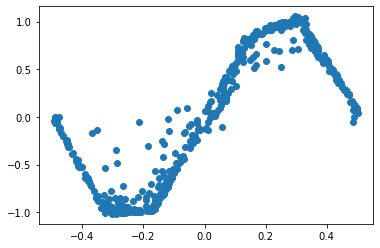

[GAN training] Epoch 45999/60000:
        Acc. real: 0.5759999752044678
        Acc. fake: 0.5419999957084656


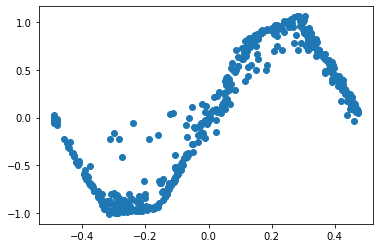

[GAN training] Epoch 46099/60000:
        Acc. real: 0.5180000066757202
        Acc. fake: 0.550000011920929


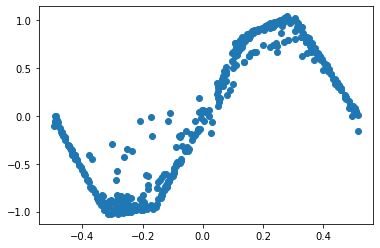

[GAN training] Epoch 46199/60000:
        Acc. real: 0.5260000228881836
        Acc. fake: 0.5360000133514404


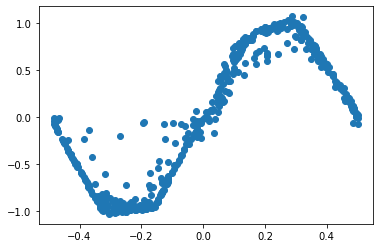

[GAN training] Epoch 46299/60000:
        Acc. real: 0.6600000262260437
        Acc. fake: 0.47999998927116394


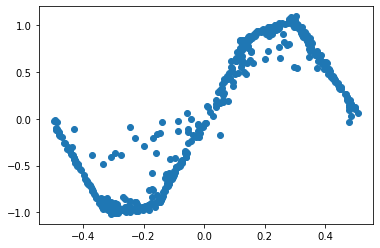

[GAN training] Epoch 46399/60000:
        Acc. real: 0.6039999723434448
        Acc. fake: 0.5720000267028809


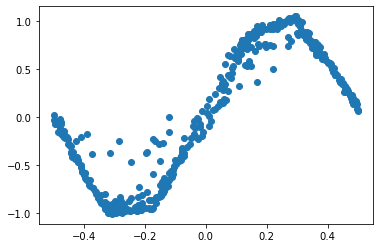

[GAN training] Epoch 46499/60000:
        Acc. real: 0.5260000228881836
        Acc. fake: 0.5400000214576721


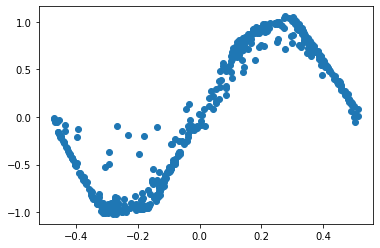

[GAN training] Epoch 46599/60000:
        Acc. real: 0.578000009059906
        Acc. fake: 0.5299999713897705


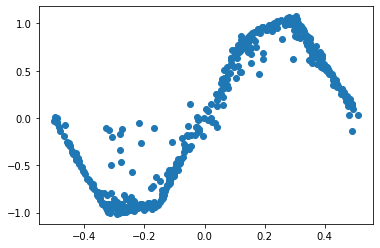

[GAN training] Epoch 46699/60000:
        Acc. real: 0.47999998927116394
        Acc. fake: 0.5820000171661377


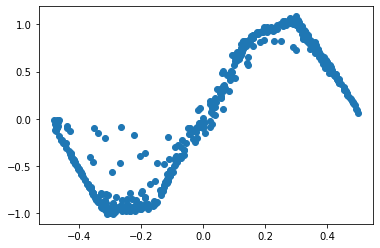

[GAN training] Epoch 46799/60000:
        Acc. real: 0.5740000009536743
        Acc. fake: 0.5419999957084656


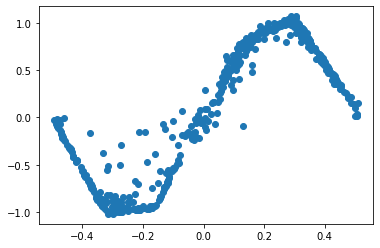

[GAN training] Epoch 46899/60000:
        Acc. real: 0.5239999890327454
        Acc. fake: 0.6480000019073486


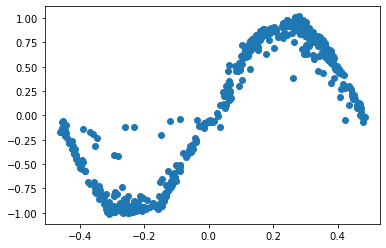

[GAN training] Epoch 46999/60000:
        Acc. real: 0.578000009059906
        Acc. fake: 0.5260000228881836


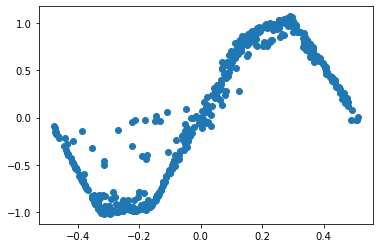

[GAN training] Epoch 47099/60000:
        Acc. real: 0.5080000162124634
        Acc. fake: 0.5619999766349792


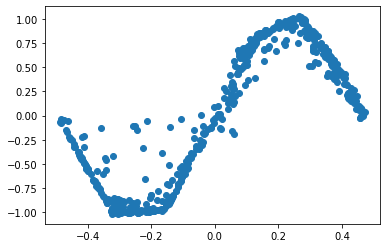

[GAN training] Epoch 47199/60000:
        Acc. real: 0.6259999871253967
        Acc. fake: 0.515999972820282


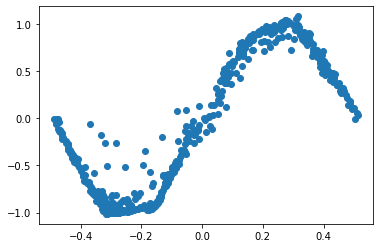

[GAN training] Epoch 47299/60000:
        Acc. real: 0.6840000152587891
        Acc. fake: 0.550000011920929


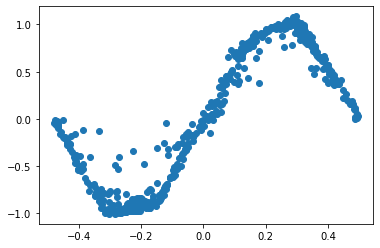

[GAN training] Epoch 47399/60000:
        Acc. real: 0.5799999833106995
        Acc. fake: 0.5460000038146973


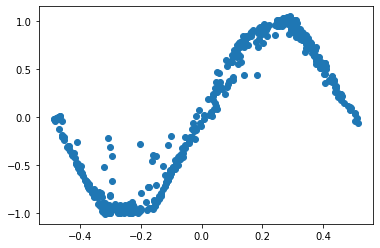

[GAN training] Epoch 47499/60000:
        Acc. real: 0.656000018119812
        Acc. fake: 0.44600000977516174


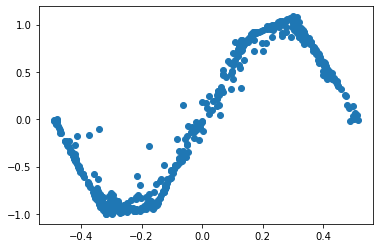

[GAN training] Epoch 47599/60000:
        Acc. real: 0.492000013589859
        Acc. fake: 0.6140000224113464


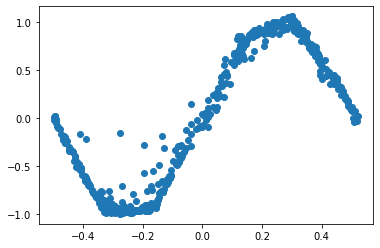

[GAN training] Epoch 47699/60000:
        Acc. real: 0.5979999899864197
        Acc. fake: 0.5680000185966492


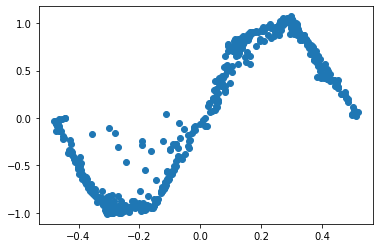

[GAN training] Epoch 47799/60000:
        Acc. real: 0.43799999356269836
        Acc. fake: 0.628000020980835


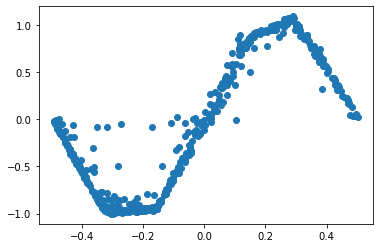

[GAN training] Epoch 47899/60000:
        Acc. real: 0.6420000195503235
        Acc. fake: 0.49799999594688416


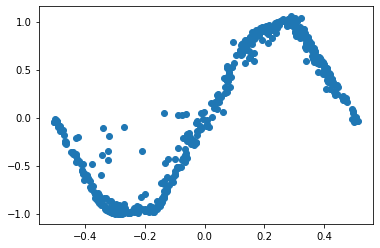

[GAN training] Epoch 47999/60000:
        Acc. real: 0.6320000290870667
        Acc. fake: 0.4779999852180481


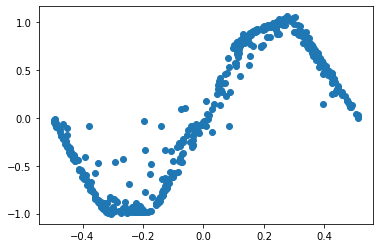

[GAN training] Epoch 48099/60000:
        Acc. real: 0.5320000052452087
        Acc. fake: 0.4659999907016754


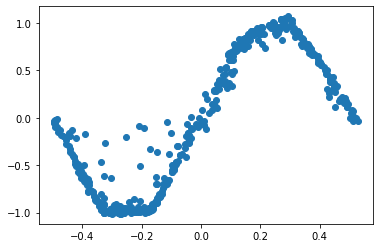

[GAN training] Epoch 48199/60000:
        Acc. real: 0.5879999995231628
        Acc. fake: 0.48399999737739563


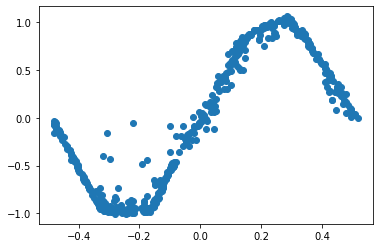

[GAN training] Epoch 48299/60000:
        Acc. real: 0.4860000014305115
        Acc. fake: 0.6119999885559082


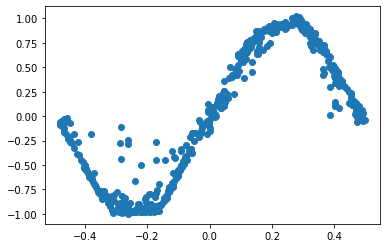

[GAN training] Epoch 48399/60000:
        Acc. real: 0.6700000166893005
        Acc. fake: 0.4399999976158142


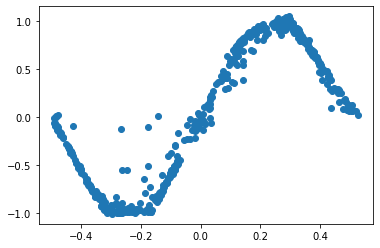

[GAN training] Epoch 48499/60000:
        Acc. real: 0.4659999907016754
        Acc. fake: 0.5619999766349792


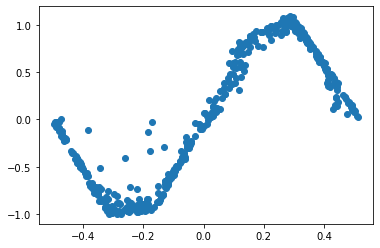

[GAN training] Epoch 48599/60000:
        Acc. real: 0.4339999854564667
        Acc. fake: 0.7120000123977661


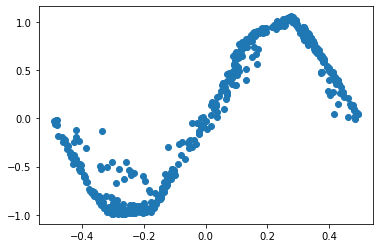

[GAN training] Epoch 48699/60000:
        Acc. real: 0.5879999995231628
        Acc. fake: 0.5580000281333923


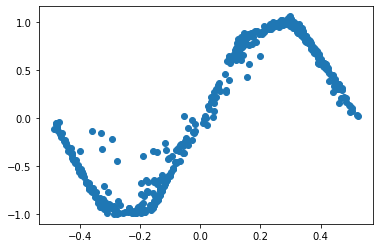

[GAN training] Epoch 48799/60000:
        Acc. real: 0.5400000214576721
        Acc. fake: 0.6499999761581421


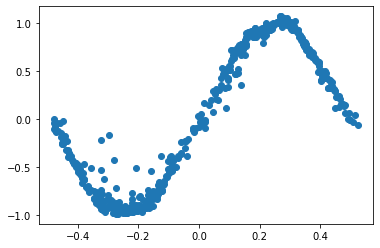

[GAN training] Epoch 48899/60000:
        Acc. real: 0.5680000185966492
        Acc. fake: 0.4519999921321869


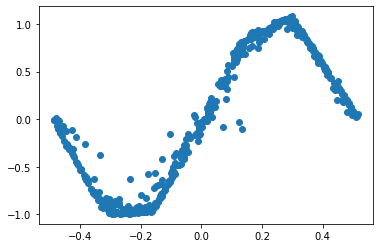

[GAN training] Epoch 48999/60000:
        Acc. real: 0.5080000162124634
        Acc. fake: 0.5759999752044678


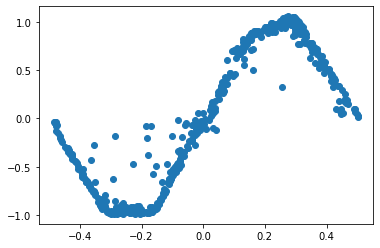

[GAN training] Epoch 49099/60000:
        Acc. real: 0.5799999833106995
        Acc. fake: 0.6039999723434448


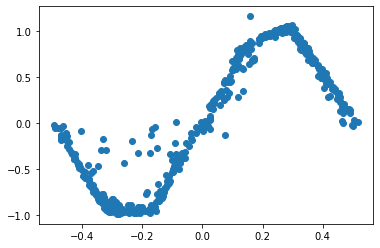

[GAN training] Epoch 49199/60000:
        Acc. real: 0.5239999890327454
        Acc. fake: 0.5339999794960022


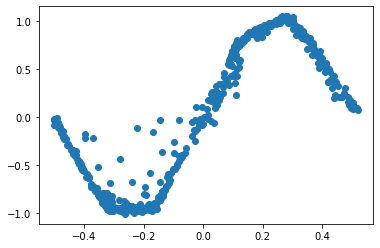

[GAN training] Epoch 49299/60000:
        Acc. real: 0.6060000061988831
        Acc. fake: 0.5580000281333923


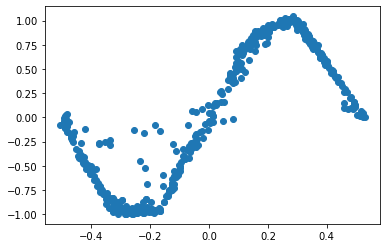

[GAN training] Epoch 49399/60000:
        Acc. real: 0.45399999618530273
        Acc. fake: 0.628000020980835


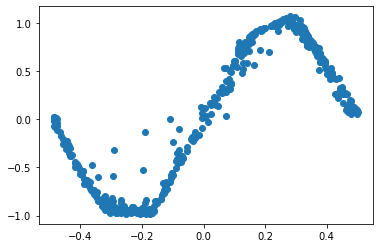

[GAN training] Epoch 49499/60000:
        Acc. real: 0.5699999928474426
        Acc. fake: 0.5419999957084656


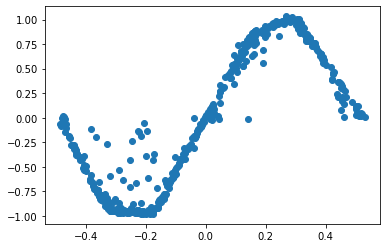

[GAN training] Epoch 49599/60000:
        Acc. real: 0.5479999780654907
        Acc. fake: 0.515999972820282


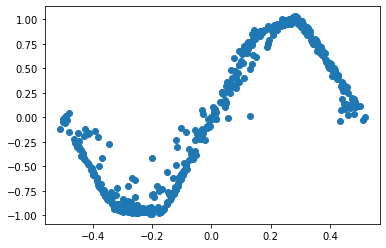

[GAN training] Epoch 49699/60000:
        Acc. real: 0.5040000081062317
        Acc. fake: 0.6039999723434448


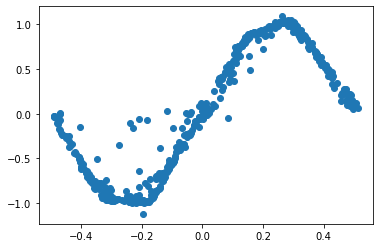

[GAN training] Epoch 49799/60000:
        Acc. real: 0.492000013589859
        Acc. fake: 0.5299999713897705


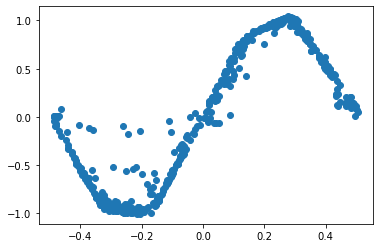

[GAN training] Epoch 49899/60000:
        Acc. real: 0.3799999952316284
        Acc. fake: 0.6299999952316284


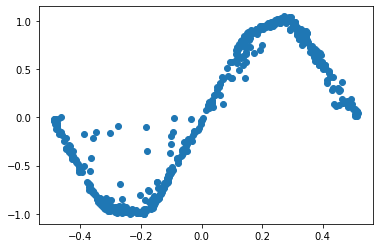

[GAN training] Epoch 49999/60000:
        Acc. real: 0.6060000061988831
        Acc. fake: 0.5400000214576721


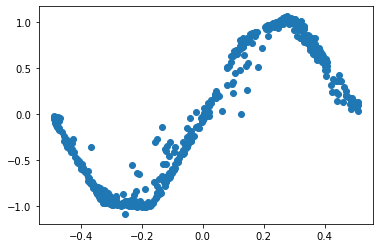

[GAN training] Epoch 50099/60000:
        Acc. real: 0.4560000002384186
        Acc. fake: 0.593999981880188


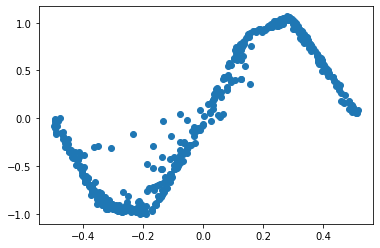

[GAN training] Epoch 50199/60000:
        Acc. real: 0.7139999866485596
        Acc. fake: 0.3880000114440918


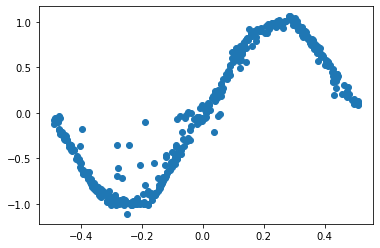

[GAN training] Epoch 50299/60000:
        Acc. real: 0.5659999847412109
        Acc. fake: 0.5619999766349792


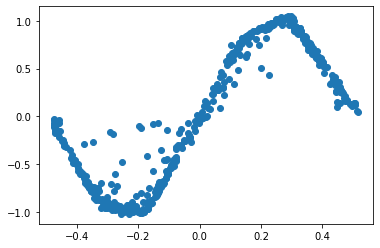

[GAN training] Epoch 50399/60000:
        Acc. real: 0.6359999775886536
        Acc. fake: 0.4339999854564667


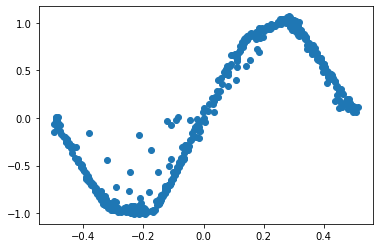

[GAN training] Epoch 50499/60000:
        Acc. real: 0.6039999723434448
        Acc. fake: 0.5419999957084656


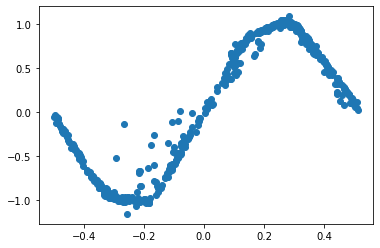

[GAN training] Epoch 50599/60000:
        Acc. real: 0.49799999594688416
        Acc. fake: 0.6700000166893005


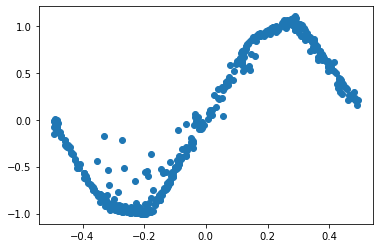

[GAN training] Epoch 50699/60000:
        Acc. real: 0.5580000281333923
        Acc. fake: 0.5099999904632568


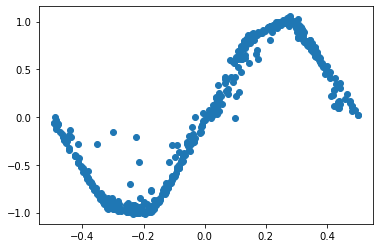

[GAN training] Epoch 50799/60000:
        Acc. real: 0.4519999921321869
        Acc. fake: 0.5879999995231628


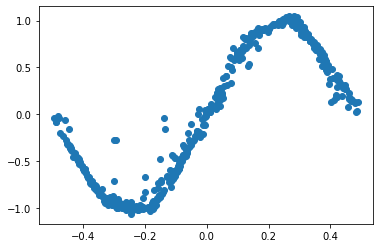

[GAN training] Epoch 50899/60000:
        Acc. real: 0.4580000042915344
        Acc. fake: 0.6439999938011169


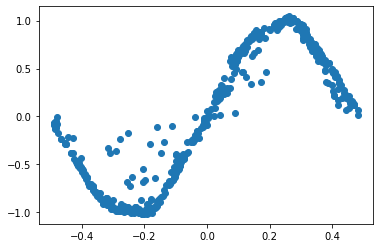

[GAN training] Epoch 50999/60000:
        Acc. real: 0.550000011920929
        Acc. fake: 0.527999997138977


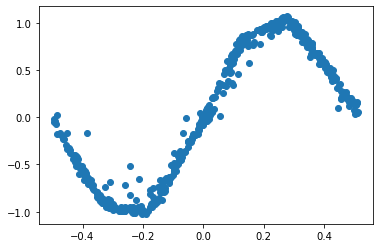

[GAN training] Epoch 51099/60000:
        Acc. real: 0.6100000143051147
        Acc. fake: 0.5659999847412109


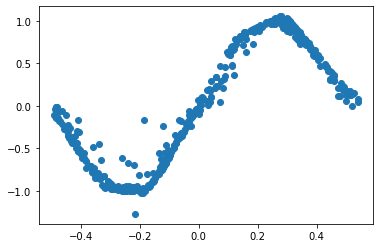

[GAN training] Epoch 51199/60000:
        Acc. real: 0.5419999957084656
        Acc. fake: 0.5339999794960022


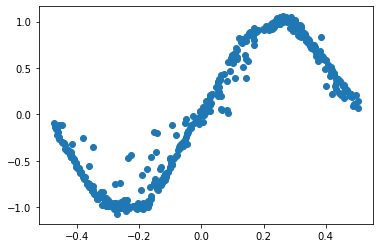

[GAN training] Epoch 51299/60000:
        Acc. real: 0.5879999995231628
        Acc. fake: 0.49799999594688416


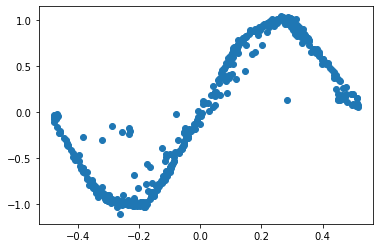

[GAN training] Epoch 51399/60000:
        Acc. real: 0.656000018119812
        Acc. fake: 0.44200000166893005


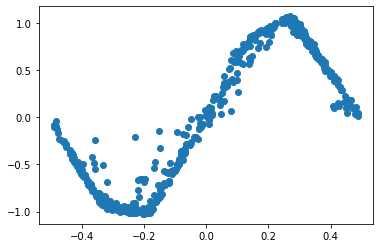

[GAN training] Epoch 51499/60000:
        Acc. real: 0.7160000205039978
        Acc. fake: 0.4880000054836273


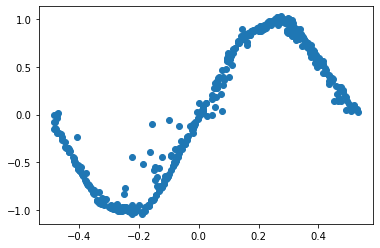

[GAN training] Epoch 51599/60000:
        Acc. real: 0.527999997138977
        Acc. fake: 0.5600000023841858


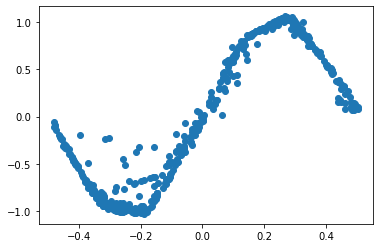

[GAN training] Epoch 51699/60000:
        Acc. real: 0.5120000243186951
        Acc. fake: 0.6140000224113464


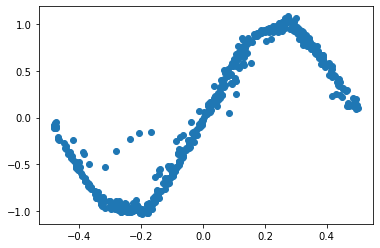

[GAN training] Epoch 51799/60000:
        Acc. real: 0.515999972820282
        Acc. fake: 0.6620000004768372


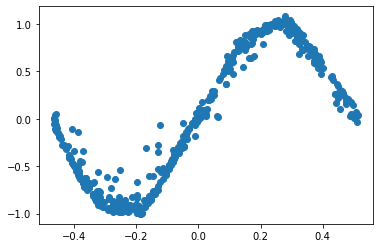

[GAN training] Epoch 51899/60000:
        Acc. real: 0.5260000228881836
        Acc. fake: 0.5600000023841858


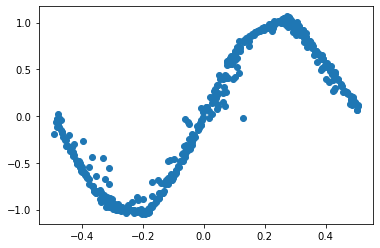

[GAN training] Epoch 51999/60000:
        Acc. real: 0.6340000033378601
        Acc. fake: 0.5379999876022339


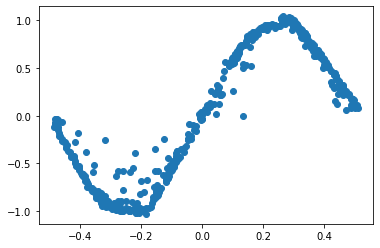

[GAN training] Epoch 52099/60000:
        Acc. real: 0.4740000069141388
        Acc. fake: 0.5920000076293945


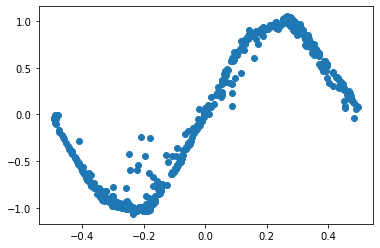

[GAN training] Epoch 52199/60000:
        Acc. real: 0.46399998664855957
        Acc. fake: 0.6019999980926514


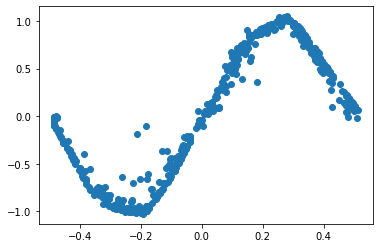

[GAN training] Epoch 52299/60000:
        Acc. real: 0.44999998807907104
        Acc. fake: 0.6119999885559082


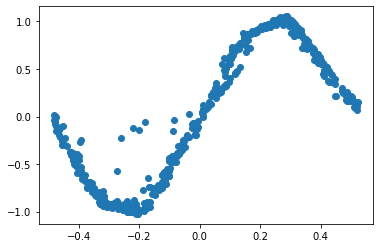

[GAN training] Epoch 52399/60000:
        Acc. real: 0.5299999713897705
        Acc. fake: 0.5879999995231628


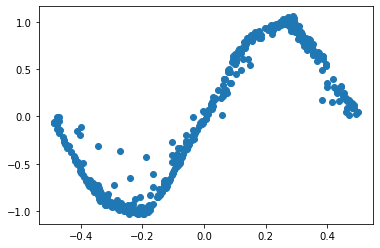

[GAN training] Epoch 52499/60000:
        Acc. real: 0.5839999914169312
        Acc. fake: 0.5239999890327454


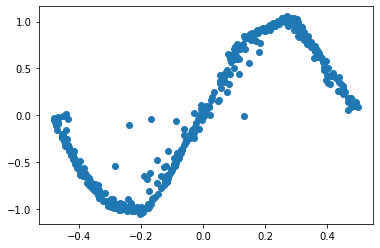

[GAN training] Epoch 52599/60000:
        Acc. real: 0.6520000100135803
        Acc. fake: 0.3959999978542328


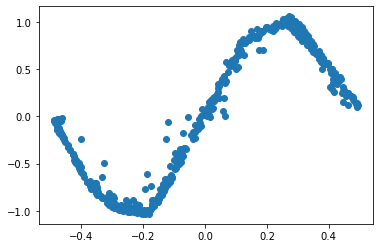

[GAN training] Epoch 52699/60000:
        Acc. real: 0.6119999885559082
        Acc. fake: 0.4880000054836273


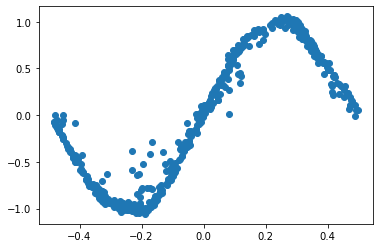

[GAN training] Epoch 52799/60000:
        Acc. real: 0.578000009059906
        Acc. fake: 0.6000000238418579


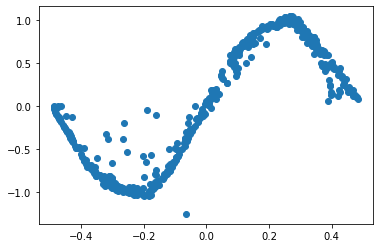

[GAN training] Epoch 52899/60000:
        Acc. real: 0.5559999942779541
        Acc. fake: 0.527999997138977


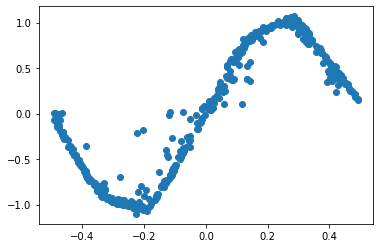

[GAN training] Epoch 52999/60000:
        Acc. real: 0.5080000162124634
        Acc. fake: 0.6499999761581421


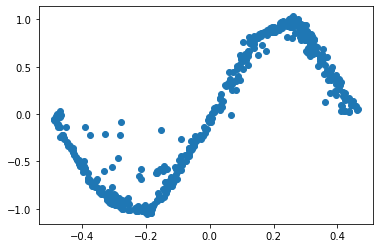

[GAN training] Epoch 53099/60000:
        Acc. real: 0.5260000228881836
        Acc. fake: 0.6140000224113464


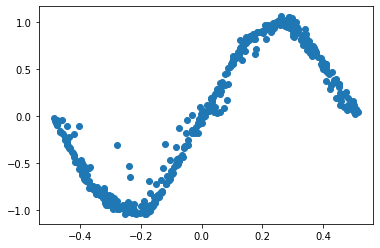

[GAN training] Epoch 53199/60000:
        Acc. real: 0.5619999766349792
        Acc. fake: 0.5320000052452087


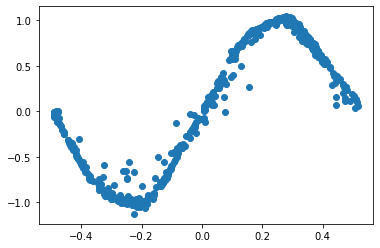

[GAN training] Epoch 53299/60000:
        Acc. real: 0.6420000195503235
        Acc. fake: 0.42800000309944153


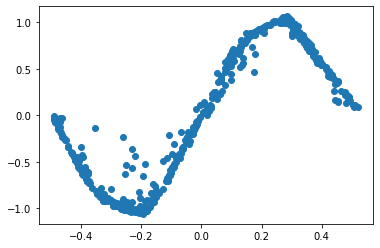

[GAN training] Epoch 53399/60000:
        Acc. real: 0.5220000147819519
        Acc. fake: 0.5740000009536743


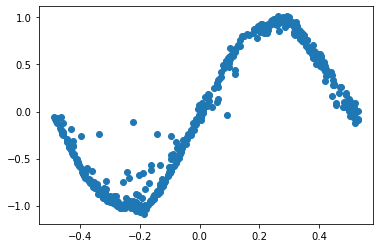

[GAN training] Epoch 53499/60000:
        Acc. real: 0.5019999742507935
        Acc. fake: 0.6039999723434448


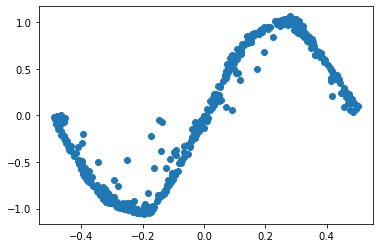

[GAN training] Epoch 53599/60000:
        Acc. real: 0.46799999475479126
        Acc. fake: 0.6299999952316284


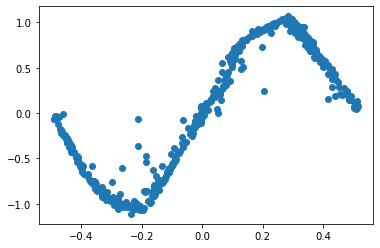

[GAN training] Epoch 53699/60000:
        Acc. real: 0.5320000052452087
        Acc. fake: 0.6159999966621399


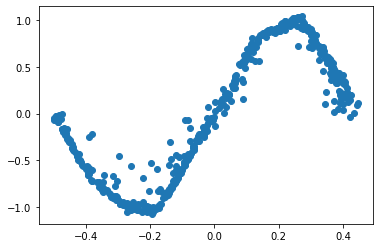

[GAN training] Epoch 53799/60000:
        Acc. real: 0.5120000243186951
        Acc. fake: 0.621999979019165


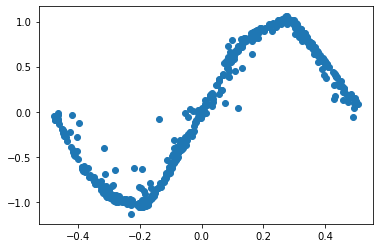

[GAN training] Epoch 53899/60000:
        Acc. real: 0.5960000157356262
        Acc. fake: 0.5979999899864197


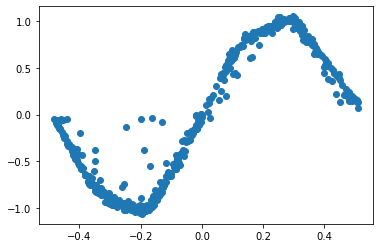

[GAN training] Epoch 53999/60000:
        Acc. real: 0.5320000052452087
        Acc. fake: 0.5519999861717224


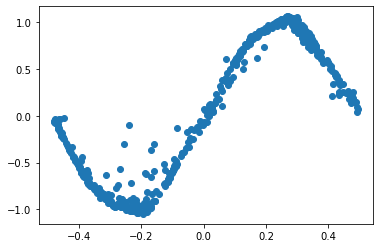

[GAN training] Epoch 54099/60000:
        Acc. real: 0.44999998807907104
        Acc. fake: 0.6480000019073486


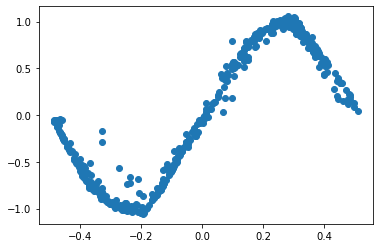

[GAN training] Epoch 54199/60000:
        Acc. real: 0.4000000059604645
        Acc. fake: 0.6420000195503235


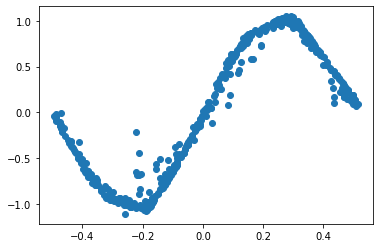

[GAN training] Epoch 54299/60000:
        Acc. real: 0.5139999985694885
        Acc. fake: 0.6320000290870667


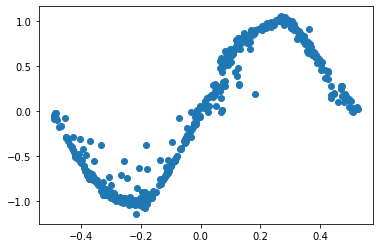

[GAN training] Epoch 54399/60000:
        Acc. real: 0.4779999852180481
        Acc. fake: 0.6299999952316284


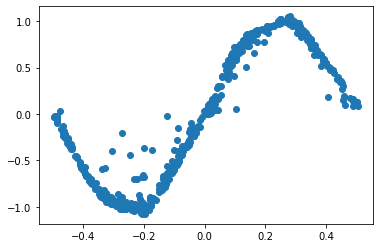

[GAN training] Epoch 54499/60000:
        Acc. real: 0.5899999737739563
        Acc. fake: 0.5759999752044678


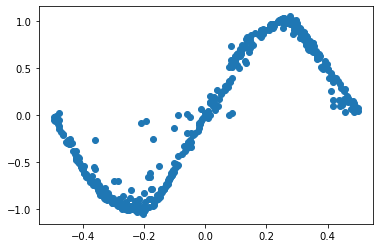

[GAN training] Epoch 54599/60000:
        Acc. real: 0.5460000038146973
        Acc. fake: 0.5659999847412109


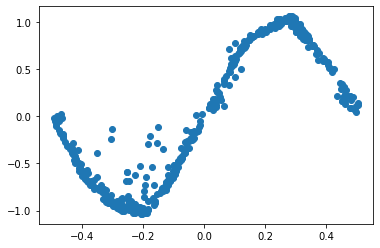

[GAN training] Epoch 54699/60000:
        Acc. real: 0.6000000238418579
        Acc. fake: 0.5400000214576721


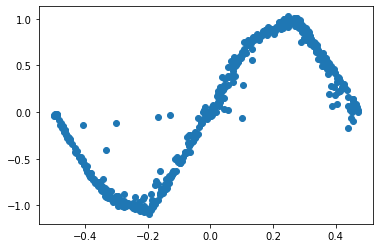

[GAN training] Epoch 54799/60000:
        Acc. real: 0.45399999618530273
        Acc. fake: 0.6380000114440918


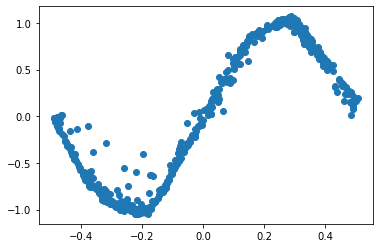

[GAN training] Epoch 54899/60000:
        Acc. real: 0.5419999957084656
        Acc. fake: 0.5960000157356262


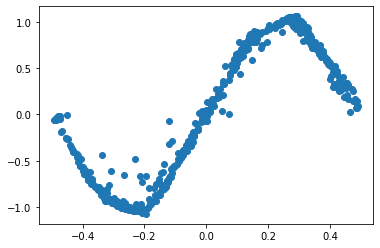

[GAN training] Epoch 54999/60000:
        Acc. real: 0.5320000052452087
        Acc. fake: 0.5460000038146973


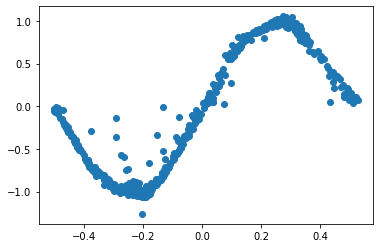

[GAN training] Epoch 55099/60000:
        Acc. real: 0.7360000014305115
        Acc. fake: 0.4339999854564667


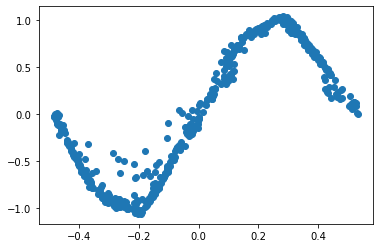

[GAN training] Epoch 55199/60000:
        Acc. real: 0.5559999942779541
        Acc. fake: 0.5299999713897705


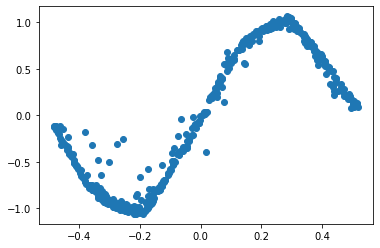

[GAN training] Epoch 55299/60000:
        Acc. real: 0.5860000252723694
        Acc. fake: 0.5080000162124634


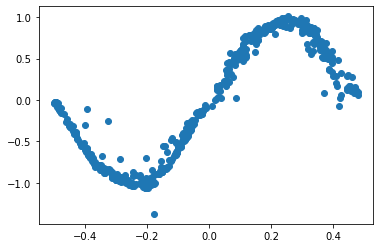

[GAN training] Epoch 55399/60000:
        Acc. real: 0.5059999823570251
        Acc. fake: 0.6320000290870667


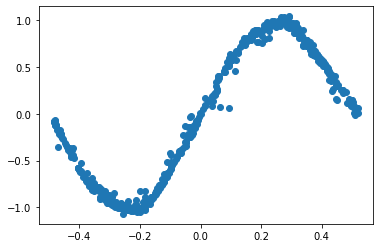

[GAN training] Epoch 55499/60000:
        Acc. real: 0.4560000002384186
        Acc. fake: 0.6380000114440918


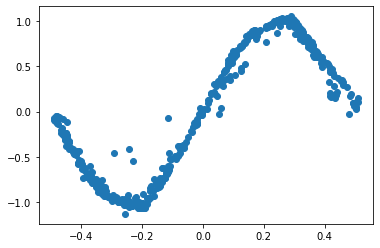

[GAN training] Epoch 55599/60000:
        Acc. real: 0.5820000171661377
        Acc. fake: 0.6320000290870667


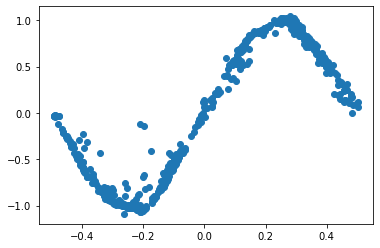

[GAN training] Epoch 55699/60000:
        Acc. real: 0.5400000214576721
        Acc. fake: 0.6240000128746033


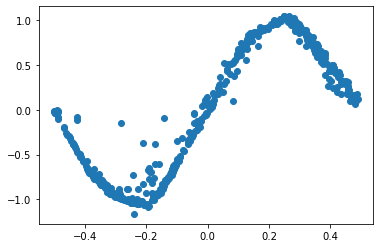

[GAN training] Epoch 55799/60000:
        Acc. real: 0.5080000162124634
        Acc. fake: 0.628000020980835


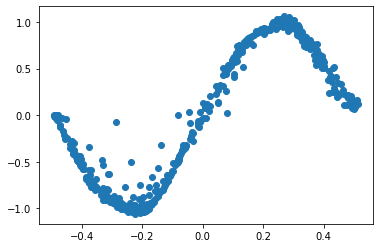

[GAN training] Epoch 55899/60000:
        Acc. real: 0.4959999918937683
        Acc. fake: 0.5920000076293945


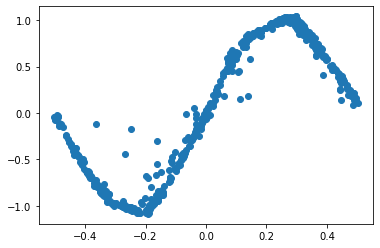

[GAN training] Epoch 55999/60000:
        Acc. real: 0.3540000021457672
        Acc. fake: 0.6779999732971191


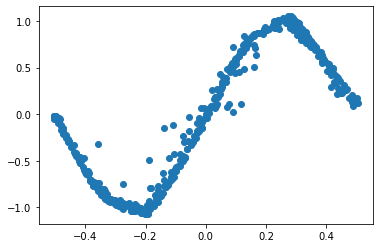

[GAN training] Epoch 56099/60000:
        Acc. real: 0.46000000834465027
        Acc. fake: 0.6460000276565552


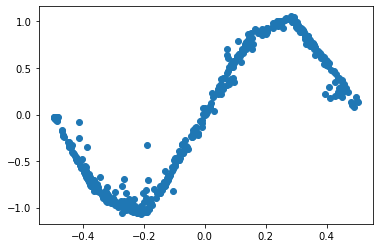

[GAN training] Epoch 56199/60000:
        Acc. real: 0.4259999990463257
        Acc. fake: 0.656000018119812


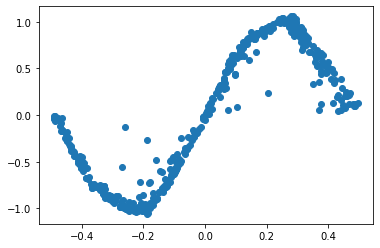

[GAN training] Epoch 56299/60000:
        Acc. real: 0.5460000038146973
        Acc. fake: 0.5440000295639038


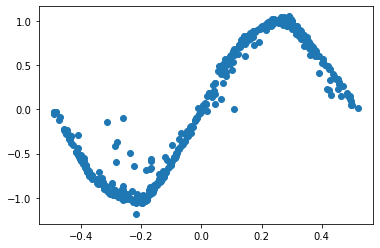

[GAN training] Epoch 56399/60000:
        Acc. real: 0.5580000281333923
        Acc. fake: 0.5699999928474426


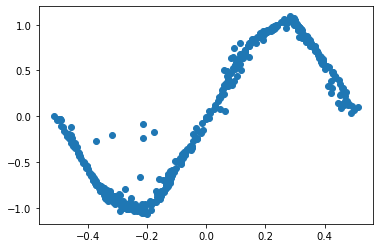

[GAN training] Epoch 56499/60000:
        Acc. real: 0.6240000128746033
        Acc. fake: 0.4880000054836273


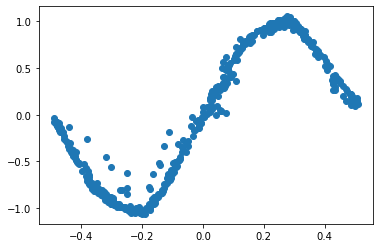

[GAN training] Epoch 56599/60000:
        Acc. real: 0.492000013589859
        Acc. fake: 0.593999981880188


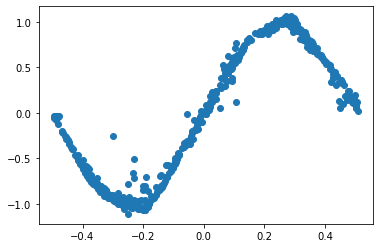

[GAN training] Epoch 56699/60000:
        Acc. real: 0.5559999942779541
        Acc. fake: 0.5820000171661377


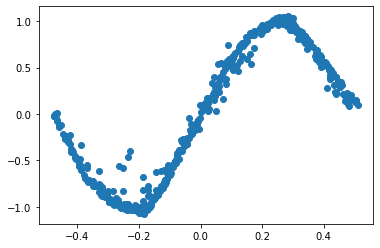

[GAN training] Epoch 56799/60000:
        Acc. real: 0.550000011920929
        Acc. fake: 0.5299999713897705


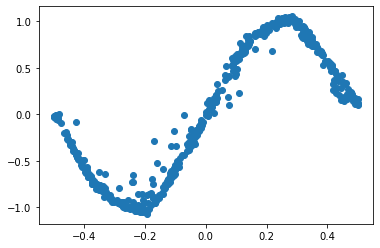

[GAN training] Epoch 56899/60000:
        Acc. real: 0.4740000069141388
        Acc. fake: 0.6039999723434448


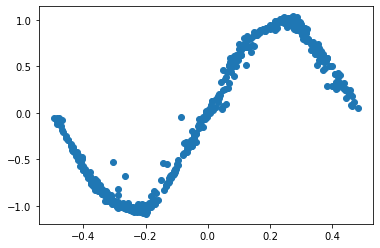

[GAN training] Epoch 56999/60000:
        Acc. real: 0.5339999794960022
        Acc. fake: 0.48399999737739563


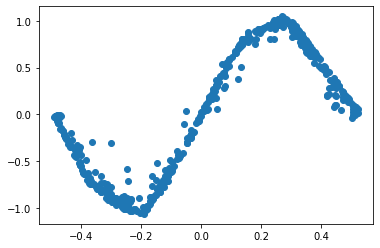

[GAN training] Epoch 57099/60000:
        Acc. real: 0.5860000252723694
        Acc. fake: 0.527999997138977


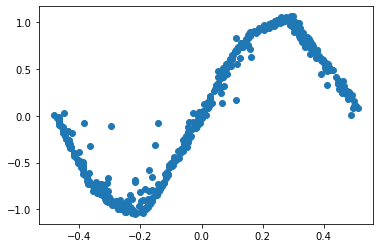

[GAN training] Epoch 57199/60000:
        Acc. real: 0.5360000133514404
        Acc. fake: 0.5640000104904175


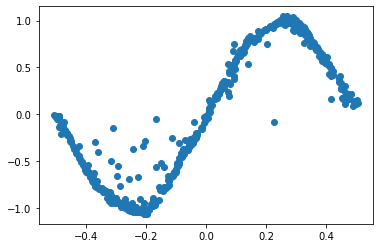

[GAN training] Epoch 57299/60000:
        Acc. real: 0.5559999942779541
        Acc. fake: 0.5460000038146973


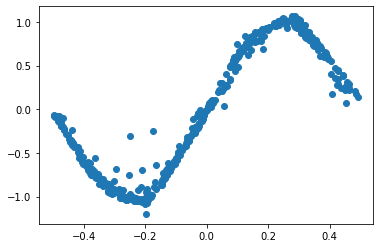

[GAN training] Epoch 57399/60000:
        Acc. real: 0.5059999823570251
        Acc. fake: 0.628000020980835


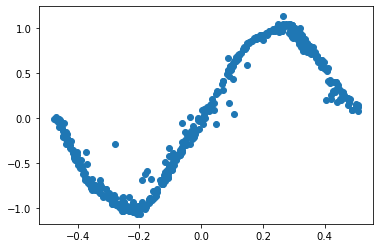

[GAN training] Epoch 57499/60000:
        Acc. real: 0.4620000123977661
        Acc. fake: 0.6140000224113464


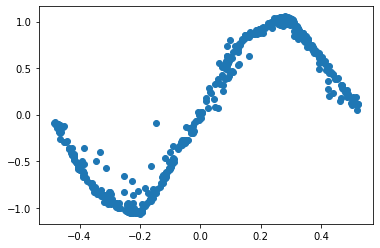

[GAN training] Epoch 57599/60000:
        Acc. real: 0.4779999852180481
        Acc. fake: 0.6399999856948853


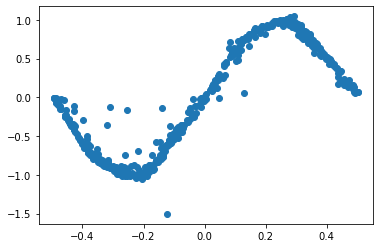

[GAN training] Epoch 57699/60000:
        Acc. real: 0.5540000200271606
        Acc. fake: 0.5360000133514404


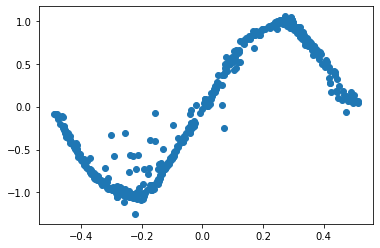

[GAN training] Epoch 57799/60000:
        Acc. real: 0.4560000002384186
        Acc. fake: 0.6159999966621399


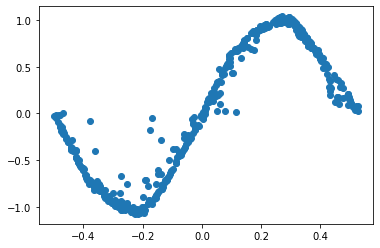

[GAN training] Epoch 57899/60000:
        Acc. real: 0.5400000214576721
        Acc. fake: 0.5619999766349792


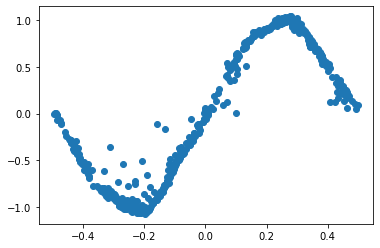

[GAN training] Epoch 57999/60000:
        Acc. real: 0.46799999475479126
        Acc. fake: 0.6520000100135803


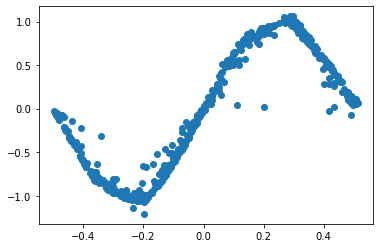

[GAN training] Epoch 58099/60000:
        Acc. real: 0.6060000061988831
        Acc. fake: 0.5199999809265137


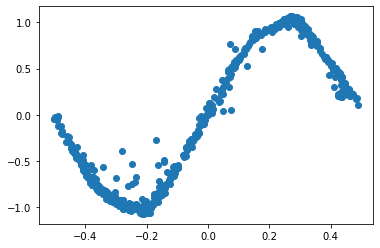

[GAN training] Epoch 58199/60000:
        Acc. real: 0.6000000238418579
        Acc. fake: 0.5220000147819519


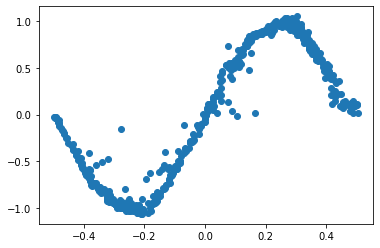

[GAN training] Epoch 58299/60000:
        Acc. real: 0.5360000133514404
        Acc. fake: 0.5860000252723694


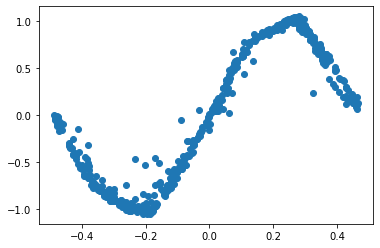

[GAN training] Epoch 58399/60000:
        Acc. real: 0.5199999809265137
        Acc. fake: 0.6159999966621399


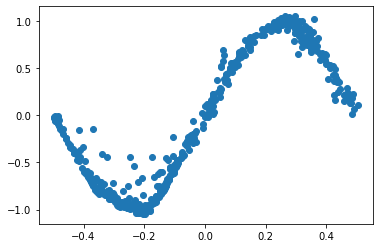

[GAN training] Epoch 58499/60000:
        Acc. real: 0.46000000834465027
        Acc. fake: 0.5799999833106995


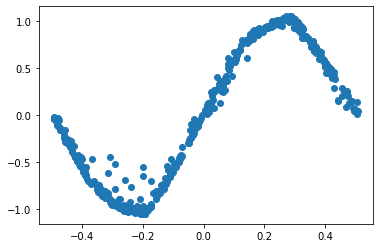

[GAN training] Epoch 58599/60000:
        Acc. real: 0.49799999594688416
        Acc. fake: 0.6039999723434448


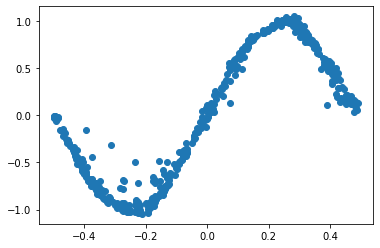

[GAN training] Epoch 58699/60000:
        Acc. real: 0.5699999928474426
        Acc. fake: 0.5320000052452087


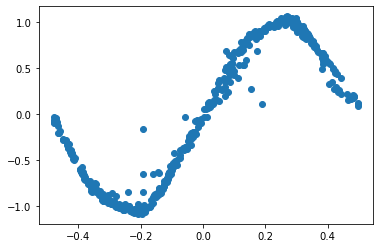

[GAN training] Epoch 58799/60000:
        Acc. real: 0.5559999942779541
        Acc. fake: 0.550000011920929


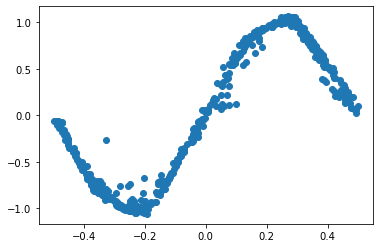

[GAN training] Epoch 58899/60000:
        Acc. real: 0.527999997138977
        Acc. fake: 0.5619999766349792


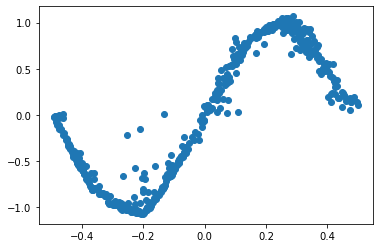

[GAN training] Epoch 58999/60000:
        Acc. real: 0.44999998807907104
        Acc. fake: 0.5860000252723694


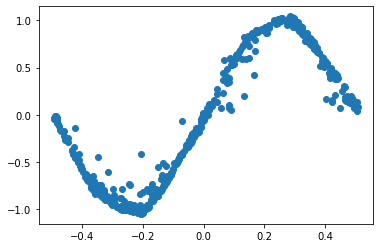

[GAN training] Epoch 59099/60000:
        Acc. real: 0.4860000014305115
        Acc. fake: 0.6179999709129333


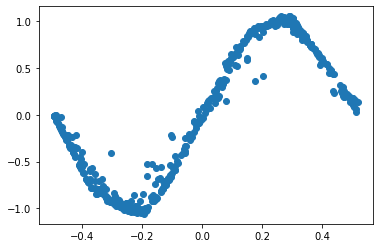

[GAN training] Epoch 59199/60000:
        Acc. real: 0.5
        Acc. fake: 0.6019999980926514


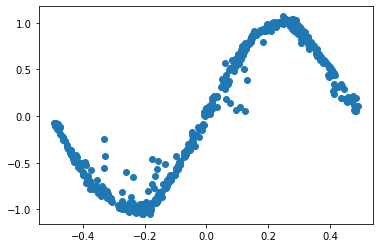

[GAN training] Epoch 59299/60000:
        Acc. real: 0.5419999957084656
        Acc. fake: 0.5519999861717224


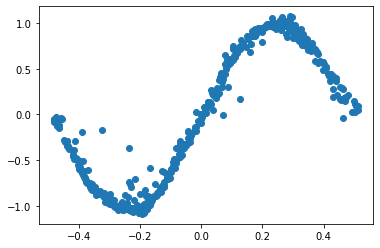

[GAN training] Epoch 59399/60000:
        Acc. real: 0.49799999594688416
        Acc. fake: 0.5799999833106995


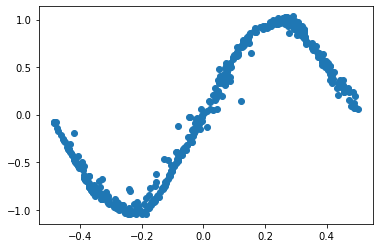

[GAN training] Epoch 59499/60000:
        Acc. real: 0.4880000054836273
        Acc. fake: 0.6079999804496765


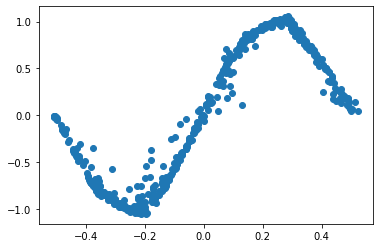

[GAN training] Epoch 59599/60000:
        Acc. real: 0.5320000052452087
        Acc. fake: 0.5979999899864197


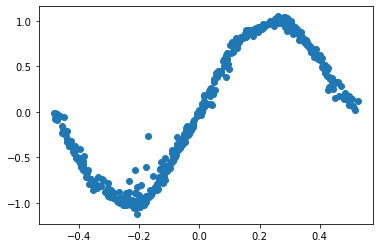

[GAN training] Epoch 59699/60000:
        Acc. real: 0.4300000071525574
        Acc. fake: 0.6299999952316284


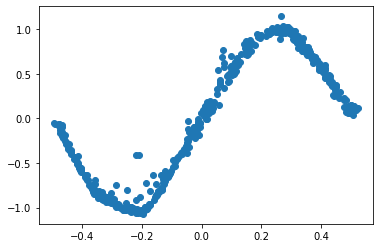

[GAN training] Epoch 59799/60000:
        Acc. real: 0.4779999852180481
        Acc. fake: 0.5640000104904175


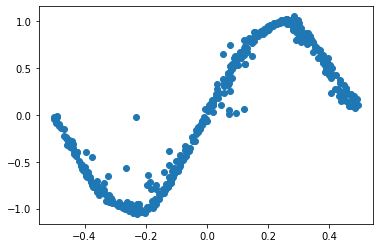

[GAN training] Epoch 59899/60000:
        Acc. real: 0.4359999895095825
        Acc. fake: 0.6259999871253967


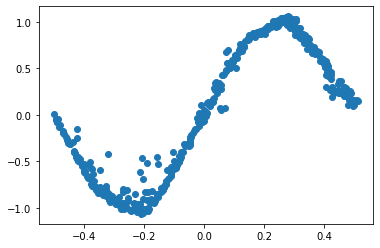

[GAN training] Epoch 59999/60000:
        Acc. real: 0.5600000023841858
        Acc. fake: 0.6320000290870667


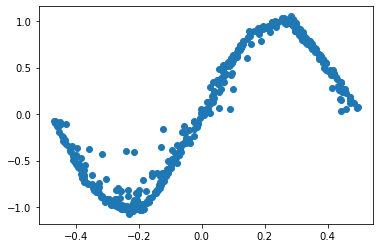

GAN training done


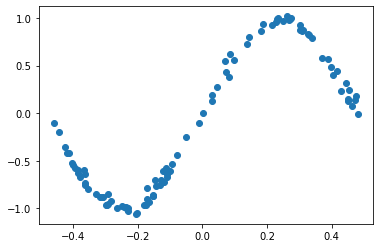

done


In [8]:
# hlavný proces

# inputs = np.linspace(0, 1, num=100)
# outputs = [basic_function(x*10) for x in inputs]
# print(inputs, outputs)
# pyplot.plot(inputs, outputs)
# pyplot.show
# samples = generate_real_samples(100) # tieto vygenerované vzorky predstavujú páry XY
# pyplot.scatter(samples[:, 0], samples[:, 1])

discriminator = define_discriminator()
# discriminator.summary()

generator = define_generator(5)
x_real, y_real = generate_real_samples(100)
pyplot.scatter(x_real[:, 0], x_real[:, 1])
pyplot.show()
x_new, y_new = generate_new_samples(generator, 5, 100)
pyplot.scatter(x_new[:, 0], x_new[:, 1])
pyplot.show()

gan_model = define_gan_model(generator, discriminator)
gan_model.summary()

train_gan(gan_model, generator, discriminator,
          5, n_epochs=60000, n_batch=128, n_eval=100)

print("GAN training done")

x_new, y_new = generate_new_samples(generator, 5, 100)
pyplot.scatter(x_new[:, 0], x_new[:, 1])
pyplot.show()


# spoločný model sa trénuje vygenerovaním vzoriek v počte premennej "batch"
# a volaním funkcie train_on_batch()



print('done')